# Setting up the Notebook

In [1]:
# Things to import

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

# Visualization tools
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Data manipulation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# ETS
import statsmodels
import statsmodels.tsa.statespace.exponential_smoothing

# SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAXResults

# XGBoost
import xgboost as xgb

# ANN
from tensorflow import keras
from keras import utils
import tensorflow as tf

# RL
import torch
import gym
from gym import Env
from gym.spaces import Discrete, Box
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import Adam
from collections import deque

In [2]:
print('Seaborn version:',sns.__version__)
print('Statsmodels version:',statsmodels.__version__)
print('XGBoost version:',xgb.__version__)
print('Tensorflow version:',tf.__version__)
print('Pytorch version:',torch.__version__)
print('Gym version:',gym.__version__)

import sys

print('Python version:',sys.version)

Seaborn version: 0.11.2
Statsmodels version: 0.13.2
XGBoost version: 1.5.2
Tensorflow version: 2.8.0
Pytorch version: 1.10.1+cpu
Gym version: 0.19.0
Python version: 3.7.11 (default, Jul 27 2021, 09:42:29) [MSC v.1916 64 bit (AMD64)]


## PCA Functions

In [3]:
# Defining a function to create two PCA matrices

def PCA_creation_train_test(no_components, X_train, X_test):
    
    # Scaling the data with our X_train matrix
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)
    
    # Fitting the PCA to our X_train matrix
    pca=PCA(n_components=no_components)
    X_train=pca.fit_transform(X_train)

    # Scaling X_test 
    X_test=scaler.transform(X_test)

    # Transforming X_test
    X_test=pca.transform(X_test)
    
    return X_train, X_test

In [4]:
# Defining a function to create three PCA matrices

def PCA_creation_train_val_test(no_components, X_train, X_val, X_test):
    
    # Scaling the data with our X_train matrix
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)
    
    # Fitting the PCA to our X_train matrix
    pca=PCA(n_components=no_components)
    X_train=pca.fit_transform(X_train)

    # Scaling the X_val and X_test 
    X_val=scaler.transform(X_val)
    X_test=scaler.transform(X_test)

    # Transforming the X_val and X_test
    X_val=pca.transform(X_val)
    X_test=pca.transform(X_test)
    
    return X_train, X_val, X_test

## Actions, Agents, and Accuracy Functions

In [5]:
# Turning a list of percent changes into actions

def action_list(pred_pct_changes):
    actions=[]
    for i in range(len(pred_pct_changes)):
        percent_change=pred_pct_changes[i]
        if percent_change >=0:
            action=1
            actions.append(action)
        if percent_change <0:
            action=0
            actions.append(action)
    return actions

In [6]:
# Agent with Buy and Sell actions

def Agent(actions, pct_changes, init_balance):
    net_worth = init_balance
    prev_net_worth = init_balance
    pct_changes = pct_changes
    holding_asset = 0 # We use this to indicate if we are holding an asset or not. 0 is No, 1 is Yes
    actions_taken=[] # Keeping a log of our actions
    net_worths=[]
    
    if len(pct_changes) != len(actions):
        print('The lengths of the actions and pct changes are not the same!')
    
    for i in range(len(pct_changes)):
        action=actions[i]
        percent_change=pct_changes[i]
        
        if action ==1 and holding_asset == 0: # Enter the market with all of your current net worth. It is affected
            # by the percent change
            net_worth = prev_net_worth * (1 + percent_change)
            holding_asset = 1 # You are now holding an asset
            actions_taken.append('Bought')
            net_worths.append(net_worth)
            
        elif action == 1 and holding_asset == 1: # You already bought and are waiting to sell. It is affected by the 
            # percent change
            net_worth = prev_net_worth * (1 + percent_change)
            # Your holding_asset does not change
            actions_taken.append('Buy signal, but we are waiting to sell')
            net_worths.append(net_worth)
            pass

        elif action == 0 and holding_asset == 1: # You leave the market
            net_worth = prev_net_worth # Your net worth doesn't change
            holding_asset = 0 # You are no longer holding any assets
            actions_taken.append('Sold')
            net_worths.append(net_worth)
            
        elif action == 0  and holding_asset == 0: # You already sold and are waiting for a buy signal
            net_worth = prev_net_worth # Your net worth doesn't change
            # Your holding_asset does not change
            actions_taken.append('Sell signal, but we are waiting to buy')
            net_worths.append(net_worth)
            pass
        
        # Updating our prev_net_worth for the next cycle
        prev_net_worth=net_worth
    return net_worths

In [7]:
# Accuracy with actions and true percent changes

def accuracy(actions, y_test, start_index):
    acc_list=[]
    for i in range(len(actions)):
        if y_test[i]<=0:
            act=0
        if y_test[i]>0:
            act=1
        if actions[i]==act:
            acc_list.append(1)
    accuracy=sum(acc_list)/len(actions)
    
    return 100*accuracy

## Agent Performance Visualization Functions

In [8]:
def investing_performance(model, y_test, starting_index, end_index):
    # Note, here, we do NOT need to account for the length of y_test, as our train and test creation process
    # guarantees that they're the same. But we DO need to account for the length of our test_pct_changes
    # with a beginning and ending index, as our CNN and LSTM need the forst 11/17/23 slices to create their
    # elements, and then they miss the last one.
    
    # Load the model
    model= keras.models.load_model(model)
    
    # Confusion Matrix    
    y_pred=model.predict(X_test) # Returns a list where every element is an array with the continuous
    # value prediction
    actions=[x[0] for x in y_pred] # Getting all the continuous value predictions from the arrays
    for i in range(len(y_pred)): # Transforming the continuous value into binary labels
        if actions[i] <= 0.5:
            actions[i] = 0
        if actions[i] > 0.5:
            actions[i] = 1
            
    if len(actions) != len(y_test):
        print('Check the lengths!')
    else:
        print('The lengths of the actions and y test are the same.')

    y_test=[int(x) for x in y_test]
    #Confusion Matrix    
    cm=confusion_matrix(y_test, actions)

    
    # Accuracy    
    acc_list=[]
    for i in range(len(actions)):
        if y_test[i]==actions[i]:
            acc_list.append(1)
    accuracy=round(sum(acc_list)/len(actions),2)
    
    # Getting the net worth    
    _, test_pct_changes=testing_data_pct_changes(dfs, 'hour') # Getting the percent changes of our testing data
    test_pct_changes=test_pct_changes.values
    if end_index == 'None':
        test_pct_changes = test_pct_changes[starting_index:]
        if len(test_pct_changes) != len(actions):
            print('Check the length of the test pct changes and actions!')
        else:
            print('The lengths of the test pct changes and actions are the same.')
        net_worths=Agent(actions, test_pct_changes, 1000)
    else:
        test_pct_changes = test_pct_changes[starting_index:end_index]
        net_worths=Agent(actions, test_pct_changes, 1000)
        if len(test_pct_changes) != len(actions):
            print('Check the length of the test pct changes and actions!')
        else:
            print('The lengths of the test pct changes and actions are the same.')
        
    return 100*accuracy, net_worths, cm

In [9]:
def investing_performance_xgb(model, y_test, starting_index, end_index):
    
    # Confusion Matrix    
    y_pred=model.predict(X_test) # Returns a list where every element is an array with the continuous
    # value prediction
    actions=[int(x) for x in y_pred] # Getting all the continuous value predictions from the arrays
    for i in range(len(y_pred)): # Transforming the continuous value into binary labels
        if actions[i] <= 0.5:
            actions[i] = 0
        if actions[i] > 0.5:
            actions[i] = 1
    if len(actions) != len(y_test):
        print('Check the lengths!')
    else:
        print('The lengths of the actions and y test are the same.')
    y_test=[int(x) for x in y_test]
    #Confusion Matrix    
    cm=confusion_matrix(y_test, actions)

    
    # Accuracy    
    acc_list=[]
    for i in range(len(actions)):
        if y_test[i]==actions[i]:
            acc_list.append(1)
    accuracy=round(sum(acc_list)/len(actions),2)
    
    # Getting the net worth    
    _, test_pct_changes=testing_data_pct_changes(dfs, 'hour') # Getting the percent changes of our testing data
    test_pct_changes=test_pct_changes.values
    if end_index == 'None':
        test_pct_changes = test_pct_changes[starting_index:]
        net_worths=Agent(actions, test_pct_changes, 1000)
    else:
        test_pct_changes = test_pct_changes[starting_index:end_index]
        net_worths=Agent(actions, test_pct_changes, 1000)
        
    return 100*accuracy, net_worths, cm

In [10]:
# RL Investing

def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, info = env.step(action)
            reward += r
            if done:
                break

        rewards.append(reward)
    return np.mean(rewards), info

def test_agent_net_worths(env, agent, num_test_episodes, max_ep_len):
    ep_rets, ep_lens = [], []
    for j in range(num_test_episodes):
        state, done, ep_ret, ep_len = env.reset(), False, 0, 0
        while not(done or (ep_len == max_ep_len)):
            # Take deterministic actions at test time (noise_scale=0)
            state, reward, done, info = env.step(agent.get_action(state, 0))
            ep_ret += reward
            ep_len += 1
        ep_rets.append(ep_ret)
        ep_lens.append(ep_len)
    return np.mean(ep_rets), np.mean(ep_lens), info

def investing_performance_rl(model, X_test, y_test, env):
    
    agent = torch.load(model)
    df=X_test
    y=y_test
    max_length=len(df)
    n_games=1
    
    if env == 'DQN':
        test_env = DQN_FinEnv(df, y) 
        final_score, net_worths = evaluate(test_env,agent, n_games=n_games, greedy=True, t_max=max_length)
        
        
    if env == 'T3D':
        test_env = T3D_FinEnv(df, y)
        reward, ep_len, info = test_agent_net_worths(test_env, agent, n_games, max_length)
        net_worths = [x[0][0] for x in info]
        
    return net_worths

In [11]:
def confusion_matrices_4_by_4(cms):
    
    # Creating Axes
    fig, ax = plt.subplots(nrows=2, ncols=2)
    
    # Heatmaps of Confusion Matrices
    sns.heatmap(cms[0], annot=True, fmt='g', ax=ax[0,0], cmap='Reds')
    sns.heatmap(cms[1], annot=True, fmt='g', ax=ax[0,1], cmap='Blues')
    sns.heatmap(cms[2], annot=True, fmt='g', ax=ax[1,0], cmap='Greens')
    sns.heatmap(cms[3], annot=True, fmt='g', ax=ax[1,1], cmap='Purples')
    
    # Labeling
    fig.suptitle('Confusion Matrices')
    ax[0,0].set_xlabel('');ax[0,0].set_ylabel('True labels'); 
    ax[0,0].xaxis.set_ticklabels(['Sell', 'Buy']); ax[0,0].yaxis.set_ticklabels(['Sell', 'Buy']);
    
    ax[0,1].set_xlabel('');ax[0,1].set_ylabel('True labels'); 
    ax[0,1].xaxis.set_ticklabels(['Sell', 'Buy']); ax[0,1].yaxis.set_ticklabels(['Sell', 'Buy']);
    
    ax[1,0].set_xlabel('');ax[1,0].set_ylabel('True labels'); 
    ax[1,0].xaxis.set_ticklabels(['Sell', 'Buy']); ax[1,0].yaxis.set_ticklabels(['Sell', 'Buy']);
    
    ax[1,1].set_xlabel('');ax[1,1].set_ylabel('True labels'); 
    ax[1,1].xaxis.set_ticklabels(['Sell', 'Buy']); ax[1,1].yaxis.set_ticklabels(['Sell', 'Buy']);

In [12]:
def portfolio_movement_5_agents(agents_net_worths, Other, model_name, start_index, end_index):
    if end_index == 'None':
        Other = Other[start_index:]
        if len(Other) != len(agents_net_worths[0]):
            print('Check the lengths of Buy-and-Hold and the net worths!')
        else:
            print('The lengths of Buy-and-Hold and the agents are the same.')
    
        plt.rcParams.update({'figure.figsize':(12,5), 'figure.dpi':120})

        plt.title('Value of '+str(init_balance)+' Dollar Investment')

        plt.plot(Other, color='black', label='Buy-and-Hold')
        plt.plot(agents_net_worths[0], color='red', linestyle='--', label=model_name)
        plt.plot(agents_net_worths[1], color='blue', linestyle='--', label=model_name)
        plt.plot(agents_net_worths[2], color='green', linestyle='--', label=model_name)
        plt.plot(agents_net_worths[3], color='purple', linestyle='--', label=model_name)
        
        plt.xlabel('Hours')
        plt.ylabel('Value')

        plt.legend()
    else: 
        Other = Other[start_index:end_index]
        if len(Other) != len(agents_net_worths[0]):
            print('Check the lengths of Buy-and-Hold and the net worths!')
        else:
            print('The lengths of Buy-and-Hold and the agents are the same.')
        
        plt.rcParams.update({'figure.figsize':(12,5), 'figure.dpi':120})

        plt.title('Value of '+str(init_balance)+' Dollar Investment')

        plt.plot(Other, color='black', label='Buy-and-Hold')
        plt.plot(agents_net_worths[0], color='red', linestyle='--', label=model_name)
        plt.plot(agents_net_worths[1], color='blue', linestyle='--', label=model_name)
        plt.plot(agents_net_worths[2], color='green', linestyle='--', label=model_name)
        plt.plot(agents_net_worths[3], color='purple', linestyle='--', label=model_name)
        
        plt.xlabel('Hours')
        plt.ylabel('Value')
        
        plt.legend()

    print('The lengths of the net worths and the Buy-and-Hold startegies are', len(Other),
          len(agents_net_worths[0]),
          len(agents_net_worths[1]),
          len(agents_net_worths[0]),
          len(agents_net_worths[0]))    
    print('The final value with Buy-and-Hold is', round(Other[-1],2))      

## Financial Environments

In [13]:
class DQN_FinEnv(Env):
    # A custom Bitcoin trading environment
    def __init__(self, df, y, initial_balance=1000):
        # Define action space and state size and other custom parameters
        self.df = df
        self.y = y
        self.df_total_steps = len(self.df) # How many steps we can possibly take
        self.initial_balance = initial_balance # How much we start with
        self.holding_asset = 0 # We use this to indicate if we are holding an asset or not. 0 is No, 1 is Yes
        self.actions_taken=[] # Keeping a log of our actions
        
        # Orders history contains the our net worth at each step
        self.orders_history = deque(maxlen=self.df_total_steps)
        
        # Market history contains the current market values
        self.market_history = deque(maxlen=1)

        # Action space. 1 is Buy and 0 is Sell
        self.action_space = np.array([0, 1])

        # State size contains the 20 PCA data points per time for 12 time slices
        self.state_size = df[0].shape

    # Reset the state of the environment to an initial state
    def reset(self, env_steps_size=0):
        self.net_worth = self.initial_balance
        self.prev_net_worth = self.initial_balance
        self.holding_asset = 0 # We are not holding anything in the beginning
        self.actions_taken=[] # Keeping a log of our actions
        if env_steps_size > 0: # used for training dataset
            self.start_step = random.randint(0, self.df_total_steps - env_steps_size) # Picks a random step to start from
            self.end_step = self.start_step + env_steps_size # Runs from the randomly chosen step to that step+env_steps we want
        else: # used for testing dataset
            self.start_step = 0
            self.end_step = self.df_total_steps-1

        self.current_step = self.start_step

        self.state = self.df[self.current_step] # State is the state of the market
        # print('Beginning State', self.state)

        return self.state

    # Get the data points for the given current_step
    def _next_observation(self):
        obs = self.df[self.current_step] # Will be what the nn sees to make a decision
        # print('Obs next_observation', obs)
        return obs

    # Execute one time step within the environment
    def step(self, action):
        # print('Action', action)
        # Percent Change
        self.percent_change=self.y[self.current_step]
        # print('Percent Change on this step', self.percent_change)
        
        if action == 1 and self.holding_asset == 0: # Enter the market with all of your current net worth. It is affected
            # by the percent change
            self.net_worth = self.prev_net_worth * (1 + self.percent_change/100)
            self.holding_asset = 1 # You are now holding an asset
            self.actions_taken.append('Bought')
            
        elif action == 1 and self.holding_asset == 1: # You already bought and are waiting to sell. It is affected by the 
            # percent change
            self.net_worth = self.prev_net_worth * (1 + self.percent_change/100)
            # Your holding_asset does not change
            self.actions_taken.append('Buy signal, but we are waiting to sell')
            pass

        elif action == 0 and self.holding_asset == 1: # You leave the market
            self.net_worth = self.prev_net_worth # Your net worth doesn't change
            self.holding_asset = 0 # You are no longer holding any assets
            self.actions_taken.append('Sold')
            
        elif action==0  and self.holding_asset == 0: # You already sold and are waiting for a buy signal
            self.net_worth = self.prev_net_worth # Your net worth doesn't change
            # Your holding_asset does not change
            self.actions_taken.append('Sell signal, but we are waiting to buy')
            pass
        # Reward
        reward=self.net_worth-self.prev_net_worth # Our reward is the change in our net worth
        
        # Updating our prev_net_worth
        self.prev_net_worth = self.net_worth # Updating our prev_net_worth for the next time step
        # print('Net worth after market acts', self.prev_net_worth)

        self.orders_history.append([self.net_worth]) # Adding our net worth to our orders_history
        
        # Leave the market if we have lost half our money
        if self.net_worth <= self.initial_balance/2:
            done = True
        else:
            done = False

        # Stepping into the next state
        if self.current_step == self.end_step:
            # print('We are done stepping', self.current_step)
            obs=[]
            done = True
        else:    
            self.current_step += 1    
            obs = self._next_observation() # Moves us to the next observation
        
        # Set net worths as info so we can retrieve it at the end
        info = self.orders_history
        
        # Return step information   
        return obs, reward, done, info
    # render environment
    def render(self, mode='human'): # 'mode=human' is required for the Keras-RL package
        print(f'Step: {self.current_step}, Beginning Net Worth: {self.net_worth}')

In [14]:
class T3D_FinEnv(Env):
    
    # A custom Bitcoin trading environment
    def __init__(self, df, y, initial_balance=1000):
        # Define action space and state size and other custom parameters
        self.df = df
        self.y = y
        self.df_total_steps = len(self.df) # How many steps we can possibly take
        self.initial_balance = initial_balance
        self.current_balance = self.initial_balance # How much we currently have 
        self.current_investment = 0 # In the beginning, we have nothing invested
        self.net_worth = self.initial_balance # How much we have between our investment and our balance
        self.actions_taken=[] # Keeping a log of our actions
        
        # Orders history contains the balance, net_worth, crypto_bought, crypto_sold, crypto_held values for the last lookback_window_size steps
        self.orders_history = deque(maxlen=self.df_total_steps)
        
        # Market history
        self.market_history = deque(maxlen=1)

        # Action space is 1D. Between 0 and 1 is Buy and between -1 and 0 is Sell
        self.action_space = Box(low=-1, high=1, shape=(1,), dtype=np.float32)

        # State size contains the 12 time slices of 
        # 20 PCA data points per time slice plus the current balance and investment added on
        self.observation_space = np.zeros((1,13,20))

    # Reset the state of the environment to an initial state
    def reset(self, env_steps_size=0):
        self.net_worth = self.initial_balance
        self.prev_net_worth = self.initial_balance
        self.current_balance = self.initial_balance # How much we currently have 
        self.current_investment = 0 # In the beginning, we have nothing invested
        self.actions_taken=[] # Keeping a log of our actions
        if env_steps_size > 0: # used for training dataset
            self.start_step = random.randint(0, self.df_total_steps - env_steps_size) # Picks a random step to start from
            self.end_step = self.start_step + env_steps_size # Runs from the randomly chosen step to that step+env_steps we want
        else: # used for testing dataset
            self.start_step = 0
            self.end_step = self.df_total_steps-1
            
        self.current_step = self.start_step

        # Getting the state information
        self.state = self.df[self.current_step]
        self.cb = self.current_balance/1000
        self.ci = self.current_investment/1000 # State is the state of the 
        # market and how much we have as balance and invested. We divide by 1000 to have it on the same scale
        # as the other state information
        self.portfolio = [self.cb, self.ci, self.cb, self.ci, self.cb, self.ci, self.cb, self.ci,
                         self.cb, self.ci, self.cb, self.ci, self.cb, self.ci, self.cb, self.ci,
                         self.cb, self.ci, self.cb, self.ci]
        self.state1 = np.vstack((self.state[0], self.portfolio))
        self.state2 = np.expand_dims(self.state1, axis=0)
        self.state = np.float64(self.state2) # Required to transform the state into a torch tensor
        return self.state

    # Get the data points for the given current_step
    def _next_observation(self):
        
        obs = self.df[self.current_step]
        cb = np.float64(self.current_balance/1000)
        ci = np.float64(self.current_investment/1000) # State is the state of the 
        # market and how much we have as balance and invested. We divide by 1000 to have it on the same scale
        # as the other state information
        portfolio = [cb, ci, cb, ci, cb, ci, cb, ci,
                         cb, ci, cb, ci, cb, ci, cb, ci,
                         cb, ci, cb, ci]
        obs1 = np.vstack((obs[0], portfolio))
        obs2 = np.expand_dims(obs1, axis=0)
        obs = np.float64(obs2) # Required to transform the obs into a torch tensor
        return obs
    
    # Execute one time step within the environment
    def step(self, action):
        
#         print('Action Pre-Clip',action)
        action = np.clip(action, -1.0, 1.0)
#         print('Action Post-Clip', action)
        
        # Percent Change
        self.percent_change = self.y[self.current_step]
#         print('Percent Change ', self.percent_change)
        
        # Investment and balance
        if action >= 0: # If our action is to buy, we will invest the percent dictated by the action 
            # and add it to our current investment
            
#             print('Investment before agent acts', self.current_investment)
#             print('Balance before agent acts', self.current_balance)
#             print('Net Worth before agent acts', self.net_worth)
            
            # Decreasing our balance and increasing our investment
            self.current_investment = self.current_investment + (action)*self.current_balance # Adding to our investment
            self.actions_taken.append('Bought '+str(action*self.current_balance)) # Logging our buy before
            # we change our balance to reflect that we bought
            self.current_balance = self.current_balance - (action)*self.current_balance # Removing that same amount from our balance
    
#             print('Investment after agent acts', self.current_investment)
#             print('Balance after agent acts', self.current_balance)
#             print('Net Worth after agent acts', self.net_worth)
            
            # Now, the market will act and we will update our investment and overall net worth
            self.current_investment = (1 + self.percent_change/100)*self.current_investment
            self.net_worth = self.current_investment + self.current_balance # Our net worth
            # will be our current balance plus our investment, which will change during this time slice by
            # the percent change
            
#             print('Investment after market acts', self.current_investment)
#             print('Balance after market acts', self.current_balance)
#             print('Net Worth after market acts', self.net_worth)
        
        elif action < 0: # If our action is to sell, we will sell the percent dictated by the action of our investment
            # and add it to our current balance
            
#             print('Investment before agent acts', self.current_investment)
#             print('Balance before agent acts', self.current_balance)
#             print('Net Worth before agent acts', self.net_worth)
            
            # Decreasing our investment and increasing our balance
            self.current_balance = self.current_balance + np.abs(action)*self.current_investment # Adding to our balance
            self.actions_taken.append('Sold '+str(action*self.current_investment)) # Logging our sell before
            # we change the investment
            self.current_investment = self.current_investment - np.abs(action)*self.current_investment # Removing that same amount from our investment
            
#             print('Investment after agent acts', self.current_investment)
#             print('Balance after agent acts', self.current_balance)
#             print('Net Worth after agent acts', self.net_worth)
            
            
            # Now, the market will act and we will update our investment and overall net worth
            self.current_investment = (1 + self.percent_change/100)*self.current_investment
            self.net_worth = self.current_investment + self.current_balance # Our net worth
            # will be our current balance plus our investment, which will change during this time slice by
            # the percent change
            
#             print('Investment after market acts', self.current_investment)
#             print('Balance after market acts', self.current_balance)
#             print('Net Worth after market acts', self.net_worth)
#         print('\n')

        # Reward        
        reward = self.net_worth-self.prev_net_worth # Our reward is the change in our net worth
        
        # Updating our prev_net_worth
        self.prev_net_worth = self.net_worth # Updating our prev_net_worth for the next time step

        self.orders_history.append([self.net_worth]) # Adding our net worth to our orders_history
        
        # # Leave the market if we have lost half our money
        # if self.net_worth <= self.initial_balance/2:
        #     done = True
        # else:
        #     done = False
            
        # Stepping into the next state
        if self.current_step == self.end_step:
            # print('We are done stepping', self.current_step)
            obs=[]
            done = True
        else:    
            self.current_step += 1    
            obs = self._next_observation() # Moves us to the next observation
            done = False
            
        # Set net worths as info so we can retrieve it at the end
        info = self.orders_history

        return obs, reward, done, info

    # render environment
    def render(self, mode='human'): # 'mode=human' is required for the Keras-RL package
        print(f'Step: {self.current_step}, Net Worth: {self.net_worth}')

# Importing the Data Functions

In [15]:
dfs=['Non-Scaled TA Features 1H for BTC.csv'] # Note, this is also set up for minute data, but that was not
# implemented in this particular iteration

def testing_data_labels(dfs, time_frame):
    if time_frame == 'hour':
        X=pd.read_csv(dfs[0])
        X['Date']=pd.to_datetime(X['Date']) # Setting the index as the Date
        X=X.set_index('Date').asfreq('H')
        X=X.dropna()
        y=X['Label']
        X=X.drop('Label', axis=1)
        X=X.drop('Percent Change', axis=1)

        # Removing the testing data
        X_test=X[-4380:] # Getting the last 6 months as the testing data
        y_test=y[-4380:]
        
    if time_frame == 'minute':
        X=pd.read_csv(dfs[1])
        X['Date']=pd.to_datetime(X['Date']) # Setting the index as the Date
        X=X.set_index('Date').asfreq('M')
        X=X.dropna()
        y=X['Label']
        X=X.drop('Label', axis=1)
        X=X.drop('Percent Change', axis=1)

        # Removing the testing data
        X_test=X[-262974:] # Getting the last 6 months as the testing data
        y_test=y[-262974:]

    return X_test, y_test

def testing_data_pct_changes(dfs, time_frame):
    if time_frame == 'hour':
        X=pd.read_csv(dfs[0])
        X['Date']=pd.to_datetime(X['Date']) # Setting the index as the Date
        X=X.set_index('Date').asfreq('H')
        X=X.dropna()
        y=X['Percent Change']
        X=X.drop('Label', axis=1)
        X=X.drop('Percent Change', axis=1)

        # Removing the testing data
        X_test=X['2021-07-02 11:00:00':] # Getting the last 6 months as the testing data
        y_test=y['2021-07-02 11:00:00':]
        
    if time_frame == 'minute':
        X=pd.read_csv(dfs[1])
        X['Date']=pd.to_datetime(X['Date']) # Setting the index as the Date
        X=X.set_index('Date').asfreq('M')
        X=X.dropna()
        y=X['Percent Change']
        X=X.drop('Label', axis=1)
        X=X.drop('Percent Change', axis=1)

        # Removing the testing data
        X_test=X[-262974:] # Getting the last 6 months as the testing data
        y_test=y[-262974:]
    
    return X_test, y_test/100

def training_data_pct_changes(dfs, time_frame):
    if time_frame == 'hour':
        X=pd.read_csv(dfs[0])
        X['Date']=pd.to_datetime(X['Date']) # Setting the index as the Date
        X=X.set_index('Date').asfreq('H')
        X=X.dropna()
        y=X['Percent Change']
        X=X.drop('Label', axis=1)
        X=X.drop('Percent Change', axis=1)

        # Removing the testing data
        X_test=X['2021-07-02 11:00:00':] # Getting the last 6 months as the testing data
        y_test=y['2021-07-02 11:00:00':]
        
        y_train=y[:'2021-07-02 11:00:00']
        
    if time_frame == 'minute':
        X=pd.read_csv(dfs[1])
        X['Date']=pd.to_datetime(X['Date']) # Setting the index as the Date
        X=X.set_index('Date').asfreq('M')
        X=X.dropna()
        y=X['Percent Change']
        X=X.drop('Label', axis=1)
        X=X.drop('Percent Change', axis=1)

        # Removing the testing data
        X_test=X[-262974:] # Getting the last 6 months as the testing data
        y_test=y[-262974:]
    
    return y_train/100

def testing_close(dfs, time_frame):
    if time_frame == 'hour':
        X=pd.read_csv(dfs[0])
        X['Date']=pd.to_datetime(X['Date']) # Setting the index as the Date
        X=X.set_index('Date').asfreq('H')
        X=X.dropna()
        y=X['Close']
        y_test_close=y['2021-07-02 11:00:00':]
        
    if time_frame == 'minute':
        X=pd.read_csv(dfs[1])
        X['Date']=pd.to_datetime(X['Date']) # Setting the index as the Date
        X=X.set_index('Date').asfreq('M')
        X=X.dropna()
        y=X['Close']
        y_test_close=y[-262974:]
        
    return y_test_close

# Buy-and-Hold

In [16]:
def Buy_and_Hold(test_pct_changes, init_balance):
    curr_balance=init_balance
    balances=[]
    
    for pct_chng in test_pct_changes:
        curr_balance=curr_balance*(1+pct_chng)
        balances.append(curr_balance)
        
    return balances

In [17]:
init_balance=1000
_,y_test=testing_data_pct_changes(dfs, 'hour')
print('Checking y_test:',y_test)
B_and_H=Buy_and_Hold(y_test, init_balance)
print('The length of Buy-and-Hold is:',len(B_and_H))
print('Buy-and-Hold runs from', y_test.index[0], 'to', y_test.index[-1])

Checking y_test: Date
2021-07-02 11:00:00    0.006145
2021-07-02 12:00:00    0.008087
2021-07-02 13:00:00    0.005052
2021-07-02 14:00:00    0.000595
2021-07-02 15:00:00   -0.001634
                         ...   
2021-12-31 18:00:00   -0.020274
2021-12-31 19:00:00    0.003793
2021-12-31 20:00:00    0.009870
2021-12-31 21:00:00   -0.000140
2021-12-31 22:00:00   -0.002339
Freq: H, Name: Percent Change, Length: 4380, dtype: float64
The length of Buy-and-Hold is: 4380
Buy-and-Hold runs from 2021-07-02 11:00:00 to 2021-12-31 22:00:00


The final value with Buy-and-Hold is 1399.21


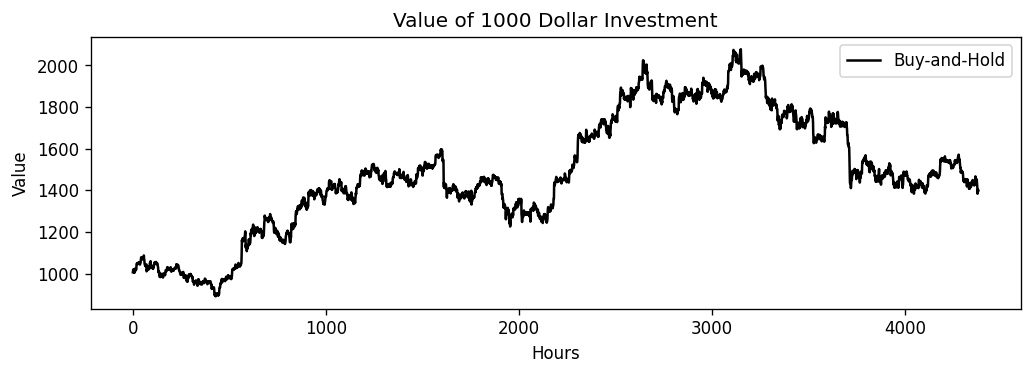

In [18]:
plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.title('Value of '+str(init_balance)+' Dollar Investment')
plt.plot(B_and_H, color='black', label='Buy-and-Hold')
plt.xlabel('Hours')
plt.ylabel('Value')
plt.legend()

print('The final value with Buy-and-Hold is', round(B_and_H[-1],2))

# Random Agent and TA Agents

## Random Agent

In [19]:
def rand_actions(num_actions):
    actions=np.random.randint(2, size=num_actions)
    
    return actions

In [20]:
_, test_pct_changes=testing_data_pct_changes(dfs, 'hour') # Getting the percent changes of our testing data
test_pct_changes=test_pct_changes.values
rand_agent1=rand_actions(len(test_pct_changes))
rand_agent2=rand_actions(len(test_pct_changes))
rand_agent3=rand_actions(len(test_pct_changes))
rand_agent4=rand_actions(len(test_pct_changes))

print('Length of the Random Agent is:',len(rand_agent1))
print('Length of the test percent changes is:',len(test_pct_changes))

Random_net_worths1=Agent(rand_agent1, test_pct_changes, 1000)
Random_net_worths2=Agent(rand_agent2, test_pct_changes, 1000)
Random_net_worths3=Agent(rand_agent3, test_pct_changes, 1000)
Random_net_worths4=Agent(rand_agent4, test_pct_changes, 1000)

Length of the Random Agent is: 4380
Length of the test percent changes is: 4380


The final value with Buy-and-Hold is 1399.21
The final value with Random Agent is 1322.17
The final value with Random Agent is 866.85
The final value with Random Agent is 1276.3
The final value with Random Agent is 1244.23


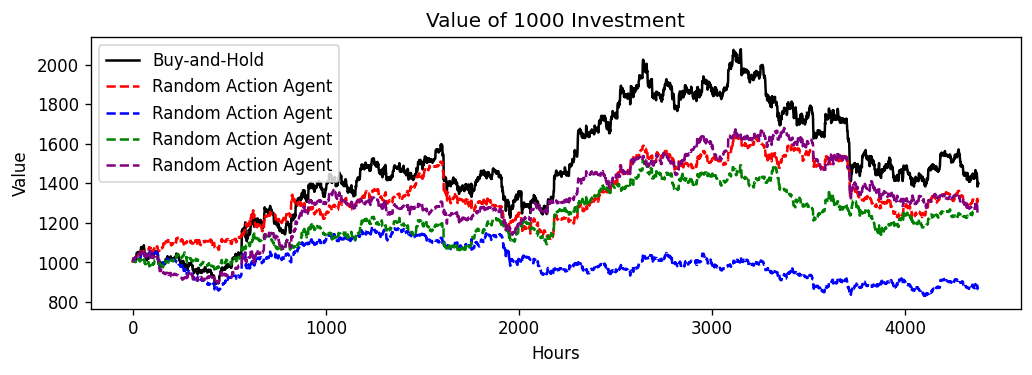

In [21]:
# Plotting

plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot(B_and_H, label='Buy-and-Hold', color='black')
plt.plot(Random_net_worths1, label="Random Action Agent", color='red', linestyle="--")
plt.plot(Random_net_worths2, label="Random Action Agent", color='blue', linestyle="--")
plt.plot(Random_net_worths3, label="Random Action Agent", color='green', linestyle="--")
plt.plot(Random_net_worths4, label="Random Action Agent", color='purple', linestyle="--")
plt.title('Value of 1000 Investment')
plt.xlabel('Hours')
plt.ylabel('Value')
plt.legend()

print('The final value with Buy-and-Hold is', round(B_and_H[-1],2))
print('The final value with Random Agent is', round(Random_net_worths1[-1],2))
print('The final value with Random Agent is', round(Random_net_worths2[-1],2))
print('The final value with Random Agent is', round(Random_net_worths3[-1],2))
print('The final value with Random Agent is', round(Random_net_worths4[-1],2))

## RSI

In [76]:
# Agent with three options

def buy_sell_hold_agent(actions, pct_changes, init_balance):
    net_worth=init_balance
    prev_net_worth = init_balance
    holding_asset = 0 # We use this to indicate if we are holding an asset or not. 0 is No, 1 is Yes
    actions_taken=[] # Keeping a log of our actions
    net_worths=[]
    
    if len(actions) != len(pct_changes):
        print('The lengths are not the same!')
    
    for i in range(len(actions)):
        action=actions[i]
        percent_change=pct_changes[i]
        
        if action == 2 and holding_asset == 1: # We do nothing, but our assets are in the market. They are affected
            # by the percent change
            net_worth = prev_net_worth*(1+percent_change)
            net_worths.append(net_worth)
            actions_taken.append('Held with assets in the market')
        
        elif action == 2 and holding_asset == 0: # We do nothing, but our assets are out of the market. They are not
        # affected by the percent change
            net_worth = prev_net_worth
            net_worths.append(net_worth)
            actions_taken.append('Held with assets out of the market')
        
        elif action == 1 and holding_asset == 0: # Enter the market with all of your current net worth. It is affected
            # by the percent change
            net_worth = prev_net_worth * (1 + percent_change)
            holding_asset = 1 # You are now holding an asset
            actions_taken.append('Bought')
            net_worths.append(net_worth)
            
        elif action == 1 and holding_asset == 1: # You already bought and are waiting to sell. It is affected by the 
            # percent change
            net_worth = prev_net_worth * (1 + percent_change)
            # Your holding_asset does not change
            actions_taken.append('Buy signal, but we are waiting to sell')
            net_worths.append(net_worth)
            pass

        elif action == 0 and holding_asset == 1: # You leave the market
            net_worth = prev_net_worth # Your net worth doesn't change
            holding_asset = 0 # You are no longer holding any assets
            actions_taken.append('Sold')
            net_worths.append(net_worth)
            
        elif action == 0  and holding_asset == 0: # You already sold and are waiting for a buy signal
            net_worth = prev_net_worth # Your net worth doesn't change
            # Your holding_asset does not change
            actions_taken.append('Sell signal, but we are waiting to buy')
            net_worths.append(net_worth)
            pass
        
        # Updating our prev_net_worth for the next cycle
        prev_net_worth=net_worth
    return net_worths

In [77]:
# Determine RSI Actions

def rsi_actions(rsi):
    actions=[]
    for i in range(len(rsi)):
        if rsi[i]<=30:
            actions.append(1) # Buy
        elif rsi[i]>=70:
            actions.append(0) # Sell
        else:
            actions.append(2)
    return actions

In [78]:
# Getting our RSI values and agent behavior

_, test_pct_changes=testing_data_pct_changes(dfs, 'hour') # Getting the percent changes of our testing data

# RSI 10
X=pd.read_csv(dfs[0])
X_tot=X['RSI 10'].values
rsi_test_10=X_tot[-4380:]
rsi_10_actions=rsi_actions(rsi_test_10)
rsi_10_net_worths=buy_sell_hold_agent(rsi_10_actions, test_pct_changes, 1000)

# RSI 12
X=pd.read_csv(dfs[0])
X_tot=X['RSI 12'].values
rsi_test_12=X_tot[-4380:]
rsi_12_actions=rsi_actions(rsi_test_12)
rsi_12_net_worths=buy_sell_hold_agent(rsi_12_actions, test_pct_changes, 1000)

# RSI 14
X=pd.read_csv(dfs[0])
X_tot=X['RSI 14'].values
rsi_test_14=X_tot[-4380:]
rsi_14_actions=rsi_actions(rsi_test_14)
rsi_14_net_worths=buy_sell_hold_agent(rsi_14_actions, test_pct_changes, 1000)

# RSI 16
X=pd.read_csv(dfs[0])
X_tot=X['RSI 16'].values
rsi_test_16=X_tot[-4380:]
rsi_16_actions=rsi_actions(rsi_test_16)
rsi_16_net_worths=buy_sell_hold_agent(rsi_16_actions, test_pct_changes, 1000)

# RSI 18
X=pd.read_csv(dfs[0])
X_tot=X['RSI 18'].values
rsi_test_18=X_tot[-4380:]
rsi_18_actions=rsi_actions(rsi_test_18)
rsi_18_net_worths=buy_sell_hold_agent(rsi_18_actions, test_pct_changes, 1000)

# RSI 20
X=pd.read_csv(dfs[0])
X_tot=X['RSI 20'].values
rsi_test_20=X_tot[-4380:]
rsi_20_actions=rsi_actions(rsi_test_20)
rsi_20_net_worths=buy_sell_hold_agent(rsi_20_actions, test_pct_changes, 1000)

Text(0.5, 1.0, 'Relative Strength Index 10 Hours')

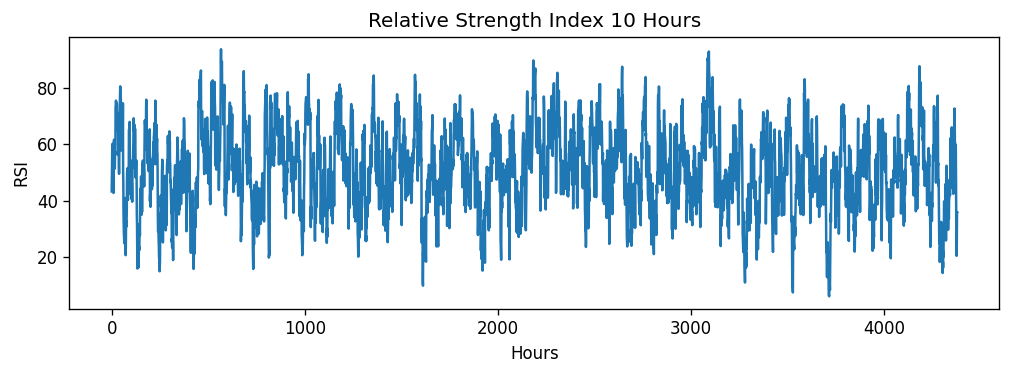

In [79]:
# Visualizing a single RSI

plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot(rsi_test_10, label='RSI 10')
plt.xlabel('Hours')
plt.ylabel('RSI')
plt.title('Relative Strength Index 10 Hours')

Length of RSI agent: 4380
Length of Buy-and-Hold: 4380
The final value with Buy-and-Hold is 1399.21
The final value with RSI 10 is 960.83
The final value with RSI 12 is 1073.62
The final value with RSI 14 is 1019.09
The final value with RSI 16 is 873.04
The final value with RSI 18 is 907.68
The final value with RSI 20 is 933.14


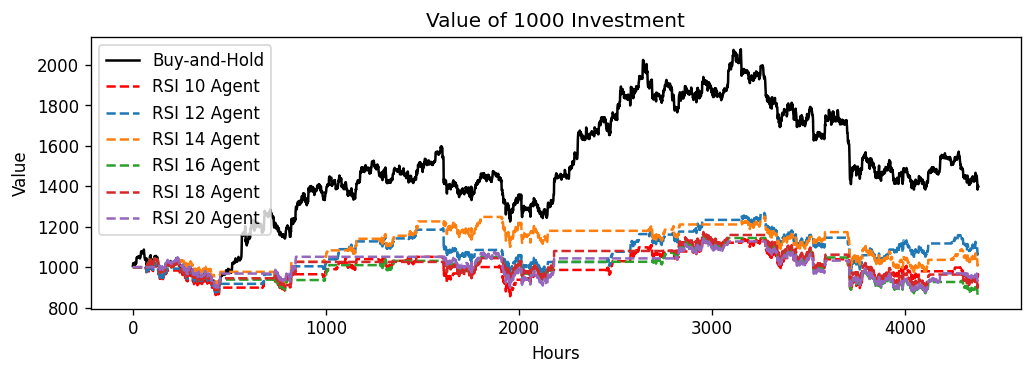

In [80]:
# Plotting

plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot(B_and_H, label='Buy-and-Hold', color='black')
plt.plot(rsi_10_net_worths, label="RSI 10 Agent", color='red', linestyle="--")
plt.plot(rsi_12_net_worths, label="RSI 12 Agent", linestyle="--")
plt.plot(rsi_14_net_worths, label="RSI 14 Agent", linestyle="--")
plt.plot(rsi_16_net_worths, label="RSI 16 Agent", linestyle="--")
plt.plot(rsi_18_net_worths, label="RSI 18 Agent", linestyle="--")
plt.plot(rsi_20_net_worths, label="RSI 20 Agent", linestyle="--")
plt.xlabel('Hours')
plt.ylabel('Value')
plt.title('Value of 1000 Investment')
plt.legend()
print('Length of RSI agent:', len(rsi_10_net_worths))
print('Length of Buy-and-Hold:', len(B_and_H))

print('The final value with Buy-and-Hold is', round(B_and_H[-1],2))
print('The final value with RSI 10 is', round(rsi_10_net_worths[-1],2))
print('The final value with RSI 12 is', round(rsi_12_net_worths[-1],2))
print('The final value with RSI 14 is', round(rsi_14_net_worths[-1],2))
print('The final value with RSI 16 is', round(rsi_16_net_worths[-1],2))
print('The final value with RSI 18 is', round(rsi_18_net_worths[-1],2))
print('The final value with RSI 20 is', round(rsi_20_net_worths[-1],2))

## MACD

In [30]:
# MACD Actions

def macd_actions(macd, macdsignal):
    actions=[]
    for i in range(1,len(macd)):# We cannot make a decision at the 0th position because we need to 
        # look back one position. So, we must start at the 1th.
        if macd[i-1]<macdsignal[i-1] and macd[i]>macdsignal[i]: # MACD crossing above the Signal Line is a Buy
            actions.append(1)
        elif macd[i-1]>macdsignal[i-1] and macd[i]<macdsignal[i]: # MACD crossing below the Signal Line is a Sell
            actions.append(0)
        else: # Hold otherwise
            actions.append(2)
    return actions

In [31]:
# MACD Agents

_,test_pct_changes=testing_data_pct_changes(dfs, 'hour')

X=pd.read_csv(dfs[0])
X['Date']=pd.to_datetime(X['Date'])
X=X.set_index('Date').asfreq('H')
macd_test_6=X['MACD 6']['2021-07-02 11:00:00':]
macdsignal_test_6=X['MACD Signal 6']['2021-07-02 11:00:00':]
macd_6_actions=macd_actions(macd_test_6, macdsignal_test_6)
macd_6_net_worths=buy_sell_hold_agent(macd_6_actions, test_pct_changes[1:], 1000) # We need to shift
# the test_pct_changes up by one, as we will be making our first decision on 2021-07-02 12:00:00

X=pd.read_csv(dfs[0])
X['Date']=pd.to_datetime(X['Date'])
X=X.set_index('Date').asfreq('H')
macd_test_9=X['MACD 9']['2021-07-02 11:00:00':]
macdsignal_test_9=X['MACD Signal 9']['2021-07-02 11:00:00':]
macd_9_actions=macd_actions(macd_test_9, macdsignal_test_9)
macd_9_net_worths=buy_sell_hold_agent(macd_9_actions, test_pct_changes[1:], 1000)

X=pd.read_csv(dfs[0])
X['Date']=pd.to_datetime(X['Date'])
X=X.set_index('Date').asfreq('H')
macd_test_12=X['MACD 12']['2021-07-02 11:00:00':]
macdsignal_test_12=X['MACD Signal 12']['2021-07-02 11:00:00':]
macd_12_actions=macd_actions(macd_test_12, macdsignal_test_12)
macd_12_net_worths=buy_sell_hold_agent(macd_12_actions, test_pct_changes[1:], 1000)

X=pd.read_csv(dfs[0])
X['Date']=pd.to_datetime(X['Date'])
X=X.set_index('Date').asfreq('H')
macd_test_15=X['MACD 15']['2021-07-02 11:00:00':]
macdsignal_test_15=X['MACD Signal 15']['2021-07-02 11:00:00':]
macd_15_actions=macd_actions(macd_test_15, macdsignal_test_15)
macd_15_net_worths=buy_sell_hold_agent(macd_15_actions, test_pct_changes[1:], 1000)

X=pd.read_csv(dfs[0])
X['Date']=pd.to_datetime(X['Date'])
X=X.set_index('Date').asfreq('H')
macd_test_18=X['MACD 18']['2021-07-02 11:00:00':]
macdsignal_test_18=X['MACD Signal 18']['2021-07-02 11:00:00':]
macd_18_actions=macd_actions(macd_test_18, macdsignal_test_18)
macd_18_net_worths=buy_sell_hold_agent(macd_18_actions, test_pct_changes[1:], 1000)

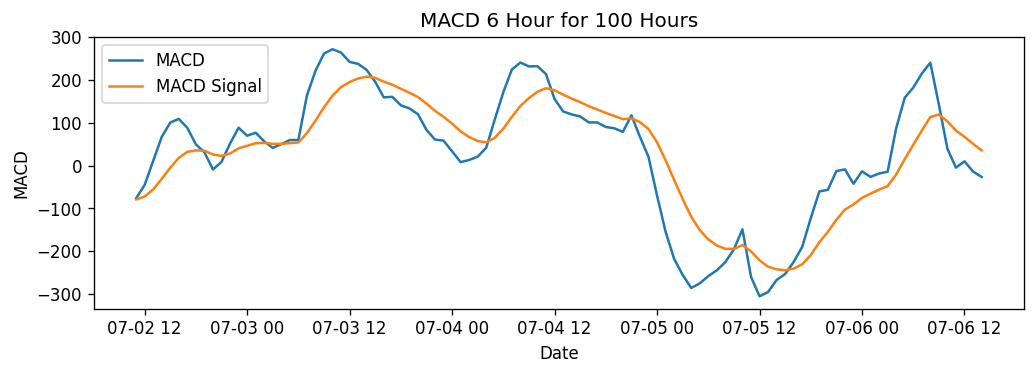

In [32]:
# Visualizing a single MACD for 100 hours

plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot(macd_test_6[:100], label='MACD')
plt.plot(macdsignal_test_6[:100], label='MACD Signal')
plt.xlabel('Date')
plt.ylabel('MACD')
plt.title('MACD 6 Hour for 100 Hours')
plt.legend()

Length of RSI agent: 4379
Length of Buy-and-Hold: 4379
The final value with Buy-and-Hold is 1399.21
The final value with MACD 6 is 1313.5
The final value with MACD 9 is 1236.47
The final value with MACD 12 is 1187.55
The final value with MACD 15 is 1193.53
The final value with MACD 18 is 1191.22


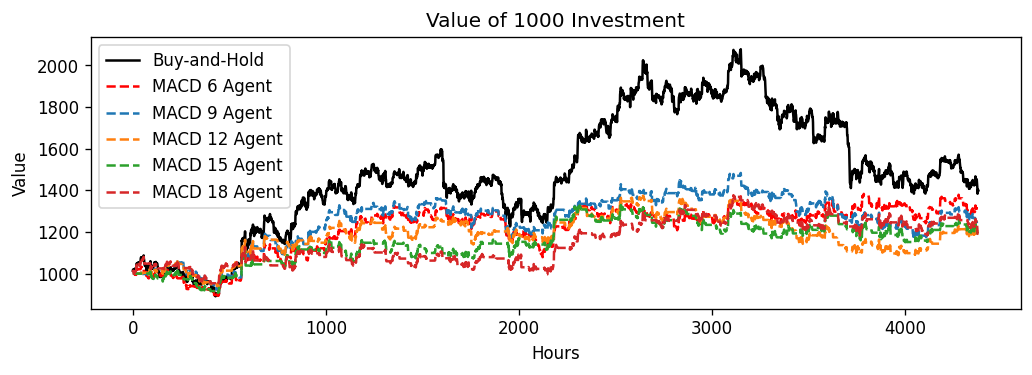

In [34]:
# Plotting

plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot(B_and_H[1:], label='Buy-and-Hold', color='black')
plt.plot(macd_6_net_worths, label="MACD 6 Agent", color='red', linestyle="--")
plt.plot(macd_9_net_worths, label="MACD 9 Agent", linestyle="--")
plt.plot(macd_12_net_worths, label="MACD 12 Agent", linestyle="--")
plt.plot(macd_15_net_worths, label="MACD 15 Agent", linestyle="--")
plt.plot(macd_18_net_worths, label="MACD 18 Agent", linestyle="--")
plt.xlabel('Hours')
plt.ylabel('Value')
plt.title('Value of 1000 Investment')
plt.legend()

print('Length of RSI agent:', len(macd_6_net_worths))
print('Length of Buy-and-Hold:', len(B_and_H[1:]))

print('The final value with Buy-and-Hold is', round(B_and_H[1:][-1],2))
print('The final value with MACD 6 is', round(macd_6_net_worths[-1],2))
print('The final value with MACD 9 is', round(macd_9_net_worths[-1],2))
print('The final value with MACD 12 is', round(macd_12_net_worths[-1],2))
print('The final value with MACD 15 is', round(macd_15_net_worths[-1],2))
print('The final value with MACD 18 is', round(macd_18_net_worths[-1],2))

## Aroon Oscillator

In [35]:
# Aroonosc Actions

def aroonosc_actions(aroonosc):
    actions=[]
    for i in range(1,len(aroonosc)): # We cannot make a decision at the 0th position because we need to 
        # look back one position. So, we must start at the 1th.
        if aroonosc[i-1]<=0 and aroonosc[i]>0: # Crossing the zero line from below is a Buy signal
            actions.append(1) # Buy
        elif aroonosc[i-1]>0 and aroonosc[i]<0: # Crossing the zero line from above is a Sell signal
            actions.append(0) # Sell
        else:
            actions.append(2)
    return actions

In [36]:
# Aroonosc Agents

_,testing=testing_data_pct_changes(dfs, 'hour')

X=pd.read_csv(dfs[0])
X['Date']=pd.to_datetime(X['Date'])
X=X.set_index('Date').asfreq('H')
aroonosc_test_10=X['Aroonosc 10']['2021-07-02 11:00:00':]
aroonosc_10_actions=aroonosc_actions(aroonosc_test_10)
aroonosc_10_net_worths=buy_sell_hold_agent(aroonosc_10_actions, test_pct_changes[1:], 1000) # We need to shift
# the test_pct_changes up by one, as we will be making our first decision on 2021-07-02 12:00:00

X=pd.read_csv(dfs[0])
X['Date']=pd.to_datetime(X['Date'])
X=X.set_index('Date').asfreq('H')
aroonosc_test_12=X['Aroonosc 12']['2021-07-02 11:00:00':]
aroonosc_12_actions=aroonosc_actions(aroonosc_test_12)
aroonosc_12_net_worths=buy_sell_hold_agent(aroonosc_12_actions, test_pct_changes[1:], 1000)

X=pd.read_csv(dfs[0])
X['Date']=pd.to_datetime(X['Date'])
X=X.set_index('Date').asfreq('H')
aroonosc_test_14=X['Aroonosc 14']['2021-07-02 11:00:00':]
aroonosc_14_actions=aroonosc_actions(aroonosc_test_14)
aroonosc_14_net_worths=buy_sell_hold_agent(aroonosc_14_actions, test_pct_changes[1:], 1000)

X=pd.read_csv(dfs[0])
X['Date']=pd.to_datetime(X['Date'])
X=X.set_index('Date').asfreq('H')
aroonosc_test_16=X['Aroonosc 16']['2021-07-02 11:00:00':]
aroonosc_16_actions=aroonosc_actions(aroonosc_test_16)
aroonosc_16_net_worths=buy_sell_hold_agent(aroonosc_16_actions, test_pct_changes[1:], 1000)

X=pd.read_csv(dfs[0])
X['Date']=pd.to_datetime(X['Date'])
X=X.set_index('Date').asfreq('H')
aroonosc_test_18=X['Aroonosc 18']['2021-07-02 11:00:00':]
aroonosc_18_actions=aroonosc_actions(aroonosc_test_18)
aroonosc_18_net_worths=buy_sell_hold_agent(aroonosc_18_actions, test_pct_changes[1:], 1000)

X=pd.read_csv(dfs[0])
X['Date']=pd.to_datetime(X['Date'])
X=X.set_index('Date').asfreq('H')
aroonosc_test_20=X['Aroonosc 20']['2021-07-02 11:00:00':]
aroonosc_20_actions=aroonosc_actions(aroonosc_test_20)
aroonosc_20_net_worths=buy_sell_hold_agent(aroonosc_20_actions, test_pct_changes[1:], 1000)

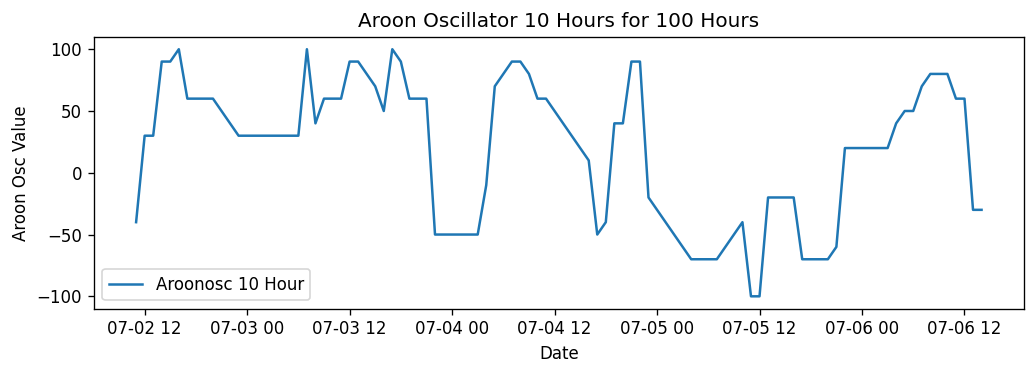

In [37]:
# Visualizing a single Aroon Oscillator for 100 hours

plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot(aroonosc_test_10[:100], label='Aroonosc 10 Hour')
plt.title('Aroon Oscillator 10 Hours for 100 Hours')
plt.xlabel('Date')
plt.ylabel('Aroon Osc Value')
plt.legend()

Length of Aroon Osc agent: 4379
Length of Buy-and-Hold: 4379
The final value with Buy-and-Hold is 1399.21
The final value with Aroonosc 10 is 1373.46
The final value with Aroonosc 12 is 975.8
The final value with Aroonosc 14 is 1029.37
The final value with Aroonosc 16 is 955.98
The final value with Aroonosc 18 is 1049.27
The final value with Aroonosc 20 is 942.16


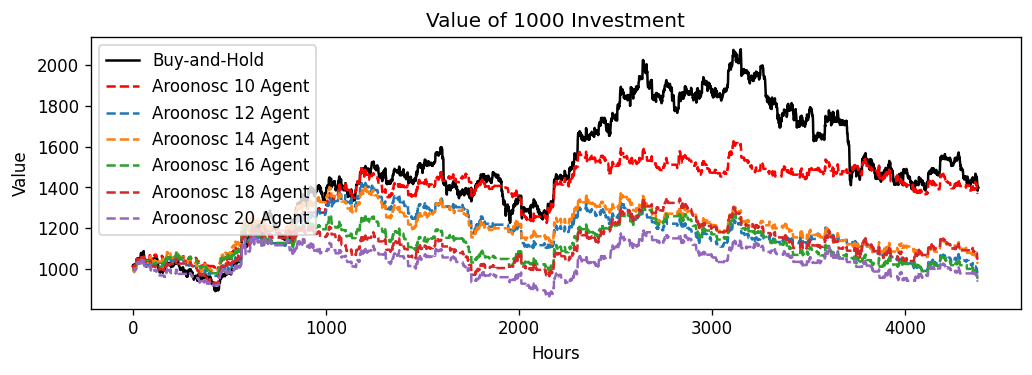

In [38]:
# Plotting

plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot(B_and_H[1:], label='Buy-and-Hold', color='black')
plt.plot(aroonosc_10_net_worths, label="Aroonosc 10 Agent", color='red', linestyle="--")
plt.plot(aroonosc_12_net_worths, label="Aroonosc 12 Agent", linestyle="--")
plt.plot(aroonosc_14_net_worths, label="Aroonosc 14 Agent", linestyle="--")
plt.plot(aroonosc_16_net_worths, label="Aroonosc 16 Agent", linestyle="--")
plt.plot(aroonosc_18_net_worths, label="Aroonosc 18 Agent", linestyle="--")
plt.plot(aroonosc_20_net_worths, label="Aroonosc 20 Agent", linestyle="--")
plt.xlabel('Hours')
plt.ylabel('Value')
plt.title('Value of 1000 Investment')
plt.legend()

print('Length of Aroon Osc agent:', len(aroonosc_10_net_worths))
print('Length of Buy-and-Hold:', len(B_and_H[1:]))

print('The final value with Buy-and-Hold is', round(B_and_H[-1],2))
print('The final value with Aroonosc 10 is', round(aroonosc_10_net_worths[1:][-1],2))
print('The final value with Aroonosc 12 is', round(aroonosc_12_net_worths[-1],2))
print('The final value with Aroonosc 14 is', round(aroonosc_14_net_worths[-1],2))
print('The final value with Aroonosc 16 is', round(aroonosc_16_net_worths[-1],2))
print('The final value with Aroonosc 18 is', round(aroonosc_18_net_worths[-1],2))
print('The final value with Aroonosc 20 is', round(aroonosc_20_net_worths[-1],2))

# Classical Statistical Forecasting and XGBoost

## ETS

In [57]:
# Load the ETS Model

model=statsmodels.tsa.statespace.exponential_smoothing.ExponentialSmoothingResults.load('Models/BTC 1H ETS.pkl')

In [58]:
# Forecasting

y_test=testing_close(dfs, 'hour')
forecast_length=len(y_test)
print('y_test head', y_test.head(),'\n', 'y_test tail', y_test.tail())

forecast=model.forecast(forecast_length)
print('\n')
print('forecast head',forecast.head(),'\n', 'forecast tail', forecast.tail())

y_test head Date
2021-07-02 11:00:00    33028.80
2021-07-02 12:00:00    33231.75
2021-07-02 13:00:00    33500.51
2021-07-02 14:00:00    33669.75
2021-07-02 15:00:00    33689.79
Freq: H, Name: Close, dtype: float64 
 y_test tail Date
2021-12-31 18:00:00    46648.83
2021-12-31 19:00:00    45703.05
2021-12-31 20:00:00    45876.39
2021-12-31 21:00:00    46329.19
2021-12-31 22:00:00    46322.70
Freq: H, Name: Close, dtype: float64


forecast head 2021-07-02 12:00:00    32965.307224
2021-07-02 13:00:00    33013.119289
2021-07-02 14:00:00    32992.467653
2021-07-02 15:00:00    33009.261255
2021-07-02 16:00:00    32989.287618
Freq: H, dtype: float64 
 forecast tail 2021-12-31 19:00:00    33014.147241
2021-12-31 20:00:00    33024.197150
2021-12-31 21:00:00    33057.701175
2021-12-31 22:00:00    33089.557292
2021-12-31 23:00:00    33128.654466
Freq: H, dtype: float64


We see that there is a difference of two times, 2021-7-02 11:00 and 2021-12-31 23:00. So, we need to push the y_test one ahead one hour and remove the last hour of the forecast

In [59]:
print('y test from the 1th index',y_test.iloc[1:])
print('\n')
print('forecast up to the last index',forecast.iloc[:-1])

y test from the 1th index Date
2021-07-02 12:00:00    33231.75
2021-07-02 13:00:00    33500.51
2021-07-02 14:00:00    33669.75
2021-07-02 15:00:00    33689.79
2021-07-02 16:00:00    33634.73
                         ...   
2021-12-31 18:00:00    46648.83
2021-12-31 19:00:00    45703.05
2021-12-31 20:00:00    45876.39
2021-12-31 21:00:00    46329.19
2021-12-31 22:00:00    46322.70
Freq: H, Name: Close, Length: 4379, dtype: float64


forecast up to the last index 2021-07-02 12:00:00    32965.307224
2021-07-02 13:00:00    33013.119289
2021-07-02 14:00:00    32992.467653
2021-07-02 15:00:00    33009.261255
2021-07-02 16:00:00    32989.287618
                           ...     
2021-12-31 18:00:00    32994.804122
2021-12-31 19:00:00    33014.147241
2021-12-31 20:00:00    33024.197150
2021-12-31 21:00:00    33057.701175
2021-12-31 22:00:00    33089.557292
Freq: H, Length: 4379, dtype: float64


We see that they match, so we will graph these two lists.

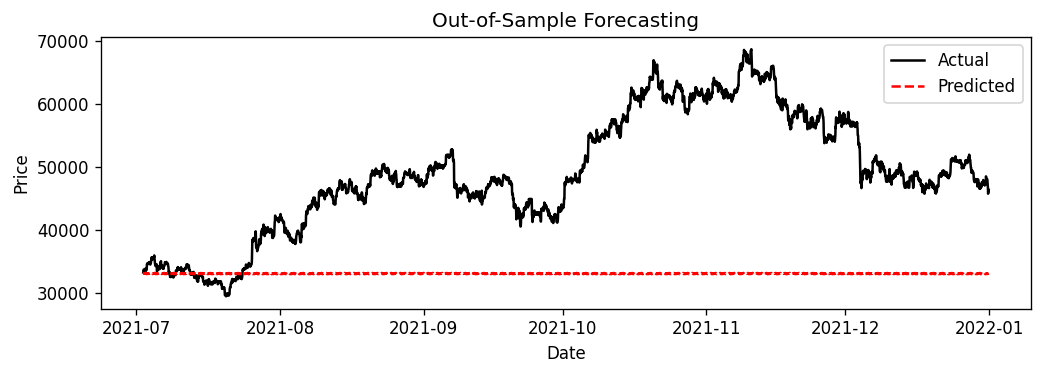

In [60]:
# Plotting

plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot(y_test[1:], label='Actual', color='black')
plt.plot(forecast[:-1], label="Predicted", color='red', linestyle="--")
plt.title('Out-of-Sample Forecasting')
plt.ylabel("Price")
plt.xlabel("Date")
plt.legend()

In [61]:
# Getting the actions from our forecast

# Getting the percent changes
y_hat=forecast.pct_change(1)
print('percent changes of y hat', y_hat)
y_hat=y_hat.values[1:] # We want each index to have information about the next time slice, so we move it back one, which 
# replaces the first nan value but removes the last value. We now running from 2021-07-02 12:00:00 
# to 2021-12-31 22:00:00
print('percent changes of y hat shifted back one', y_hat)

# Turning the percent changes into actions
actions=action_list(y_hat)
print('Length of our actions:',len(actions))

percent changes of y hat 2021-07-02 12:00:00         NaN
2021-07-02 13:00:00    0.001450
2021-07-02 14:00:00   -0.000626
2021-07-02 15:00:00    0.000509
2021-07-02 16:00:00   -0.000605
                         ...   
2021-12-31 19:00:00    0.000586
2021-12-31 20:00:00    0.000304
2021-12-31 21:00:00    0.001015
2021-12-31 22:00:00    0.000964
2021-12-31 23:00:00    0.001182
Freq: H, Length: 4380, dtype: float64
percent changes of y hat shifted back one [ 0.00145038 -0.00062556  0.00050901 ...  0.00101453  0.00096365
  0.00118156]
Length of our actions: 4379


We see that we have shifted each percent change back one, replacing the nan for 2021-07-02 12:00 and ending at 2021-12-31 22:00. 

In [62]:
# Getting agent's performance

_, test_pct_changes=testing_data_pct_changes(dfs, 'hour') # Getting the percent changes of our testing data
print('Length of test percent changes before modification:', len(test_pct_changes))
print('test percent changes', test_pct_changes)

test_pct_changes=test_pct_changes['2021-07-02 12:00:00':]
print('\n','After removing the first date', '\n')
print('test percent changes head', test_pct_changes)

test_pct_changes=test_pct_changes.values # Removing the last value and the indices
print('\n','Length of test percent changes after removing the first date:',len(test_pct_changes))
ETS_net_worths=Agent(actions, test_pct_changes, 1000)

# Accuracy
acc=accuracy(actions, test_pct_changes, 0)

print('The ETS accuracy is', round(acc,2))

Length of test percent changes before modification: 4380
test percent changes Date
2021-07-02 11:00:00    0.006145
2021-07-02 12:00:00    0.008087
2021-07-02 13:00:00    0.005052
2021-07-02 14:00:00    0.000595
2021-07-02 15:00:00   -0.001634
                         ...   
2021-12-31 18:00:00   -0.020274
2021-12-31 19:00:00    0.003793
2021-12-31 20:00:00    0.009870
2021-12-31 21:00:00   -0.000140
2021-12-31 22:00:00   -0.002339
Freq: H, Name: Percent Change, Length: 4380, dtype: float64

 After removing the first date 

test percent changes head Date
2021-07-02 12:00:00    0.008087
2021-07-02 13:00:00    0.005052
2021-07-02 14:00:00    0.000595
2021-07-02 15:00:00   -0.001634
2021-07-02 16:00:00   -0.004794
                         ...   
2021-12-31 18:00:00   -0.020274
2021-12-31 19:00:00    0.003793
2021-12-31 20:00:00    0.009870
2021-12-31 21:00:00   -0.000140
2021-12-31 22:00:00   -0.002339
Freq: H, Name: Percent Change, Length: 4379, dtype: float64

 Length of test percent cha

Recall that Buy-and-Hold runs from 2021-07-02 11:00:00 to 2021-12-31 22:00:00, but our ETS agent is only running from 2021-07-02 12:00:00 to 2021-12-31 22:00:00

Length of Buy-and-Hold after removing the first element: 4379
Length of our ETS agent's net worths: 4379
The final value with Buy-and-Hold is 1399.21
The final value with Exponential Smoothing is 1261.26


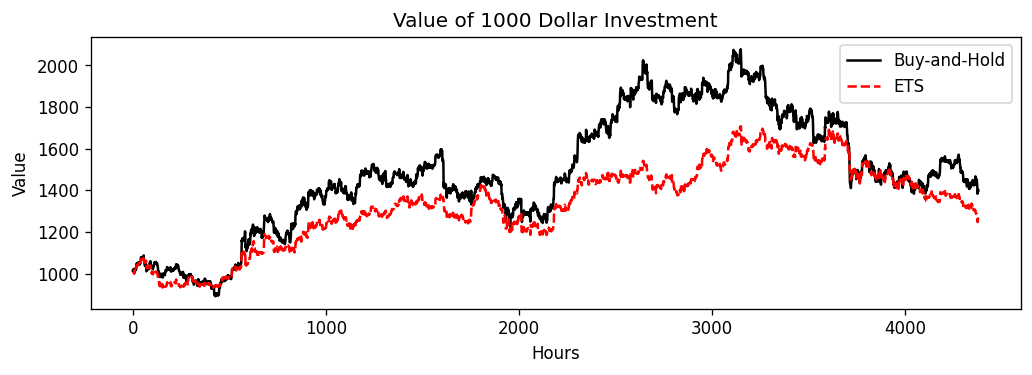

In [63]:
# Plotting 
print('Length of Buy-and-Hold after removing the first element:',len(B_and_H[1:]))
print("Length of our ETS agent's net worths:", len(ETS_net_worths))

plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.title('Value of '+str(init_balance)+' Dollar Investment')
plt.plot(B_and_H[1:], color='black', label='Buy-and-Hold')
plt.plot(ETS_net_worths, color='red', linestyle='--', label='ETS')
plt.xlabel('Hours')
plt.ylabel('Value')
plt.legend()

print('The final value with Buy-and-Hold is', round(B_and_H[-1],2))
print('The final value with Exponential Smoothing is', round(ETS_net_worths[-1],2))

## SARIMAX

In [19]:
# Importing the data

dfs=['Non-Scaled TA Features 1H for BTC.csv']

In [20]:
# Reload the model

model=SARIMAXResults.load('Models/BTC 1H SARIMAX.pkl')

In [21]:
# Reading in the data for initial visualization and analysis

X=pd.read_csv(dfs[0])
print('Confirming our full X matrix:',X.columns)
X['Date']=pd.to_datetime(X['Date']) # Setting the index as the Date
X=X.set_index('Date').asfreq('H')

six_month_date='2021-07-02 11:00:00'

y=X['Percent Change']

X=X.drop('Label', axis=1)
X=X.drop('Percent Change', axis=1)

print('Confirming we dropped the columns "Label" and "Percent Change"',X.columns)

# Removing the testing data
X_test=X[-4380:].astype('float32') # Getting the last 6 months as the testing data
print('Confirming we have all the columns we want:','\n', X_test.columns)
y_test=y[-4380:].astype('float32')

X=X[:-4380].astype('float32') # Getting everything but the first 6 months as the training data
y=y[:-4380].astype('float32')

X_train, X_test=PCA_creation_train_test(20, X, X_test)
y_train=y

Confirming our full X matrix: Index(['Date', 'BB_upper 10', 'BB_middle 10', 'BB_lower 10', 'Aroon_down 10',
       'Aroon_up 10', 'Aroonosc 10', 'RSI 10', 'NATR 10', 'BB_upper 12',
       ...
       'Med Price', 'Chaikin A/D Line', 'HT Dom Phase', 'HT Dom Period',
       'High', 'Low', 'Close', 'Volume', 'Label', 'Percent Change'],
      dtype='object', length=104)
Confirming we dropped the columns "Label" and "Percent Change" Index(['BB_upper 10', 'BB_middle 10', 'BB_lower 10', 'Aroon_down 10',
       'Aroon_up 10', 'Aroonosc 10', 'RSI 10', 'NATR 10', 'BB_upper 12',
       'BB_middle 12',
       ...
       'MACD Signal 18', 'MACD Hist18', 'Med Price', 'Chaikin A/D Line',
       'HT Dom Phase', 'HT Dom Period', 'High', 'Low', 'Close', 'Volume'],
      dtype='object', length=101)
Confirming we have all the columns we want: 
 Index(['BB_upper 10', 'BB_middle 10', 'BB_lower 10', 'Aroon_down 10',
       'Aroon_up 10', 'Aroonosc 10', 'RSI 10', 'NATR 10', 'BB_upper 12',
       'BB_middle 12'

In [22]:
result = model.predict(start=len(X), end=len(X)+len(X_test)-1, exog=X_test.astype(float))

In [23]:
# Inspecting the datas so we know everything lines up

print('Results:', result)
print('y test:',y_test)

Results: 2021-07-02 11:00:00   -0.037588
2021-07-02 12:00:00    0.024705
2021-07-02 13:00:00    0.079064
2021-07-02 14:00:00    0.036817
2021-07-02 15:00:00    0.073711
                         ...   
2021-12-31 18:00:00   -0.133518
2021-12-31 19:00:00   -0.166972
2021-12-31 20:00:00   -0.163932
2021-12-31 21:00:00   -0.138981
2021-12-31 22:00:00   -0.138101
Freq: H, Name: predicted_mean, Length: 4380, dtype: float64
y test: Date
2021-07-02 11:00:00    0.614464
2021-07-02 12:00:00    0.808745
2021-07-02 13:00:00    0.505186
2021-07-02 14:00:00    0.059519
2021-07-02 15:00:00   -0.163432
                         ...   
2021-12-31 18:00:00   -2.027446
2021-12-31 19:00:00    0.379274
2021-12-31 20:00:00    0.987000
2021-12-31 21:00:00   -0.014008
2021-12-31 22:00:00   -0.233859
Freq: H, Name: Percent Change, Length: 4380, dtype: float32


We see that our results start at 2021-07-02 11:00:00 and end at 2021-12-31 22:00:00, same as y_test

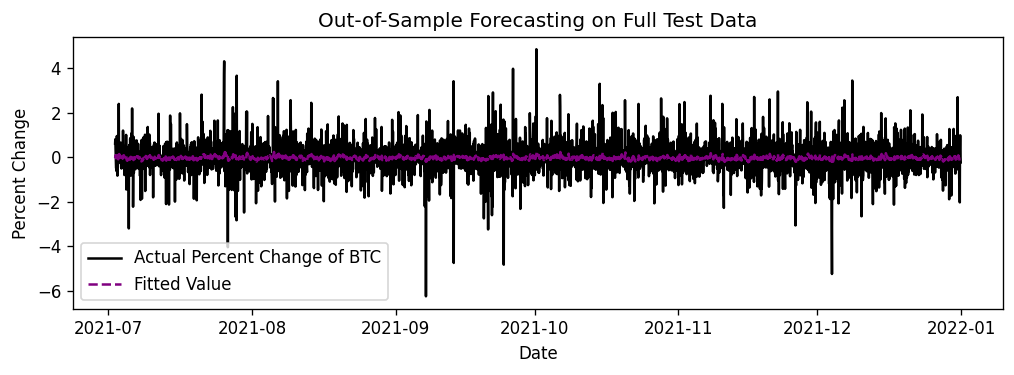

In [24]:
plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot(y_test, label='Actual Percent Change of BTC', color='black')
plt.plot(result, label='Fitted Value', color='purple', linestyle='--')
plt.title('Out-of-Sample Forecasting on Full Test Data')
plt.xlabel('Date')
plt.ylabel('Percent Change')
plt.legend()

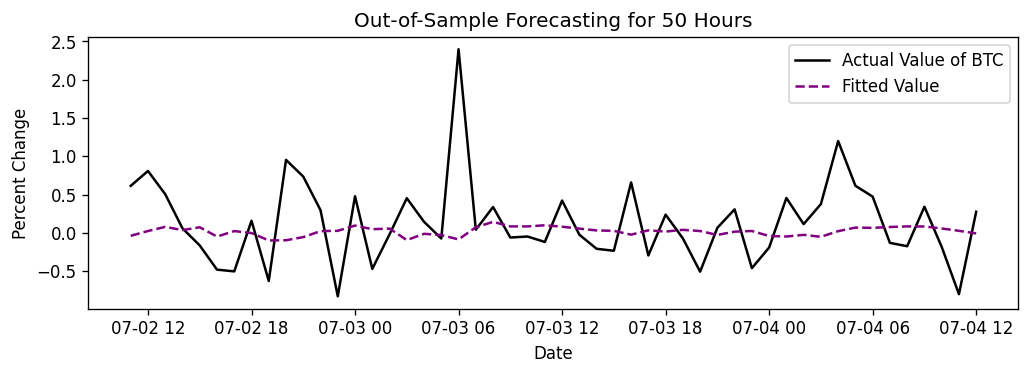

In [25]:
plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot(y_test[0:50], label='Actual Value of BTC', color='black')
plt.plot(result[0:50], label='Fitted Value', color='purple', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Percent Change')
plt.title('Out-of-Sample Forecasting for 50 Hours')
plt.legend()

In [26]:
# Getting actions and accuracy

# Actions
result=result.values
y_test=y_test.values
actions=action_list(result)

# Accuracy
acc=accuracy(actions, y_test, 0)

print('The accuracy for SARMAX is', round(acc,2))

The accuracy for SARMAX is 47.37


In [27]:
# Getting the net worth

init_balance=1000
test_pct_changes=y_test/100
SARMAX_net_worths=Agent(actions, test_pct_changes, 1000)
print('The length of our SARMAX net worths is:',len(SARMAX_net_worths))

The length of our SARMAX net worths is: 4380


The length of Buy-and-Hold is: 4380
The final value with Buy-and-Hold is 1399.21
The final value with SARIMAX is 1051.14


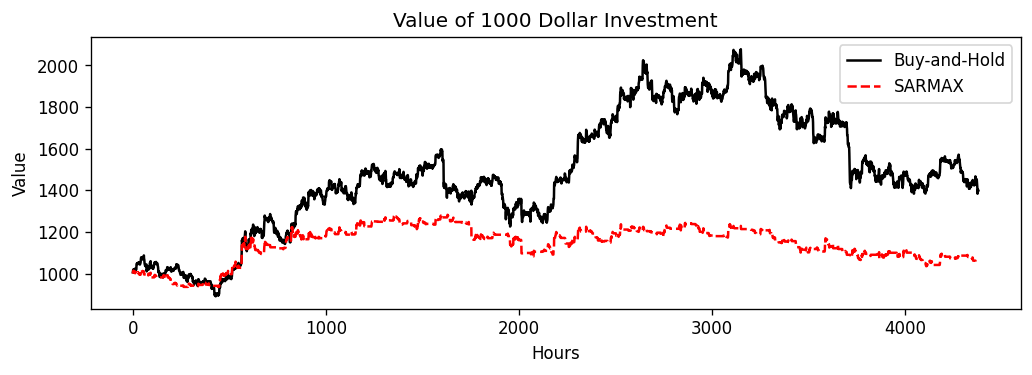

In [28]:
plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.title('Value of '+str(init_balance)+' Dollar Investment')
plt.plot(B_and_H, color='black', label='Buy-and-Hold')
plt.plot(SARMAX_net_worths, color='red', linestyle='--', label='SARMAX')
plt.xlabel('Hours')
plt.ylabel('Value')
plt.legend()

print('The length of Buy-and-Hold is:', len(B_and_H))
print('The final value with Buy-and-Hold is', round(B_and_H[-1],2))
print('The final value with SARIMAX is', round(SARMAX_net_worths[-1],2))

## XGBoost

In [94]:
# Importing the data

dfs=['Non-Scaled TA Features 1H for BTC.csv']

In [95]:
# Train and test splitting and scaling

X=pd.read_csv(dfs[0])

X['Date']=pd.to_datetime(X['Date']) # Setting the index as the Date
X=X.set_index('Date').asfreq('H')

X=X.dropna()
y=X['Label']
X=X.drop('Label', axis=1)
X=X.drop('Percent Change', axis=1)


# Removing the testing data
X_test=X[-4380:] # Getting the last 6 months as the testing data
print(X_test.columns)
y_test=y[-4380:].values

X=X[:-4380] # Getting everything but the first 6 months as the training data
y=y[:-4380]

num_classes=2 # Used for one-hot encoding, but we won't be doing that with 2 classes

# Split into training and validation for our neural net
X_train, X_val, y_train, y_val=train_test_split(X, y, test_size=0.2, random_state=100, shuffle=True)
y_train=np.array(y_train)
y_val=np.array(y_val)

X_train, X_val, X_test=PCA_creation_train_val_test(20, X_train, X_val, X_test)

Index(['BB_upper 10', 'BB_middle 10', 'BB_lower 10', 'Aroon_down 10',
       'Aroon_up 10', 'Aroonosc 10', 'RSI 10', 'NATR 10', 'BB_upper 12',
       'BB_middle 12',
       ...
       'MACD Signal 18', 'MACD Hist18', 'Med Price', 'Chaikin A/D Line',
       'HT Dom Phase', 'HT Dom Period', 'High', 'Low', 'Close', 'Volume'],
      dtype='object', length=101)


In [96]:
# Loading the model
model = xgb.XGBClassifier()
model.load_model("Models/XGB BTC.txt")
print(model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=1, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=10, scale_pos_weight=1, subsample=1,
              tree_method='auto', validate_parameters=1, verbosity=0)


In [97]:
acc1, net_worths1, cm1 = investing_performance_xgb(model, y_test, 0, 'None')

The lengths of the actions and y test are the same.


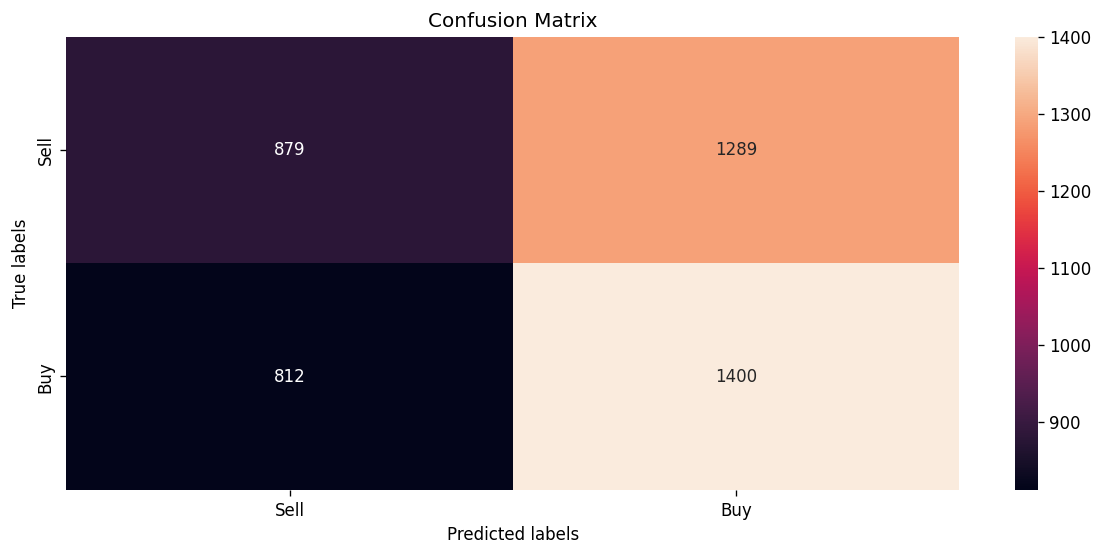

In [98]:
ax= plt.subplot()
sns.heatmap(cm1, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Sell', 'Buy']); ax.yaxis.set_ticklabels(['Sell', 'Buy']);

Length of Buy-and-Hold 4380
Length of our XGBoost net worths: 4380
The accuracy of XGBoost is 52.0
The final value with Buy-and-Hold is 1399.21
The final value with XGBoost is 1009.89


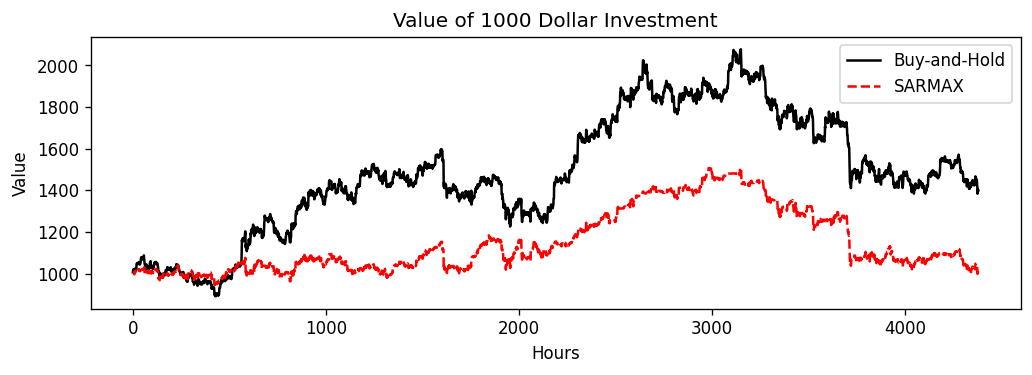

In [99]:
plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.title('Value of '+str(init_balance)+' Dollar Investment')
plt.plot(B_and_H, color='black', label='Buy-and-Hold')
plt.plot(net_worths1, color='red', linestyle='--', label='SARMAX')
plt.xlabel('Hours')
plt.ylabel('Value')
plt.legend()
print('Length of Buy-and-Hold', len(B_and_H))
print('Length of our XGBoost net worths:',len(net_worths1))

print('The accuracy of XGBoost is', acc1)
print('The final value with Buy-and-Hold is', round(B_and_H[-1],2))
print('The final value with XGBoost is', round(net_worths1[-1],2))

# Artifical Neural Networks

## Multi-Layer Perceptron

In [20]:
# Importing the data

dfs=['Non-Scaled TA Features 1H for BTC.csv']

In [21]:
# Train and test splitting and scaling

X=pd.read_csv(dfs[0])

X['Date']=pd.to_datetime(X['Date']) # Setting the index as the Date
X=X.set_index('Date').asfreq('H')

X=X.dropna()
y=X['Label']
X=X.drop('Label', axis=1)
X=X.drop('Percent Change', axis=1)


# Removing the testing data
X_test=X[-4380:] # Getting the last 6 months as the testing data
print('Confirming we have all the columns we want:','\n', X_test.columns)
y_test=y[-4380:].values

X=X[:-4380] # Getting everything but the first 6 months as the training data
y=y[:-4380]

num_classes=2 # Used for one-hot encoding, but we won't be doing that with 2 classes

# Split into training and validation for our neural net
X_train, X_val, y_train, y_val=train_test_split(X, y, test_size=0.2, random_state=100, shuffle=True)
y_train=np.array(y_train)
y_val=np.array(y_val)

X_train, X_val, X_test=PCA_creation_train_val_test(20, X_train, X_val, X_test)

Confirming we have all the columns we want: 
 Index(['BB_upper 10', 'BB_middle 10', 'BB_lower 10', 'Aroon_down 10',
       'Aroon_up 10', 'Aroonosc 10', 'RSI 10', 'NATR 10', 'BB_upper 12',
       'BB_middle 12',
       ...
       'MACD Signal 18', 'MACD Hist18', 'Med Price', 'Chaikin A/D Line',
       'HT Dom Phase', 'HT Dom Period', 'High', 'Low', 'Close', 'Volume'],
      dtype='object', length=101)


In [83]:
acc1, net_worths1, cm1 = investing_performance('Models/MLP 1 BTC.h5', y_test, 0, 'None')
acc2, net_worths2, cm2 = investing_performance('Models/MLP 2 BTC.h5', y_test, 0, 'None')
acc3, net_worths3, cm3 = investing_performance('Models/MLP 3 BTC.h5', y_test, 0, 'None')
acc4, net_worths4, cm4 = investing_performance('Models/MLP 4 BTC.h5', y_test, 0, 'None')

The lengths of the actions and y test are the same.
The lengths of the test pct changes and actions are the same.
The lengths of the actions and y test are the same.
The lengths of the test pct changes and actions are the same.
The lengths of the actions and y test are the same.
The lengths of the test pct changes and actions are the same.
The lengths of the actions and y test are the same.
The lengths of the test pct changes and actions are the same.


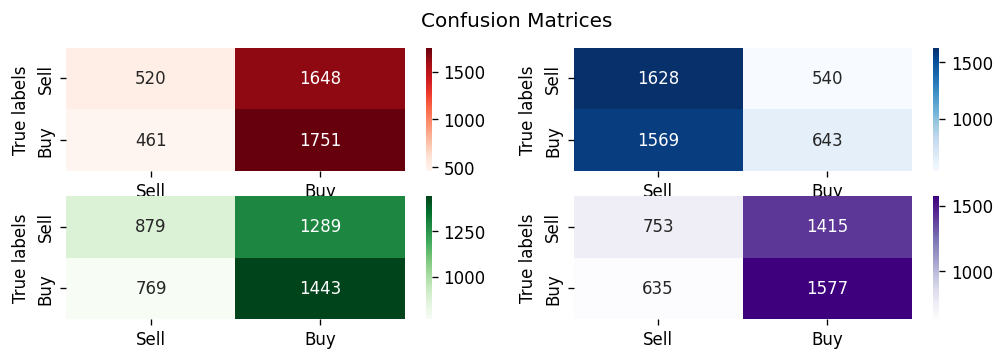

In [84]:
cms=[cm1, cm2, cm3, cm4]
confusion_matrices_4_by_4(cms)

The lengths of Buy-and-Hold and the agents are the same.
The lengths of the net worths and the Buy-and-Hold startegies are 4380 4380 4380 4380 4380
The final value with Buy-and-Hold is 1399.21
Our accuracies and final values for these models are: 
 52.0 percent and 1282.51 dollars, 
 52.0 percent and 1082.19 dollars, 
 53.0 percent and 1159.06 dollars, 
 53.0 percent and 1266.32 dollars.


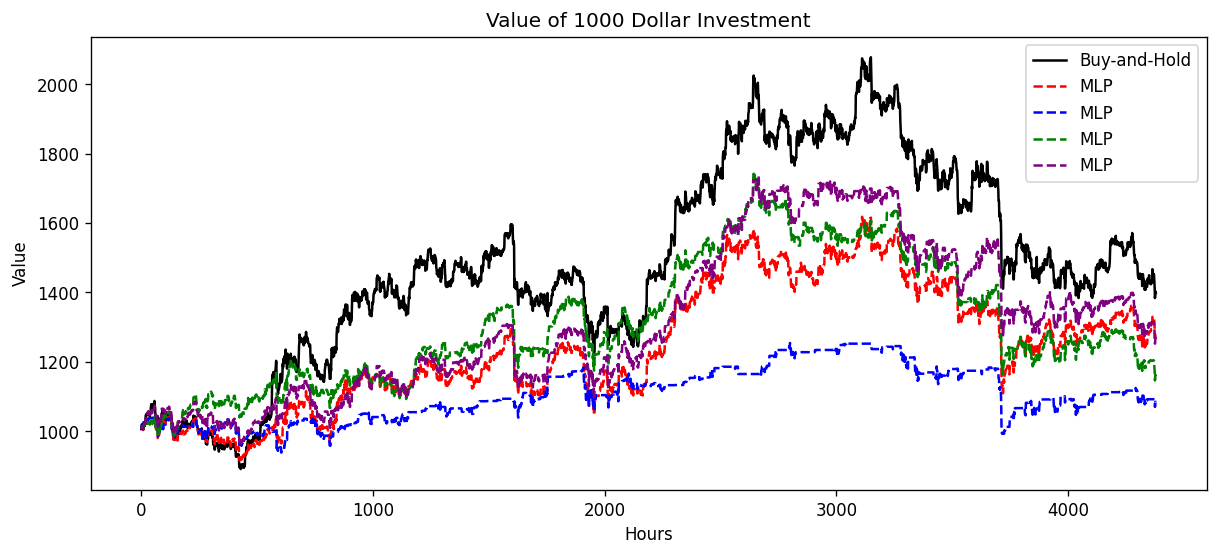

In [85]:
agents_net_worths=[net_worths1, net_worths2, net_worths3, net_worths4]
portfolio_movement_5_agents(agents_net_worths, B_and_H, 'MLP', 0, 'None')
print('Our accuracies and final values for these models are:',
      '\n',
      acc1, 'percent and', round(net_worths1[-1],2), 'dollars,',
      '\n',
      acc2, 'percent and', round(net_worths2[-1],2), 'dollars,',
      '\n',
      acc3, 'percent and', round(net_worths3[-1],2), 'dollars,',
      '\n',
      acc4, 'percent and', round(net_worths4[-1],2), 'dollars.')

## CNN

### 12 Hour "Images"

In [22]:
# Importing the data

dfs=['Non-Scaled TA Features 1H for BTC.csv']

In [23]:
# Train and test splitting and scaling
X=pd.read_csv(dfs[0])

X['Date']=pd.to_datetime(X['Date']) # Setting the index as the Date
X=X.set_index('Date').asfreq('H')

X=X.dropna()
y=X['Label']
X=X.drop('Label', axis=1)
X=X.drop('Percent Change', axis=1)


# Removing the testing data
X_test=X[-4380:] # Getting the last 6 months as the testing data
print('Confirming we have all the columns we want:','\n', X_test.columns)
y_test=y[-4380:].values

X=X[:-4380] # Getting everything but the first 6 months as the training data
y=y[:-4380]

Confirming we have all the columns we want: 
 Index(['BB_upper 10', 'BB_middle 10', 'BB_lower 10', 'Aroon_down 10',
       'Aroon_up 10', 'Aroonosc 10', 'RSI 10', 'NATR 10', 'BB_upper 12',
       'BB_middle 12',
       ...
       'MACD Signal 18', 'MACD Hist18', 'Med Price', 'Chaikin A/D Line',
       'HT Dom Phase', 'HT Dom Period', 'High', 'Low', 'Close', 'Volume'],
      dtype='object', length=101)


In [89]:
# Image creation function

def image_creation(n_steps, X, y):
    X_images=[]
    y_values=[]
    
    for i in range(n_steps, len(X)):
        img=X[i-n_steps,:]
        img=np.vstack((img, X[i-n_steps+1,:]))
        img=np.vstack((img, X[i-n_steps+2,:]))
        img=np.vstack((img, X[i-n_steps+3,:]))
        img=np.vstack((img, X[i-n_steps+4,:]))
        img=np.vstack((img, X[i-n_steps+5,:]))
        img=np.vstack((img, X[i-n_steps+6,:]))
        img=np.vstack((img, X[i-n_steps+7,:]))
        img=np.vstack((img, X[i-n_steps+8,:]))
        img=np.vstack((img, X[i-n_steps+9,:]))
        img=np.vstack((img, X[i-n_steps+10,:]))
        img=np.vstack((img, X[i-n_steps+11,:]))
        X_images.append(img)
        y_values.append(int(y[i-n_steps+11]))
        
    return X_images, np.array(y_values) # Note, this will not include the very last one.

In [90]:
n_steps=12

# First, we create our PCA matrices from the X and X_test
X, X_test=PCA_creation_train_test(20, X, X_test)
    
# Getting the X and X_test matrices' images
X_set, y_set=image_creation(n_steps, X ,y)
X_test, y_test=image_creation(n_steps, X_test, y_test)


# Split X into training and validation for our neural net
X_train, X_val, y_train, y_val=train_test_split(X_set, y_set, test_size=0.2, random_state=100, shuffle=True)
# Note, we have already made our images from sequential time slices, so we can shuffle our sets of images

y_train=np.array(y_train)
y_val=np.array(y_val)
y_test=np.array(y_test)

# Finalizing the shapes
num_classes = 2
input_shape = (n_steps, len(X[0]), 1)

# Add a dimension at the end to make sure images have shape (n_steps, n_features, 1)
X_train = np.expand_dims(X_train, -1)
X_val = np.expand_dims(X_val, -1)
X_test = np.expand_dims(X_test, -1)
print("X_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_val.shape[0], "val samples")
print(X_test.shape[0], "test samples")

X_train shape: (21011, 12, 20, 1)
21011 train samples
5253 val samples
4368 test samples


In [91]:
acc1, net_worths1, cm1 = investing_performance('Models/CNN 12_1 BTC.h5', y_test, 11, -1)
acc2, net_worths2, cm2 = investing_performance('Models/CNN 12_2 BTC.h5', y_test, 11, -1)
acc3, net_worths3, cm3 = investing_performance('Models/CNN 12_3 BTC.h5', y_test, 11, -1)
acc4, net_worths4, cm4 = investing_performance('Models/CNN 12_4 BTC.h5', y_test, 11, -1)

The lengths of the actions and y test are the same.
The lengths of the test pct changes and actions are the same.
The lengths of the actions and y test are the same.
The lengths of the test pct changes and actions are the same.
The lengths of the actions and y test are the same.
The lengths of the test pct changes and actions are the same.
The lengths of the actions and y test are the same.
The lengths of the test pct changes and actions are the same.


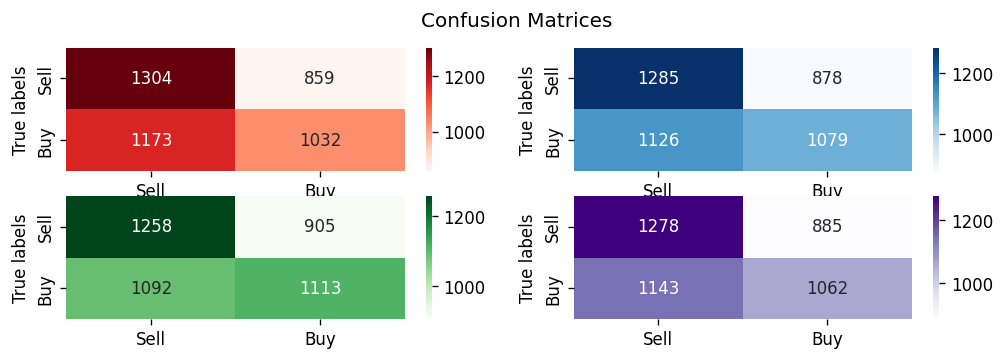

In [92]:
cms=[cm1, cm2, cm3, cm4]
confusion_matrices_4_by_4(cms)

The lengths of Buy-and-Hold and the agents are the same.
The lengths of the net worths and the Buy-and-Hold startegies are 4368 4368 4368 4368 4368
The final value with Buy-and-Hold is 1402.49
Our accuracies and final values for these models are: 
 53.0 percent and 1268.99 dollars, 
 54.0 percent and 1518.36 dollars, 
 54.0 percent and 1605.3 dollars, 
 54.0 percent and 1448.82 dollars.


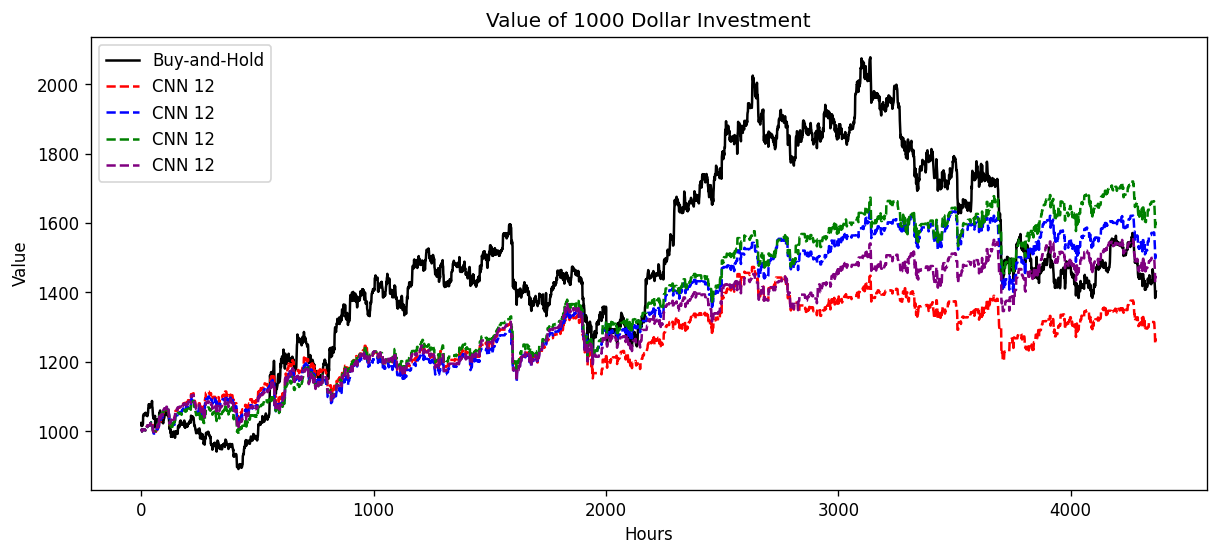

In [93]:
agents_net_worths=[net_worths1, net_worths2, net_worths3, net_worths4]
portfolio_movement_5_agents(agents_net_worths, B_and_H, 'CNN 12', 11, -1)
print('Our accuracies and final values for these models are:',
      '\n',
      acc1, 'percent and', round(net_worths1[-1],2), 'dollars,',
      '\n',
      acc2, 'percent and', round(net_worths2[-1],2), 'dollars,',
      '\n',
      acc3, 'percent and', round(net_worths3[-1],2), 'dollars,',
      '\n',
      acc4, 'percent and', round(net_worths4[-1],2), 'dollars.')

### 18 Hour "Images"

In [24]:
# Importing the data

dfs=['Non-Scaled TA Features 1H for BTC.csv']

In [25]:
# Train and test splitting and scaling
X=pd.read_csv(dfs[0])

X['Date']=pd.to_datetime(X['Date']) # Setting the index as the Date
X=X.set_index('Date').asfreq('H')

X=X.dropna()
y=X['Label']
X=X.drop('Label', axis=1)
X=X.drop('Percent Change', axis=1)


# Removing the testing data
X_test=X[-4380:] # Getting the last 6 months as the testing data
print('Confirming we have all the columns we want:','\n', X_test.columns)
y_test=y[-4380:].values

X=X[:-4380] # Getting everything but the first 6 months as the training data
y=y[:-4380]

Confirming we have all the columns we want: 
 Index(['BB_upper 10', 'BB_middle 10', 'BB_lower 10', 'Aroon_down 10',
       'Aroon_up 10', 'Aroonosc 10', 'RSI 10', 'NATR 10', 'BB_upper 12',
       'BB_middle 12',
       ...
       'MACD Signal 18', 'MACD Hist18', 'Med Price', 'Chaikin A/D Line',
       'HT Dom Phase', 'HT Dom Period', 'High', 'Low', 'Close', 'Volume'],
      dtype='object', length=101)


In [72]:
# Image creation function

def image_creation(n_steps, X, y):
    X_images=[]
    y_values=[]
    
    for i in range(n_steps, len(X)):
        img=X[i-n_steps,:]
        img=np.vstack((img, X[i-n_steps+1,:]))
        img=np.vstack((img, X[i-n_steps+2,:]))
        img=np.vstack((img, X[i-n_steps+3,:]))
        img=np.vstack((img, X[i-n_steps+4,:]))
        img=np.vstack((img, X[i-n_steps+5,:]))
        img=np.vstack((img, X[i-n_steps+6,:]))
        img=np.vstack((img, X[i-n_steps+7,:]))
        img=np.vstack((img, X[i-n_steps+8,:]))
        img=np.vstack((img, X[i-n_steps+9,:]))
        img=np.vstack((img, X[i-n_steps+10,:]))
        img=np.vstack((img, X[i-n_steps+11,:]))
        img=np.vstack((img, X[i-n_steps+12,:]))
        img=np.vstack((img, X[i-n_steps+13,:]))
        img=np.vstack((img, X[i-n_steps+14,:]))
        img=np.vstack((img, X[i-n_steps+15,:]))
        img=np.vstack((img, X[i-n_steps+16,:]))
        img=np.vstack((img, X[i-n_steps+17,:]))
        X_images.append(img)
        y_values.append(int(y[i-n_steps+17]))
        
    return X_images, np.array(y_values) # Note, this will not include the very last one.

In [73]:
n_steps=18

# First, we create our PCA matrices from the X and X_test
X, X_test=PCA_creation_train_test(20, X, X_test)
    
# Getting the X and X_test matrices' images
X_set, y_set=image_creation(n_steps, X ,y)
X_test, y_test=image_creation(n_steps, X_test, y_test)


# Split X into training and validation for our neural net
X_train, X_val, y_train, y_val=train_test_split(X_set, y_set, test_size=0.2, random_state=100, shuffle=True)
# Note, we have already made our images from sequential time slices, so we can shuffle our sets of images

y_train=np.array(y_train)
y_val=np.array(y_val)
y_test=np.array(y_test)

# Finalizing the shapes
num_classes = 2
input_shape = (n_steps, len(X[0]), 1)

# Add a dimension at the end to make sure images have shape (n_steps, n_features, 1)
X_train = np.expand_dims(X_train, -1)
X_val = np.expand_dims(X_val, -1)
X_test = np.expand_dims(X_test, -1)
print("X_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_val.shape[0], "val samples")
print(X_test.shape[0], "test samples")

X_train shape: (21006, 18, 20, 1)
21006 train samples
5252 val samples
4362 test samples


In [74]:
acc1, net_worths1, cm1 = investing_performance('Models/CNN 18_1 BTC.h5', y_test, 17, -1)
acc2, net_worths2, cm2 = investing_performance('Models/CNN 18_2 BTC.h5', y_test, 17, -1)
acc3, net_worths3, cm3 = investing_performance('Models/CNN 18_3 BTC.h5', y_test, 17, -1)
acc4, net_worths4, cm4 = investing_performance('Models/CNN 18_4 BTC.h5', y_test, 17, -1)

The lengths of the actions and y test are the same.
The lengths of the test pct changes and actions are the same.
The lengths of the actions and y test are the same.
The lengths of the test pct changes and actions are the same.
The lengths of the actions and y test are the same.
The lengths of the test pct changes and actions are the same.
The lengths of the actions and y test are the same.
The lengths of the test pct changes and actions are the same.


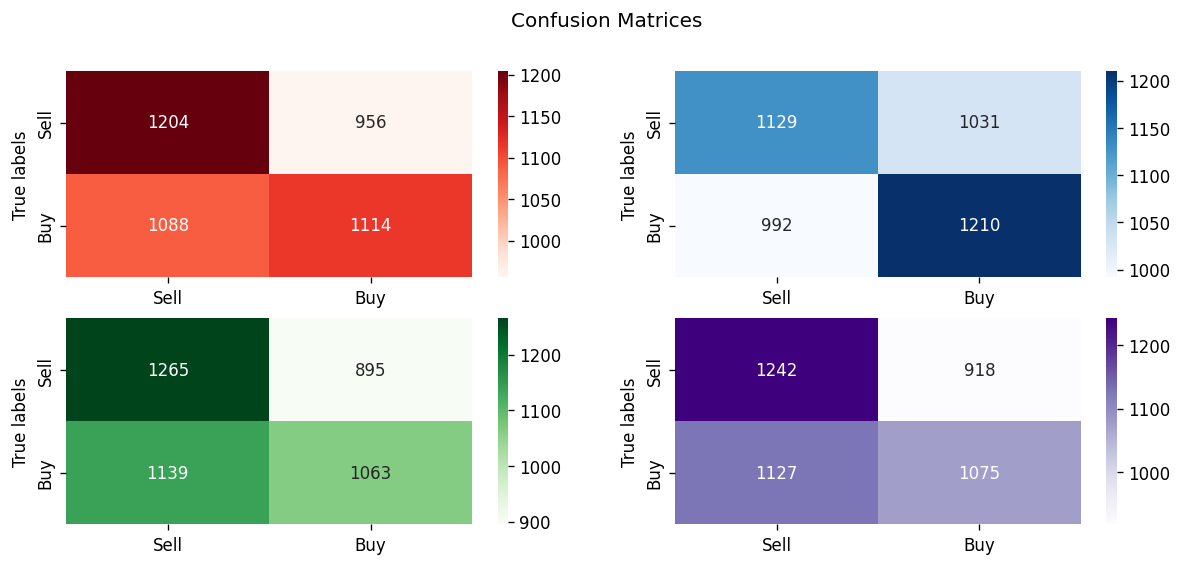

In [75]:
cms=[cm1, cm2, cm3, cm4]
confusion_matrices_4_by_4(cms)

The lengths of Buy-and-Hold and the agents are the same.
The lengths of the net worths and the Buy-and-Hold startegies are 4362 4362 4362 4362 4362
The final value with Buy-and-Hold is 1402.49
Our accuracies and final values for these models are: 
 53.0 percent and 1266.6 dollars, 
 54.0 percent and 1553.55 dollars, 
 53.0 percent and 1271.88 dollars, 
 53.0 percent and 1234.28 dollars.


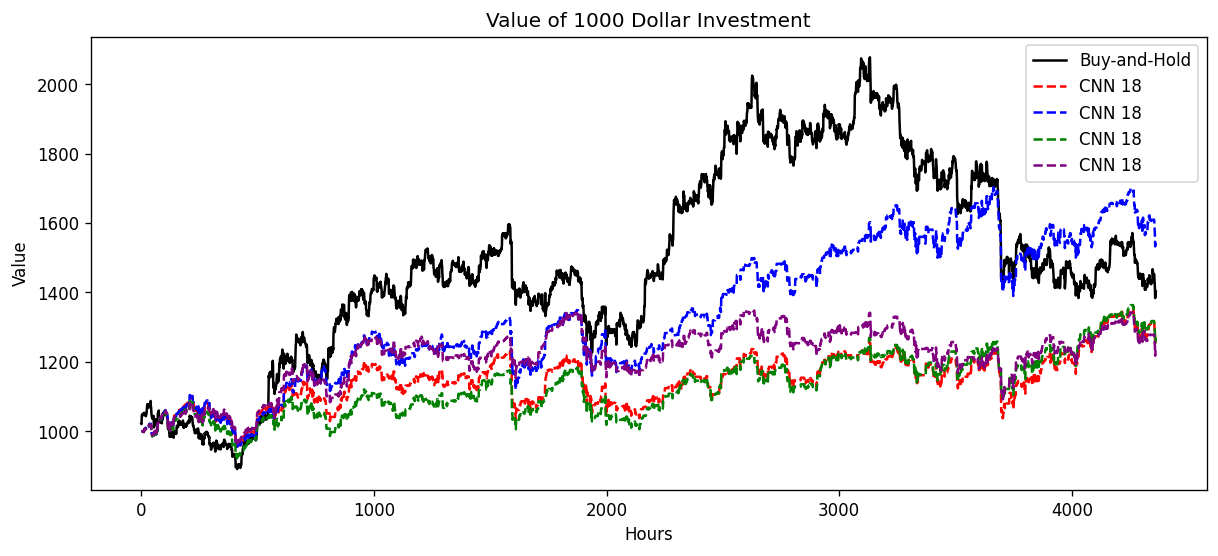

In [76]:
agents_net_worths=[net_worths1, net_worths2, net_worths3, net_worths4]
portfolio_movement_5_agents(agents_net_worths, B_and_H, 'CNN 18', 17, -1)
print('Our accuracies and final values for these models are:',
      '\n',
      acc1, 'percent and', round(net_worths1[-1],2), 'dollars,',
      '\n',
      acc2, 'percent and', round(net_worths2[-1],2), 'dollars,',
      '\n',
      acc3, 'percent and', round(net_worths3[-1],2), 'dollars,',
      '\n',
      acc4, 'percent and', round(net_worths4[-1],2), 'dollars.')

### 24 Hour "Images"

In [26]:
# Importing the data

dfs=['Non-Scaled TA Features 1H for BTC.csv']

In [27]:
# Train and test splitting and scaling
X=pd.read_csv(dfs[0])

X['Date']=pd.to_datetime(X['Date']) # Setting the index as the Date
X=X.set_index('Date').asfreq('H')

X=X.dropna()
y=X['Label']
X=X.drop('Label', axis=1)
X=X.drop('Percent Change', axis=1)


# Removing the testing data
X_test=X[-4380:] # Getting the last 6 months as the testing data
print('Confirming we have all the columns we want:','\n', X_test.columns)
y_test=y[-4380:].values

X=X[:-4380] # Getting everything but the first 6 months as the training data
y=y[:-4380]

Confirming we have all the columns we want: 
 Index(['BB_upper 10', 'BB_middle 10', 'BB_lower 10', 'Aroon_down 10',
       'Aroon_up 10', 'Aroonosc 10', 'RSI 10', 'NATR 10', 'BB_upper 12',
       'BB_middle 12',
       ...
       'MACD Signal 18', 'MACD Hist18', 'Med Price', 'Chaikin A/D Line',
       'HT Dom Phase', 'HT Dom Period', 'High', 'Low', 'Close', 'Volume'],
      dtype='object', length=101)


In [79]:
# Image creation function

def image_creation(n_steps, X, y):
    X_images=[]
    y_values=[]
    
    for i in range(n_steps, len(X)):
        img=X[i-n_steps,:]
        img=np.vstack((img, X[i-n_steps+1,:]))
        img=np.vstack((img, X[i-n_steps+2,:]))
        img=np.vstack((img, X[i-n_steps+3,:]))
        img=np.vstack((img, X[i-n_steps+4,:]))
        img=np.vstack((img, X[i-n_steps+5,:]))
        img=np.vstack((img, X[i-n_steps+6,:]))
        img=np.vstack((img, X[i-n_steps+7,:]))
        img=np.vstack((img, X[i-n_steps+8,:]))
        img=np.vstack((img, X[i-n_steps+9,:]))
        img=np.vstack((img, X[i-n_steps+10,:]))
        img=np.vstack((img, X[i-n_steps+11,:]))
        img=np.vstack((img, X[i-n_steps+12,:]))
        img=np.vstack((img, X[i-n_steps+13,:]))
        img=np.vstack((img, X[i-n_steps+14,:]))
        img=np.vstack((img, X[i-n_steps+15,:]))
        img=np.vstack((img, X[i-n_steps+16,:]))
        img=np.vstack((img, X[i-n_steps+17,:]))
        img=np.vstack((img, X[i-n_steps+18,:]))
        img=np.vstack((img, X[i-n_steps+19,:]))
        img=np.vstack((img, X[i-n_steps+20,:]))
        img=np.vstack((img, X[i-n_steps+21,:]))
        img=np.vstack((img, X[i-n_steps+22,:]))
        img=np.vstack((img, X[i-n_steps+23,:]))
        X_images.append(img)
        y_values.append(int(y[i-n_steps+23]))
        
    return X_images, np.array(y_values) # Note, this will not include the very last one.

In [80]:
n_steps=24

# First, we create our PCA matrices from the X and X_test
X, X_test=PCA_creation_train_test(20, X, X_test)
    
# Getting the X and X_test matrices' images
X_set, y_set=image_creation(n_steps, X ,y)
X_test, y_test=image_creation(n_steps, X_test, y_test)


# Split X into training and validation for our neural net
X_train, X_val, y_train, y_val=train_test_split(X_set, y_set, test_size=0.2, random_state=100, shuffle=True)
# Note, we have already made our images from sequential time slices, so we can shuffle our sets of images

y_train=np.array(y_train)
y_val=np.array(y_val)
y_test=np.array(y_test)

# Finalizing the shapes
num_classes = 2
input_shape = (n_steps, len(X[0]), 1)

# Add a dimension at the end to make sure images have shape (n_steps, n_features, 1)
X_train = np.expand_dims(X_train, -1)
X_val = np.expand_dims(X_val, -1)
X_test = np.expand_dims(X_test, -1)
print("X_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_val.shape[0], "val samples")
print(X_test.shape[0], "test samples")

X_train shape: (21001, 24, 20, 1)
21001 train samples
5251 val samples
4356 test samples


In [81]:
acc1, net_worths1, cm1 = investing_performance('Models/CNN 24_1 BTC.h5', y_test, 23, -1)
acc2, net_worths2, cm2 = investing_performance('Models/CNN 24_2 BTC.h5', y_test, 23, -1)
acc3, net_worths3, cm3 = investing_performance('Models/CNN 24_3 BTC.h5', y_test, 23, -1)
acc4, net_worths4, cm4 = investing_performance('Models/CNN 24_4 BTC.h5', y_test, 23, -1)

The lengths of the actions and y test are the same.
The lengths of the test pct changes and actions are the same.
The lengths of the actions and y test are the same.
The lengths of the test pct changes and actions are the same.
The lengths of the actions and y test are the same.
The lengths of the test pct changes and actions are the same.
The lengths of the actions and y test are the same.
The lengths of the test pct changes and actions are the same.


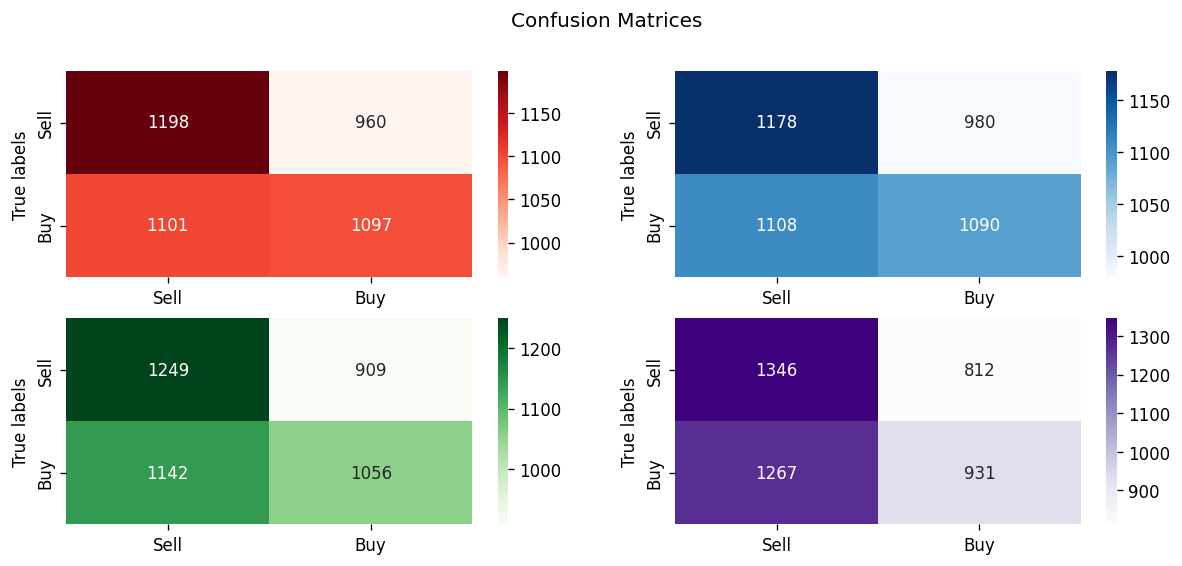

In [82]:
cms=[cm1, cm2, cm3, cm4]
confusion_matrices_4_by_4(cms)

The lengths of Buy-and-Hold and the agents are the same.
The lengths of the net worths and the Buy-and-Hold startegies are 4356 4356 4356 4356 4356
The final value with Buy-and-Hold is 1402.49
Our accuracies and final values for these models are: 
 53.0 percent and 982.91 dollars, 
 52.0 percent and 968.54 dollars, 
 53.0 percent and 1043.2 dollars, 
 52.0 percent and 940.81 dollars.


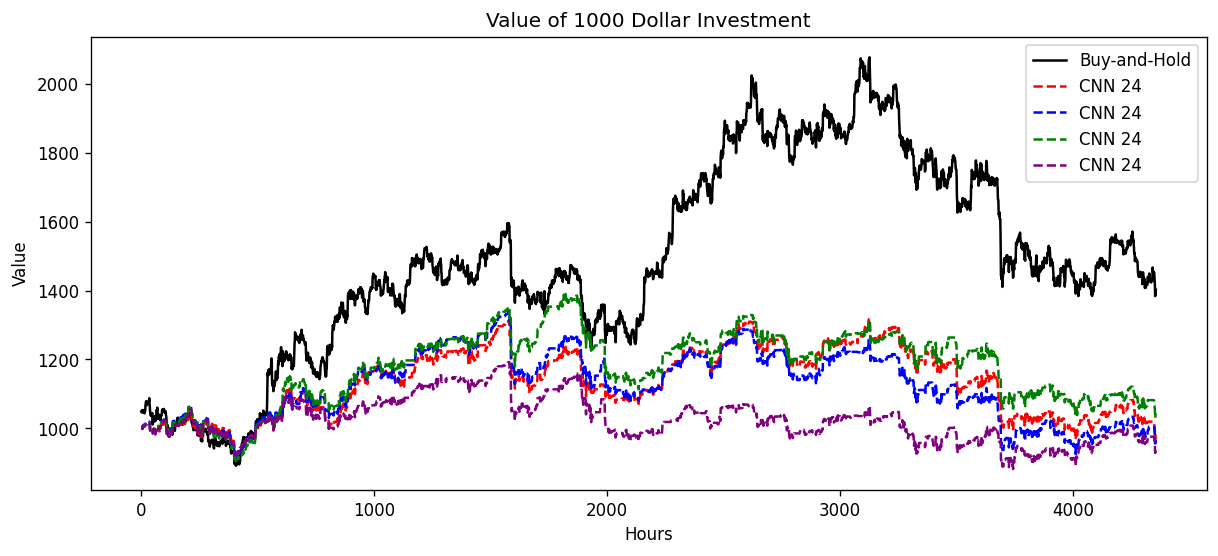

In [83]:
agents_net_worths=[net_worths1, net_worths2, net_worths3, net_worths4]
portfolio_movement_5_agents(agents_net_worths, B_and_H, 'CNN 24', 23, -1)
print('Our accuracies and final values for these models are:',
      '\n',
      acc1, 'percent and', round(net_worths1[-1],2), 'dollars,',
      '\n',
      acc2, 'percent and', round(net_worths2[-1],2), 'dollars,',
      '\n',
      acc3, 'percent and', round(net_worths3[-1],2), 'dollars,',
      '\n',
      acc4, 'percent and', round(net_worths4[-1],2), 'dollars.')

## LSTM

### 12 Hour Sequences

In [29]:
# Importing the data

dfs=['Non-Scaled TA Features 1H for BTC.csv']

In [30]:
# Train and test splitting and scaling
X=pd.read_csv(dfs[0])

X['Date']=pd.to_datetime(X['Date']) # Setting the index as the Date
X=X.set_index('Date').asfreq('H')

X=X.dropna()
y=X['Label']
X=X.drop('Label', axis=1)
X=X.drop('Percent Change', axis=1)


# Removing the testing data
X_test=X[-4380:] # Getting the last 6 months as the testing data
print('Confirming we have all the columns we want:','\n', X_test.columns)
y_test=y[-4380:].values

X=X[:-4380] # Getting everything but the first 6 months as the training data
y=y[:-4380]

Confirming we have all the columns we want: 
 Index(['BB_upper 10', 'BB_middle 10', 'BB_lower 10', 'Aroon_down 10',
       'Aroon_up 10', 'Aroonosc 10', 'RSI 10', 'NATR 10', 'BB_upper 12',
       'BB_middle 12',
       ...
       'MACD Signal 18', 'MACD Hist18', 'Med Price', 'Chaikin A/D Line',
       'HT Dom Phase', 'HT Dom Period', 'High', 'Low', 'Close', 'Volume'],
      dtype='object', length=101)


In [31]:
# Lagging function

def lagged_matrices(n_steps, X_matrix, y_matrix):
    X_lagged=[]
    y_lagged=[]
    y_matrix=y_matrix
    for i in range(n_steps, X_matrix.shape[0]):
        lag_set=X_matrix[i-n_steps:i]
        X_lagged.append(lag_set) # We are taking the last n_input to the present time periods as the 
        # X values.
        y_lagged.append(int(y_matrix[i-1]))
    X_lagged=np.array(X_lagged) # They need to be arrays
    return X_lagged, y_lagged

In [32]:
## Getting our training, validation, and testing sets

# First, we create our PCA matrices from the X and X_test
X, X_test=PCA_creation_train_test(20, X, X_test)

# Classes, sets, and features
num_classes=2 
n_steps = 12 # How many time periods into the past we will look.
n_features = 20 # Number of PCA features

# Getting our lagged matrices
X_set, y_set=lagged_matrices(n_steps, X, y)
X_test, y_test=lagged_matrices(n_steps, X_test, y_test)

# Split X into training and validation for our neural net
X_train, X_val, y_train, y_val=train_test_split(X_set, y_set, test_size=0.2, random_state=100, shuffle=True)
# Note, we have already made our images from sequential time slices, so we can shuffle our sets of images

# Making sure the y sets are arrays
y_train=np.array(y_train)
y_val=np.array(y_val)
y_test=np.array(y_test)

print(X_train.shape) # Confirming that our shape is (n_instances, n_steps, n_features)

(21011, 12, 20)


In [88]:
acc1, net_worths1, cm1 = investing_performance('Models/LSTM Class 12_1 BTC.h5', y_test, 11, -1)
acc2, net_worths2, cm2 = investing_performance('Models/LSTM Class 12_2 BTC.h5', y_test, 11, -1)
acc3, net_worths3, cm3 = investing_performance('Models/LSTM Class 12_3 BTC.h5', y_test, 11, -1)
acc4, net_worths4, cm4 = investing_performance('Models/LSTM Class 12_4 BTC.h5', y_test, 11, -1)

The lengths of the actions and y test are the same.
The lengths of the test pct changes and actions are the same.
The lengths of the actions and y test are the same.
The lengths of the test pct changes and actions are the same.
The lengths of the actions and y test are the same.
The lengths of the test pct changes and actions are the same.
The lengths of the actions and y test are the same.
The lengths of the test pct changes and actions are the same.


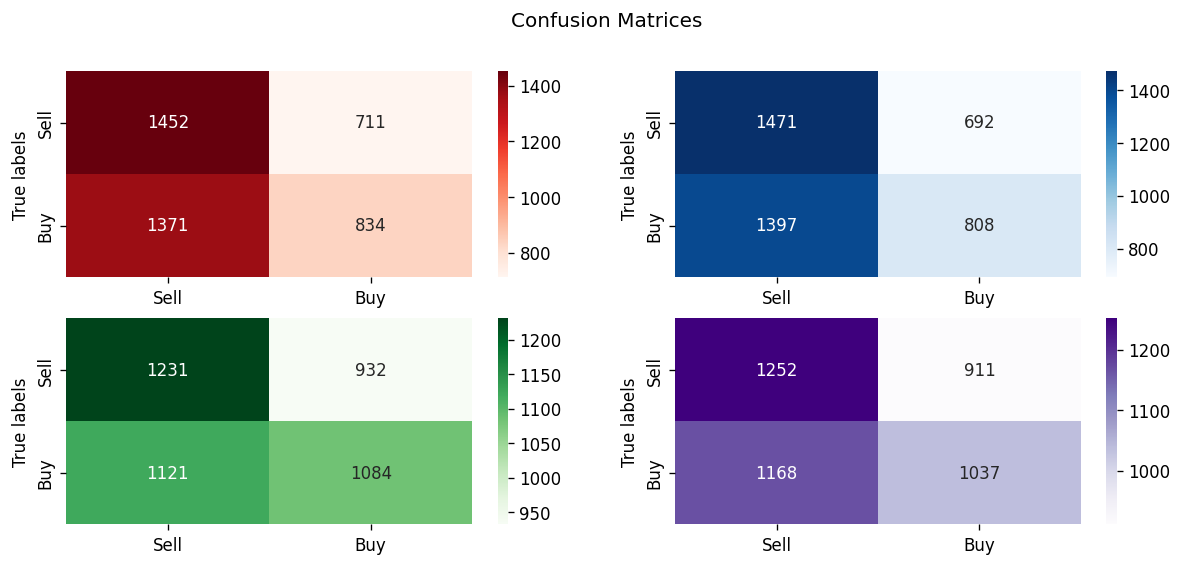

In [89]:
cms=[cm1, cm2, cm3, cm4]
confusion_matrices_4_by_4(cms)

The lengths of Buy-and-Hold and the agents are the same.
The lengths of the net worths and the Buy-and-Hold startegies are 4368 4368 4368 4368 4368
The final value with Buy-and-Hold is 1402.49
Our accuracies and final values for these models are: 
 52.0 percent and 1043.84 dollars, 
 52.0 percent and 1049.14 dollars, 
 53.0 percent and 1190.84 dollars, 
 52.0 percent and 947.98 dollars.


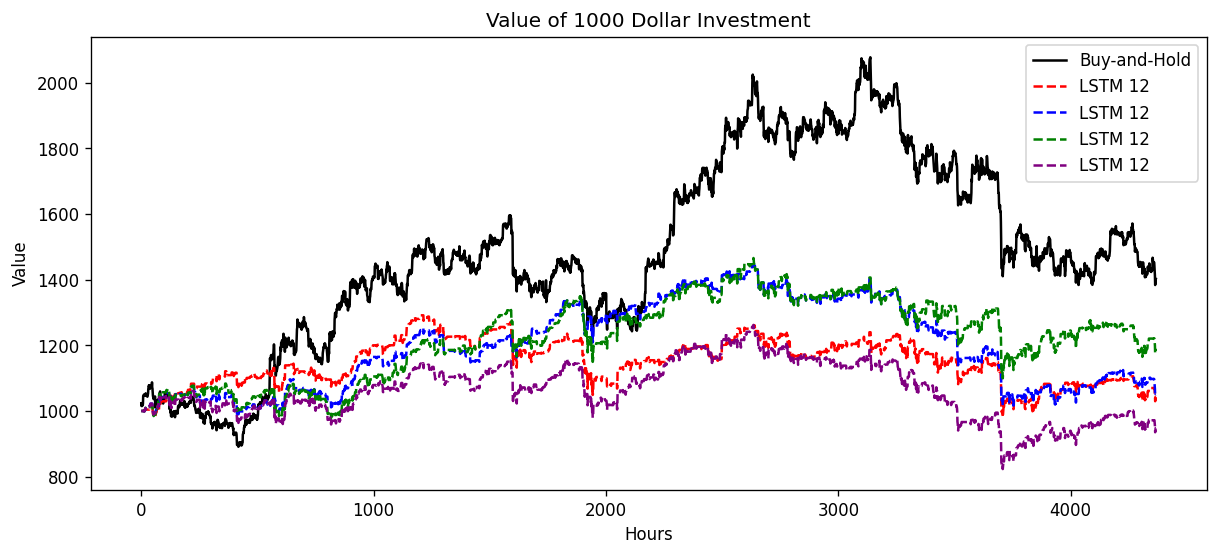

In [90]:
agents_net_worths=[net_worths1, net_worths2, net_worths3, net_worths4]
portfolio_movement_5_agents(agents_net_worths, B_and_H, 'LSTM 12', 11, -1)
print('Our accuracies and final values for these models are:',
      '\n',
      acc1, 'percent and', round(net_worths1[-1],2), 'dollars,',
      '\n',
      acc2, 'percent and', round(net_worths2[-1],2), 'dollars,',
      '\n',
      acc3, 'percent and', round(net_worths3[-1],2), 'dollars,',
      '\n',
      acc4, 'percent and', round(net_worths4[-1],2), 'dollars.')

### 18 Hour Sequences

In [91]:
# Importing the data

dfs=['Non-Scaled TA Features 1H for BTC.csv']

In [33]:
# Train and test splitting and scaling
X=pd.read_csv(dfs[0])

X['Date']=pd.to_datetime(X['Date']) # Setting the index as the Date
X=X.set_index('Date').asfreq('H')

X=X.dropna()
y=X['Label']
X=X.drop('Label', axis=1)
X=X.drop('Percent Change', axis=1)


# Removing the testing data
X_test=X[-4380:] # Getting the last 6 months as the testing data
print('Confirming we have all the columns we want:','\n', X_test.columns)
y_test=y[-4380:].values

X=X[:-4380] # Getting everything but the first 6 months as the training data
y=y[:-4380]

Confirming we have all the columns we want: 
 Index(['BB_upper 10', 'BB_middle 10', 'BB_lower 10', 'Aroon_down 10',
       'Aroon_up 10', 'Aroonosc 10', 'RSI 10', 'NATR 10', 'BB_upper 12',
       'BB_middle 12',
       ...
       'MACD Signal 18', 'MACD Hist18', 'Med Price', 'Chaikin A/D Line',
       'HT Dom Phase', 'HT Dom Period', 'High', 'Low', 'Close', 'Volume'],
      dtype='object', length=101)


In [34]:
# Lagging function

def lagged_matrices(n_steps, X_matrix, y_matrix):
    X_lagged=[]
    y_lagged=[]
    y_matrix=y_matrix
    for i in range(n_steps, X_matrix.shape[0]):
        lag_set=X_matrix[i-n_steps:i]
        X_lagged.append(lag_set) # We are taking the last n_input to the present time periods as the 
        # X values.
        y_lagged.append(int(y_matrix[i-1]))
    X_lagged=np.array(X_lagged) # They need to be arrays
    return X_lagged, y_lagged

In [35]:
## Getting our training, validation, and testing sets

# First, we create our PCA matrices from the X and X_test
X, X_test=PCA_creation_train_test(20, X, X_test)

# Classes, sets, and features
num_classes=2 
n_steps = 18 # How many time periods into the past we will look.
n_features = 20 # Number of PCA features

# Getting our lagged matrices
X_set, y_set=lagged_matrices(n_steps, X, y)
X_test, y_test=lagged_matrices(n_steps, X_test, y_test)

# Split X into training and validation for our neural net
X_train, X_val, y_train, y_val=train_test_split(X_set, y_set, test_size=0.2, random_state=100, shuffle=True)
# Note, we have already made our images from sequential time slices, so we can shuffle our sets of images

# Making sure the y sets are arrays
y_train=np.array(y_train)
y_val=np.array(y_val)
y_test=np.array(y_test)

print(X_train.shape) # Confirming that our shape is (n_instances, n_steps, n_features)

(21006, 18, 20)


In [95]:
acc1, net_worths1, cm1 = investing_performance('Models/LSTM Class 18_1 BTC.h5', y_test, 17, -1)
acc2, net_worths2, cm2 = investing_performance('Models/LSTM Class 18_2 BTC.h5', y_test, 17, -1)
acc3, net_worths3, cm3 = investing_performance('Models/LSTM Class 18_3 BTC.h5', y_test, 17, -1)
acc4, net_worths4, cm4 = investing_performance('Models/LSTM Class 18_4 BTC.h5', y_test, 17, -1)

The lengths of the actions and y test are the same.
The lengths of the test pct changes and actions are the same.
The lengths of the actions and y test are the same.
The lengths of the test pct changes and actions are the same.
The lengths of the actions and y test are the same.
The lengths of the test pct changes and actions are the same.
The lengths of the actions and y test are the same.
The lengths of the test pct changes and actions are the same.


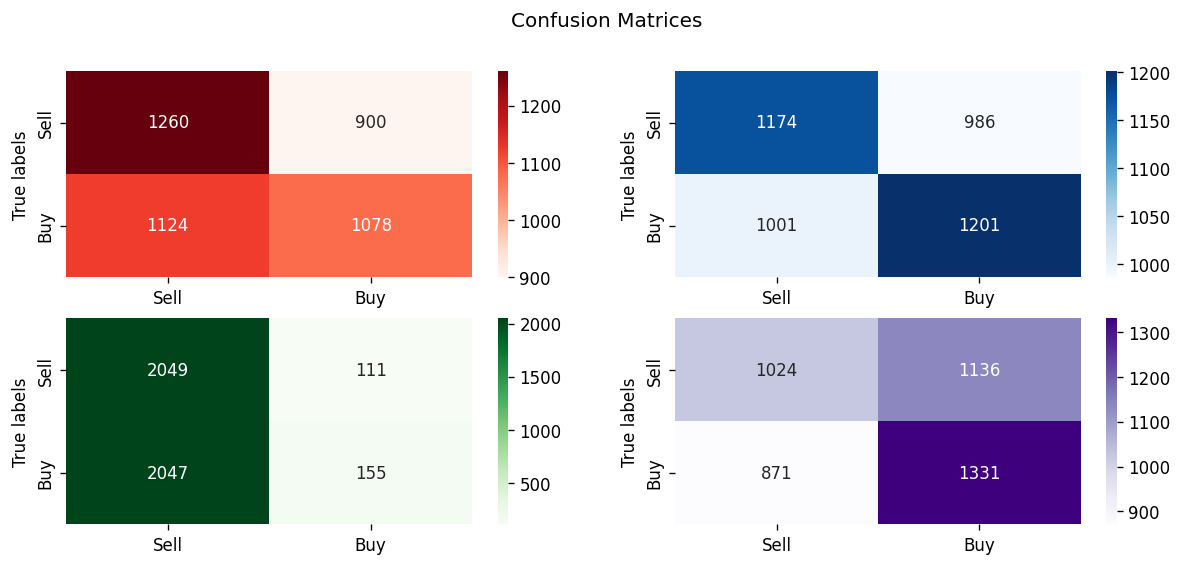

In [96]:
cms=[cm1, cm2, cm3, cm4]
confusion_matrices_4_by_4(cms)

The lengths of Buy-and-Hold and the agents are the same.
The lengths of the net worths and the Buy-and-Hold startegies are 4362 4362 4362 4362 4362
The final value with Buy-and-Hold is 1402.49
Our accuracies and final values for these models are: 
 54.0 percent and 1269.94 dollars, 
 54.0 percent and 1519.76 dollars, 
 51.0 percent and 1119.54 dollars, 
 54.0 percent and 1236.74 dollars.


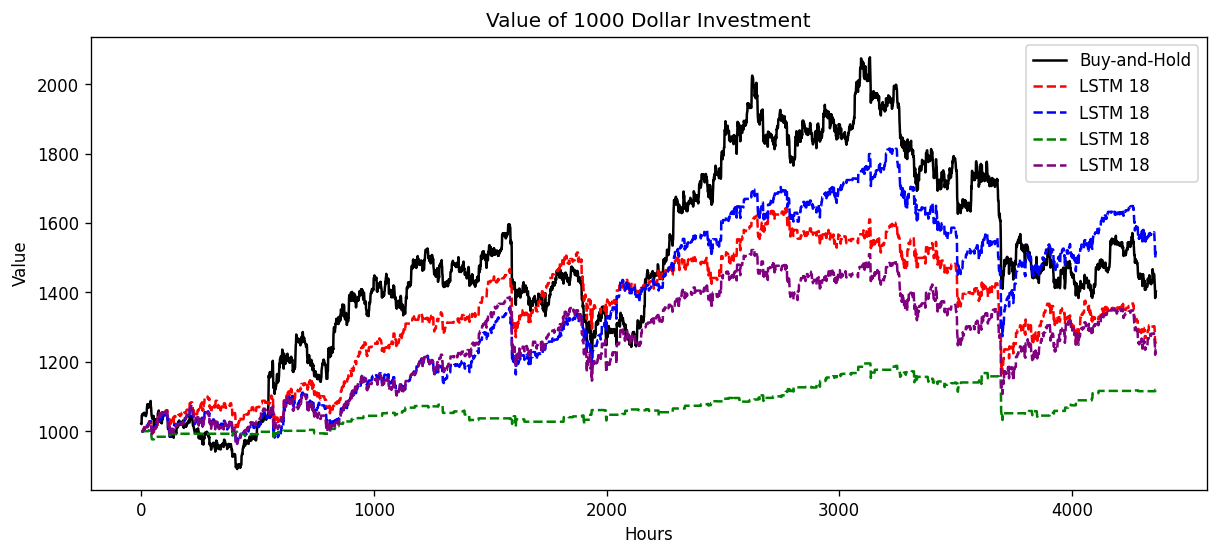

In [97]:
agents_net_worths=[net_worths1, net_worths2, net_worths3, net_worths4]
portfolio_movement_5_agents(agents_net_worths, B_and_H, 'LSTM 18', 17, -1)
print('Our accuracies and final values for these models are:',
      '\n',
      acc1, 'percent and', round(net_worths1[-1],2), 'dollars,',
      '\n',
      acc2, 'percent and', round(net_worths2[-1],2), 'dollars,',
      '\n',
      acc3, 'percent and', round(net_worths3[-1],2), 'dollars,',
      '\n',
      acc4, 'percent and', round(net_worths4[-1],2), 'dollars.')

### 24 Hour Sequences

In [98]:
# Importing the data

dfs=['Non-Scaled TA Features 1H for BTC.csv']

In [36]:
# Train and test splitting and scaling
X=pd.read_csv(dfs[0])

X['Date']=pd.to_datetime(X['Date']) # Setting the index as the Date
X=X.set_index('Date').asfreq('H')

X=X.dropna()
y=X['Label']
X=X.drop('Label', axis=1)
X=X.drop('Percent Change', axis=1)


# Removing the testing data
X_test=X[-4380:] # Getting the last 6 months as the testing data
print('Confirming we have all the columns we want:','\n', X_test.columns)
y_test=y[-4380:].values

X=X[:-4380] # Getting everything but the first 6 months as the training data
y=y[:-4380]

Confirming we have all the columns we want: 
 Index(['BB_upper 10', 'BB_middle 10', 'BB_lower 10', 'Aroon_down 10',
       'Aroon_up 10', 'Aroonosc 10', 'RSI 10', 'NATR 10', 'BB_upper 12',
       'BB_middle 12',
       ...
       'MACD Signal 18', 'MACD Hist18', 'Med Price', 'Chaikin A/D Line',
       'HT Dom Phase', 'HT Dom Period', 'High', 'Low', 'Close', 'Volume'],
      dtype='object', length=101)


In [37]:
# Lagging function

def lagged_matrices(n_steps, X_matrix, y_matrix):
    X_lagged=[]
    y_lagged=[]
    y_matrix=y_matrix
    for i in range(n_steps, X_matrix.shape[0]):
        lag_set=X_matrix[i-n_steps:i]
        X_lagged.append(lag_set) # We are taking the last n_input to the present time periods as the 
        # X values.
        y_lagged.append(int(y_matrix[i-1]))
    X_lagged=np.array(X_lagged) # They need to be arrays
    return X_lagged, y_lagged

In [38]:
## Getting our training, validation, and testing sets

# First, we create our PCA matrices from the X and X_test
X, X_test=PCA_creation_train_test(20, X, X_test)

# Classes, sets, and features
num_classes=2 
n_steps = 24 # How many time periods into the past we will look.
n_features = 20 # Number of PCA features

# Getting our lagged matrices
X_set, y_set=lagged_matrices(n_steps, X, y)
X_test, y_test=lagged_matrices(n_steps, X_test, y_test)

# Split X into training and validation for our neural net
X_train, X_val, y_train, y_val=train_test_split(X_set, y_set, test_size=0.2, random_state=100, shuffle=True)
# Note, we have already made our images from sequential time slices, so we can shuffle our sets of images

# Making sure the y sets are arrays
y_train=np.array(y_train)
y_val=np.array(y_val)
y_test=np.array(y_test)

print(X_train.shape) # Confirming that our shape is (n_instances, n_steps, n_features)

(21001, 24, 20)


In [102]:
acc1, net_worths1, cm1 = investing_performance('Models/CNN 24_1 BTC.h5', y_test, 23, -1)
acc2, net_worths2, cm2 = investing_performance('Models/CNN 24_2 BTC.h5', y_test, 23, -1)
acc3, net_worths3, cm3 = investing_performance('Models/CNN 24_3 BTC.h5', y_test, 23, -1)
acc4, net_worths4, cm4 = investing_performance('Models/CNN 24_4 BTC.h5', y_test, 23, -1)

The lengths of the actions and y test are the same.
The lengths of the test pct changes and actions are the same.
The lengths of the actions and y test are the same.
The lengths of the test pct changes and actions are the same.
The lengths of the actions and y test are the same.
The lengths of the test pct changes and actions are the same.
The lengths of the actions and y test are the same.
The lengths of the test pct changes and actions are the same.


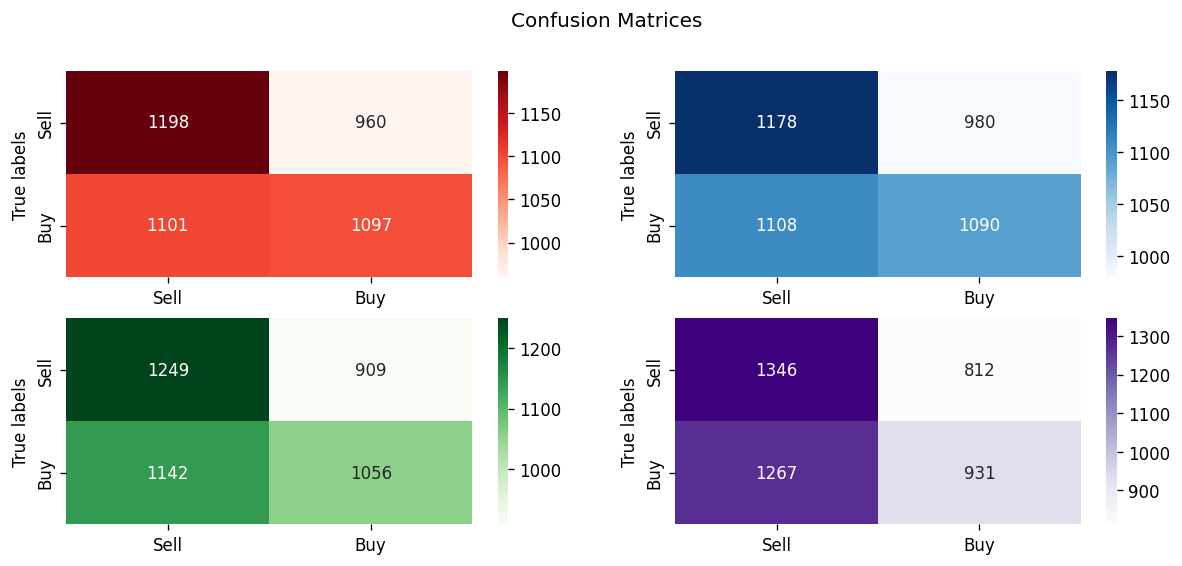

In [103]:
cms=[cm1, cm2, cm3, cm4]
confusion_matrices_4_by_4(cms)

The lengths of Buy-and-Hold and the agents are the same.
The lengths of the net worths and the Buy-and-Hold startegies are 4356 4356 4356 4356 4356
The final value with Buy-and-Hold is 1402.49
Our accuracies and final values for these models are: 
 53.0 percent and 982.91 dollars, 
 52.0 percent and 968.54 dollars, 
 53.0 percent and 1043.2 dollars, 
 52.0 percent and 940.81 dollars.


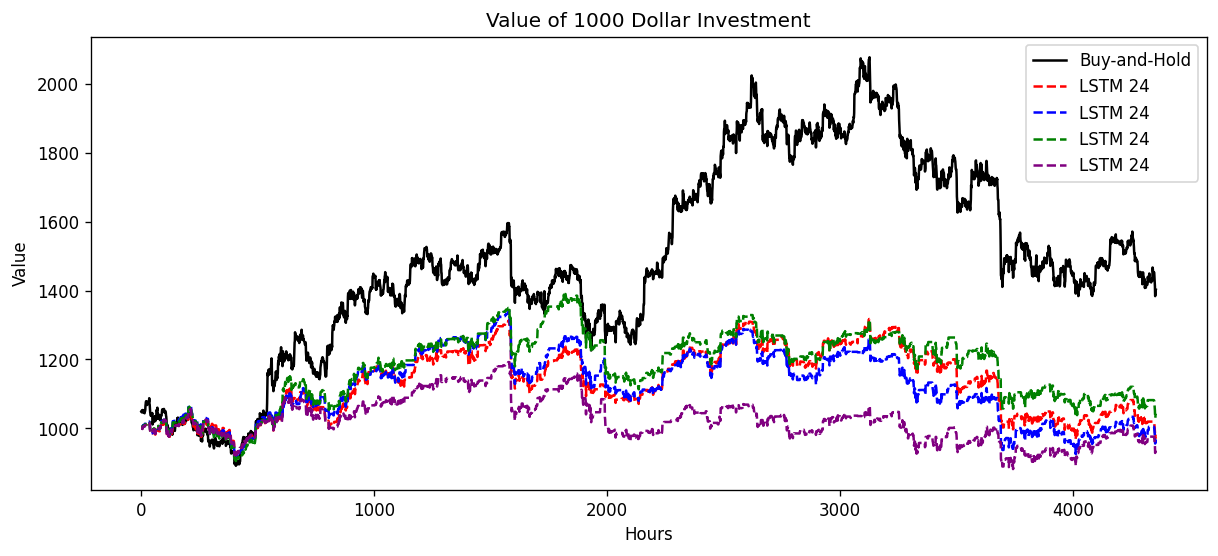

In [104]:
agents_net_worths=[net_worths1, net_worths2, net_worths3, net_worths4]
portfolio_movement_5_agents(agents_net_worths, B_and_H, 'LSTM 24', 23, -1)
print('Our accuracies and final values for these models are:',
      '\n',
      acc1, 'percent and', round(net_worths1[-1],2), 'dollars,',
      '\n',
      acc2, 'percent and', round(net_worths2[-1],2), 'dollars,',
      '\n',
      acc3, 'percent and', round(net_worths3[-1],2), 'dollars,',
      '\n',
      acc4, 'percent and', round(net_worths4[-1],2), 'dollars.')

# Reinforcement Learning

## CNN Based Dueling Double DQN with PER

### Bitcoin

Note, to avoid duplicating cells and increasing the length of this script without warrant, we have included only the image_creation function and DuelingDQN Agent class in this first Bitcoin section. To run the other coins, one would need to run the cells with these functions so they can be ready.

In [39]:
# Importing the data

dfs=['Non-Scaled TA Features 1H for BTC.csv']

In [40]:
# Setting up the device

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [41]:
# Train and test splitting and scaling
X=pd.read_csv(dfs[0])

X['Date']=pd.to_datetime(X['Date']) # Setting the index as the Date
X=X.set_index('Date').asfreq('H')

X=X.dropna()
y=X['Percent Change']
X=X.drop('Label', axis=1)
X=X.drop('Percent Change', axis=1)


# Removing the testing data
X_test=X[-4380:] # Getting the last 6 months as the testing data
print('Confirming we have all the columns we want:','\n', X_test.columns)
y_test=y[-4380:].values

X=X[:-4380] # Getting everything but the first 6 months as the training data
y=y[:-4380]
print(y_test)

Confirming we have all the columns we want: 
 Index(['BB_upper 10', 'BB_middle 10', 'BB_lower 10', 'Aroon_down 10',
       'Aroon_up 10', 'Aroonosc 10', 'RSI 10', 'NATR 10', 'BB_upper 12',
       'BB_middle 12',
       ...
       'MACD Signal 18', 'MACD Hist18', 'Med Price', 'Chaikin A/D Line',
       'HT Dom Phase', 'HT Dom Period', 'High', 'Low', 'Close', 'Volume'],
      dtype='object', length=101)
[ 0.61446374  0.80874465  0.50518634 ...  0.98700007 -0.01400845
 -0.23385943]


In [42]:
# Image creation function

def image_creation(n_steps, X, y):
    X_images=[]
    y_values=[]
    
    for i in range(n_steps, len(X)):
        img=X[i-n_steps,:]
        img=np.vstack((img, X[i-n_steps+1,:]))
        img=np.vstack((img, X[i-n_steps+2,:]))
        img=np.vstack((img, X[i-n_steps+3,:]))
        img=np.vstack((img, X[i-n_steps+4,:]))
        img=np.vstack((img, X[i-n_steps+5,:]))
        img=np.vstack((img, X[i-n_steps+6,:]))
        img=np.vstack((img, X[i-n_steps+7,:]))
        img=np.vstack((img, X[i-n_steps+8,:]))
        img=np.vstack((img, X[i-n_steps+9,:]))
        img=np.vstack((img, X[i-n_steps+10,:]))
        img=np.vstack((img, X[i-n_steps+11,:]))
        X_images.append(img)
        y_values.append(y[i-n_steps+11])
        
    return X_images, np.array(y_values) # Note, this will not include the very last one.

In [43]:
n_steps=12

# First, we create our PCA matrices from the X and X_test
X, X_test=PCA_creation_train_test(20, X, X_test)
    
# Getting the X and X_test matrices' images
X_train, y_train=image_creation(n_steps, X ,y)
X_test, y_test=image_creation(n_steps, X_test, y_test)
y_train=np.array(y_train)
y_test=np.array(y_test)

# Finalizing the shapes
num_classes = 2
input_shape = (n_steps, len(X[0]), 1)

# Add a dimension at the beginning end to make sure images have shape (1, n_steps, n_features)
# Note this is the OPPOSITE of tensorflow
X_train = np.expand_dims(X_train, 1)
X_test = np.expand_dims(X_test, 1)
print("X_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

X_train shape: (26264, 1, 12, 20)
26264 train samples
4368 test samples


In [45]:
# Creating the Dueling DQN Agent

class DuelingDQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon=0):

        super().__init__()
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape

        # Conv and Pool Network
    
        self.conv_network = nn.Sequential()
        self.conv_network.add_module('conv', nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=0)) # 'Valid' padding
        self.conv_network.add_module('tanh', nn.Tanh())
        self.conv_network.add_module('avg_pool', nn.AvgPool2d(kernel_size=2, stride=2, padding=0))
        self.conv_network.add_module('flatten', nn.Flatten())

        # MLP Network for both Value and Advantage go through

        self.fc_network = nn.Sequential()
        self.fc_network.add_module('linear1', nn.Linear(2880, 512))
        self.fc_network.add_module('tanh1', nn.Tanh())
        self.fc_network.add_module('Dropout1', nn.Dropout(0.6))
        self.fc_network.add_module('linear2', nn.Linear(512, 512))
        self.fc_network.add_module('tanh2', nn.Tanh())
        self.fc_network.add_module('Dropout2', nn.Dropout(0.6))

        # Value Layer
        self.value = nn.Linear(512, 1)

        # Advantage Layer
        self.adv = nn.Linear(512, n_actions)

    def forward(self, state_t):
        # pass the state at time t through the network to get Q(s,a)
        x = self.conv_network(state_t)
        x = self.fc_network(x)
        v = self.value(x)
        adv = self.adv(x)
        adv_avg = torch.mean(adv, dim=1, keepdim=True)
        qvalues = v + adv - adv_avg
        return qvalues

    def get_qvalues(self, states):
        # input is an array of states in numpy and output is Qvals as numpy array
        states = torch.tensor(states, device=device, dtype=torch.float32)
        qvalues = self.forward(states)
        return qvalues.data.cpu().numpy()

    def sample_actions(self, qvalues):
        # sample actions from a batch of q_values using epsilon greedy policy
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape
        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)
        should_explore = np.random.choice(
            [0, 1], batch_size, p=[1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [112]:
# Loading an agent

agent = torch.load('Models/CNN DQN gamma_0.5 BTC.h5')
agent.eval()

DuelingDQNAgent(
  (conv_network): Sequential(
    (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (tanh): Tanh()
    (avg_pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_network): Sequential(
    (linear1): Linear(in_features=2880, out_features=512, bias=True)
    (tanh1): Tanh()
    (Dropout1): Dropout(p=0.6, inplace=False)
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (tanh2): Tanh()
    (Dropout2): Dropout(p=0.6, inplace=False)
  )
  (value): Linear(in_features=512, out_features=1, bias=True)
  (adv): Linear(in_features=512, out_features=2, bias=True)
)

In [113]:
net_worths1=investing_performance_rl('Models/CNN DQN gamma_0.5 BTC.h5', X_test, y_test, 'DQN')
net_worths1=[x[0] for x in net_worths1]
net_worths2=investing_performance_rl('Models/CNN DQN gamma_0.5 BTC.h5', X_test, y_test, 'DQN')
net_worths2=[x[0] for x in net_worths2]
net_worths3=investing_performance_rl('Models/CNN DQN gamma_0.5 BTC.h5', X_test, y_test, 'DQN')
net_worths3=[x[0] for x in net_worths3]
net_worths4=investing_performance_rl('Models/CNN DQN gamma_0.5 BTC.h5', X_test, y_test, 'DQN')
net_worths4=[x[0] for x in net_worths4]

C:\Users\chris\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)


The lengths of Buy-and-Hold and the agents are the same.
The lengths of the net worths and the Buy-and-Hold startegies are 4368 4368 4368 4368 4368
The final value with Buy-and-Hold is 1402.49
Our final values for these models are: 
 1433.22 dollars, 
 1290.48 dollars, 
 1496.3 dollars, 
 1698.76 dollars.


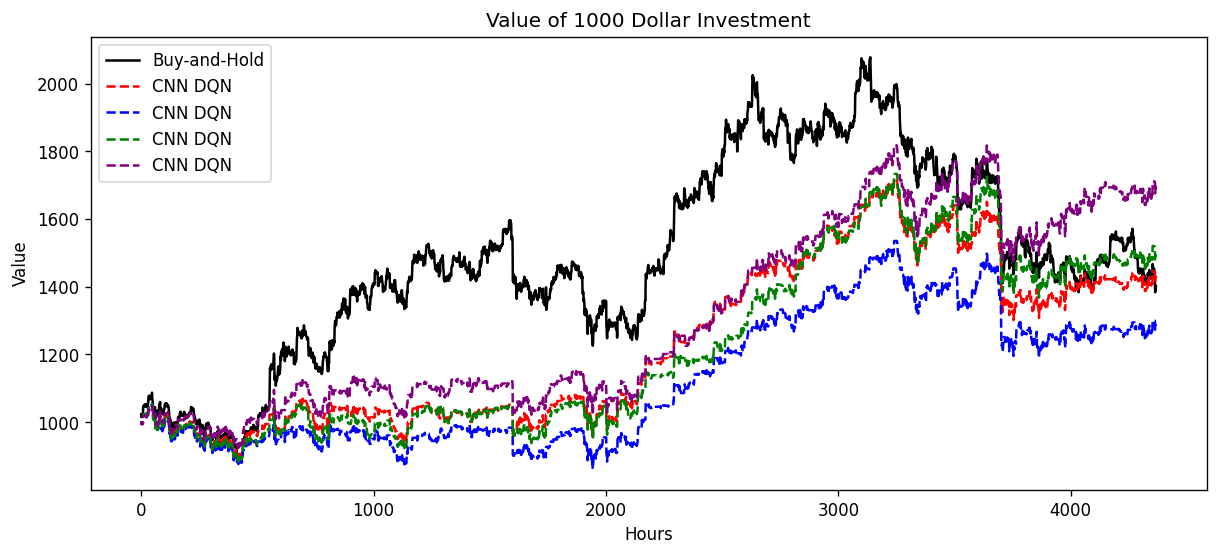

In [114]:
agents_net_worths=[net_worths1, net_worths2, net_worths3, net_worths4]
portfolio_movement_5_agents(agents_net_worths, B_and_H, 'CNN DQN', 11, -1)
print('Our final values for these models are:',
      '\n',
      round(net_worths1[-1],2), 'dollars,',
      '\n',
      round(net_worths2[-1],2), 'dollars,',
      '\n',
      round(net_worths3[-1],2), 'dollars,',
      '\n',
      round(net_worths4[-1],2), 'dollars.')

### Etherium

In [46]:
# Redoing Buy-and-Hold

dfs=['Non-Scaled TA Features 1H for ETH.csv']

def Buy_and_Hold(test_pct_changes, init_balance):
    curr_balance=init_balance
    balances=[]
    
    for pct_chng in test_pct_changes:
        curr_balance=curr_balance*(1+pct_chng)
        balances.append(curr_balance)
        
    return balances

init_balance=1000
_,y_test=testing_data_pct_changes(dfs, 'hour')
B_and_H=Buy_and_Hold(y_test, init_balance)
print('The length of Buy-and-Hold is:',len(B_and_H))
print('Buy-and-Hold runs from', y_test.index[0], 'to', y_test.index[-1])

The length of Buy-and-Hold is: 4380
Buy-and-Hold runs from 2021-07-02 11:00:00 to 2021-12-31 22:00:00


Final Value of Buy-and-Hold for Ethereum: 1806.4954430851626


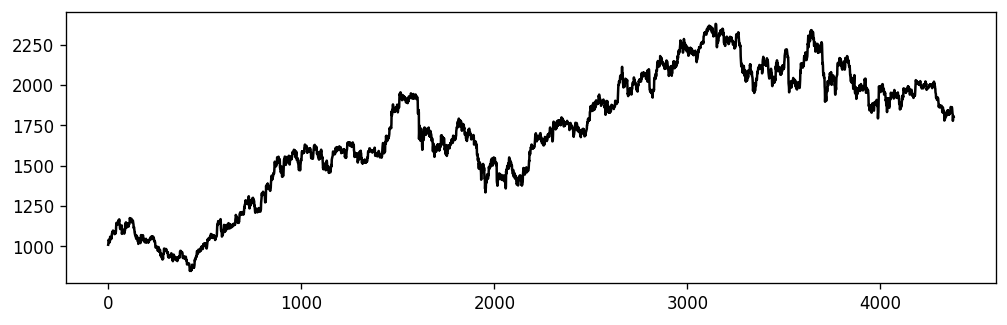

In [47]:
plt.plot(B_and_H, color='black')
print('Final Value of Buy-and-Hold for Ethereum:',B_and_H[-2])

In [48]:
# Train and test splitting and scaling
X=pd.read_csv(dfs[0])

X['Date']=pd.to_datetime(X['Date']) # Setting the index as the Date
X=X.set_index('Date').asfreq('H')

X=X.dropna()
y=X['Percent Change']
X=X.drop('Label', axis=1)
X=X.drop('Percent Change', axis=1)


# Removing the testing data
X_test=X[-4380:] # Getting the last 6 months as the testing data
print('Confirming we have all the columns we want:','\n', X_test.columns)
y_test=y[-4380:].values

X=X[:-4380] # Getting everything but the first 6 months as the training data
y=y[:-4380]

Confirming we have all the columns we want: 
 Index(['BB_upper 10', 'BB_middle 10', 'BB_lower 10', 'Aroon_down 10',
       'Aroon_up 10', 'Aroonosc 10', 'RSI 10', 'NATR 10', 'BB_upper 12',
       'BB_middle 12',
       ...
       'MACD Signal 18', 'MACD Hist18', 'Med Price', 'Chaikin A/D Line',
       'HT Dom Phase', 'HT Dom Period', 'High', 'Low', 'Close', 'Volume'],
      dtype='object', length=101)


In [50]:
n_steps=12

# First, we create our PCA matrices from the X and X_test
X, X_test=PCA_creation_train_test(20, X, X_test)
    
# Getting the X and X_test matrices' images
X_train, y_train=image_creation(n_steps, X ,y)
X_test, y_test=image_creation(n_steps, X_test, y_test)
y_train=np.array(y_train)
y_test=np.array(y_test)

# Finalizing the shapes
num_classes = 2
input_shape = (n_steps, len(X[0]), 1)

# Add a dimension at the beginning end to make sure images have shape (1, n_steps, n_features)
# Note this is the OPPOSITE of tensorflow
X_train = np.expand_dims(X_train, 1)
X_test = np.expand_dims(X_test, 1)
print("X_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

X_train shape: (26264, 1, 12, 20)
26264 train samples
4368 test samples


In [122]:
# Loading an agent

agent = torch.load('Models/CNN DQN gamma_0.5 BTC.h5')
agent.eval()

DuelingDQNAgent(
  (conv_network): Sequential(
    (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (tanh): Tanh()
    (avg_pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_network): Sequential(
    (linear1): Linear(in_features=2880, out_features=512, bias=True)
    (tanh1): Tanh()
    (Dropout1): Dropout(p=0.6, inplace=False)
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (tanh2): Tanh()
    (Dropout2): Dropout(p=0.6, inplace=False)
  )
  (value): Linear(in_features=512, out_features=1, bias=True)
  (adv): Linear(in_features=512, out_features=2, bias=True)
)

In [123]:
net_worths1=investing_performance_rl('Models/CNN DQN gamma_0.5 BTC.h5', X_test, y_test, 'DQN')
net_worths1=[x[0] for x in net_worths1]
net_worths2=investing_performance_rl('Models/CNN DQN gamma_0.5 BTC.h5', X_test, y_test, 'DQN')
net_worths2=[x[0] for x in net_worths2]
net_worths3=investing_performance_rl('Models/CNN DQN gamma_0.5 BTC.h5', X_test, y_test, 'DQN')
net_worths3=[x[0] for x in net_worths3]
net_worths4=investing_performance_rl('Models/CNN DQN gamma_0.5 BTC.h5', X_test, y_test, 'DQN')
net_worths4=[x[0] for x in net_worths4]

The lengths of Buy-and-Hold and the agents are the same.
The lengths of the net worths and the Buy-and-Hold startegies are 4368 4368 4368 4368 4368
The final value with Buy-and-Hold is 1806.5
Our final values for these models are: 
 1058.66 dollars, 
 1097.62 dollars, 
 1016.74 dollars, 
 1092.15 dollars.


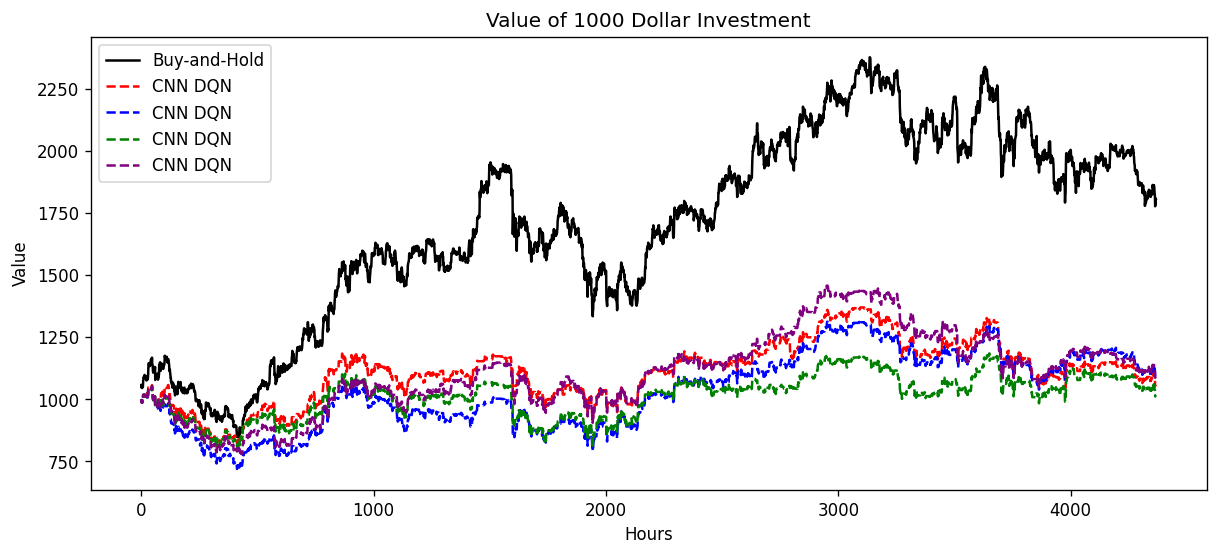

In [124]:
agents_net_worths=[net_worths1, net_worths2, net_worths3, net_worths4]
portfolio_movement_5_agents(agents_net_worths, B_and_H, 'CNN DQN', 11, -1)
print('Our final values for these models are:',
      '\n',
      round(net_worths1[-1],2), 'dollars,',
      '\n',
      round(net_worths2[-1],2), 'dollars,',
      '\n',
      round(net_worths3[-1],2), 'dollars,',
      '\n',
      round(net_worths4[-1],2), 'dollars.')

### Litecoin

In [51]:
# Redoing Buy-and-Hold

dfs=['Non-Scaled TA Features 1H for LTC.csv']

def Buy_and_Hold(test_pct_changes, init_balance):
    curr_balance=init_balance
    balances=[]
    
    for pct_chng in test_pct_changes:
        curr_balance=curr_balance*(1+pct_chng)
        balances.append(curr_balance)
        
    return balances

init_balance=1000
_,y_test=testing_data_pct_changes(dfs, 'hour')
B_and_H=Buy_and_Hold(y_test, init_balance)
print('The length of Buy-and-Hold is:',len(B_and_H))
print('Buy-and-Hold runs from', y_test.index[0], 'to', y_test.index[-1])

The length of Buy-and-Hold is: 4380
Buy-and-Hold runs from 2021-07-02 11:00:00 to 2021-12-31 22:00:00


Final Value of Buy-and-Hold for Litecoin: 1111.2631098951204


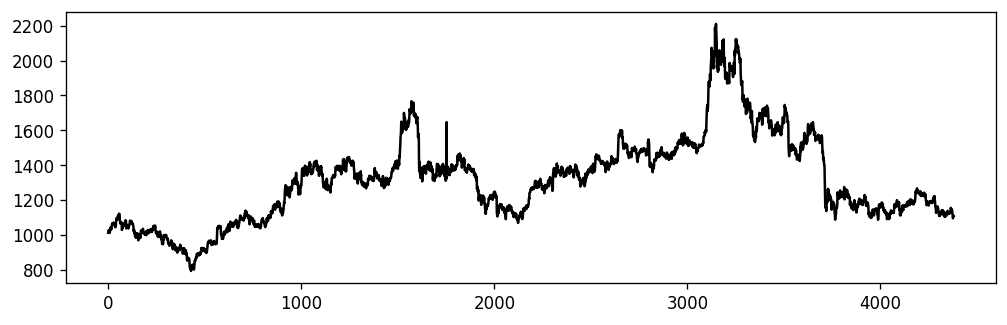

In [52]:
plt.plot(B_and_H, color='black')
print('Final Value of Buy-and-Hold for Litecoin:',B_and_H[-2])

In [53]:
# Train and test splitting and scaling
X=pd.read_csv(dfs[0])

X['Date']=pd.to_datetime(X['Date']) # Setting the index as the Date
X=X.set_index('Date').asfreq('H')

X=X.dropna()
y=X['Percent Change']
X=X.drop('Label', axis=1)
X=X.drop('Percent Change', axis=1)


# Removing the testing data
X_test=X[-4380:] # Getting the last 6 months as the testing data
print('Confirming we have all the columns we want:','\n', X_test.columns)
y_test=y[-4380:].values

X=X[:-4380] # Getting everything but the first 6 months as the training data
y=y[:-4380]
print(y_test)

Confirming we have all the columns we want: 
 Index(['BB_upper 10', 'BB_middle 10', 'BB_lower 10', 'Aroon_down 10',
       'Aroon_up 10', 'Aroonosc 10', 'RSI 10', 'NATR 10', 'BB_upper 12',
       'BB_middle 12',
       ...
       'MACD Signal 18', 'MACD Hist18', 'Med Price', 'Chaikin A/D Line',
       'HT Dom Phase', 'HT Dom Period', 'High', 'Low', 'Close', 'Volume'],
      dtype='object', length=101)
[ 1.17039064  0.53335337  0.67996712 ...  1.33851169  0.0684369
 -0.17097524]


In [55]:
n_steps=12

# First, we create our PCA matrices from the X and X_test
X, X_test=PCA_creation_train_test(20, X, X_test)
    
# Getting the X and X_test matrices' images
X_train, y_train=image_creation(n_steps, X ,y)
X_test, y_test=image_creation(n_steps, X_test, y_test)
y_train=np.array(y_train)
y_test=np.array(y_test)

# Finalizing the shapes
num_classes = 2
input_shape = (n_steps, len(X[0]), 1)

# Add a dimension at the beginning end to make sure images have shape (1, n_steps, n_features)
# Note this is the OPPOSITE of tensorflow
X_train = np.expand_dims(X_train, 1)
X_test = np.expand_dims(X_test, 1)
print("X_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

X_train shape: (26264, 1, 12, 20)
26264 train samples
4368 test samples


In [132]:
# Loading an agent

agent = torch.load('Models/CNN DQN gamma_0.5 BTC.h5')
agent.eval()

DuelingDQNAgent(
  (conv_network): Sequential(
    (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (tanh): Tanh()
    (avg_pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_network): Sequential(
    (linear1): Linear(in_features=2880, out_features=512, bias=True)
    (tanh1): Tanh()
    (Dropout1): Dropout(p=0.6, inplace=False)
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (tanh2): Tanh()
    (Dropout2): Dropout(p=0.6, inplace=False)
  )
  (value): Linear(in_features=512, out_features=1, bias=True)
  (adv): Linear(in_features=512, out_features=2, bias=True)
)

In [133]:
net_worths1=investing_performance_rl('Models/CNN DQN gamma_0.5 BTC.h5', X_test, y_test, 'DQN')
net_worths1=[x[0] for x in net_worths1]
net_worths2=investing_performance_rl('Models/CNN DQN gamma_0.5 BTC.h5', X_test, y_test, 'DQN')
net_worths2=[x[0] for x in net_worths2]
net_worths3=investing_performance_rl('Models/CNN DQN gamma_0.5 BTC.h5', X_test, y_test, 'DQN')
net_worths3=[x[0] for x in net_worths3]
net_worths4=investing_performance_rl('Models/CNN DQN gamma_0.5 BTC.h5', X_test, y_test, 'DQN')
net_worths4=[x[0] for x in net_worths4]

The lengths of Buy-and-Hold and the agents are the same.
The lengths of the net worths and the Buy-and-Hold startegies are 4368 4368 4368 4368 4368
The final value with Buy-and-Hold is 1111.26
Our final values for these models are: 
 1100.63 dollars, 
 1123.61 dollars, 
 1112.79 dollars, 
 1193.91 dollars.


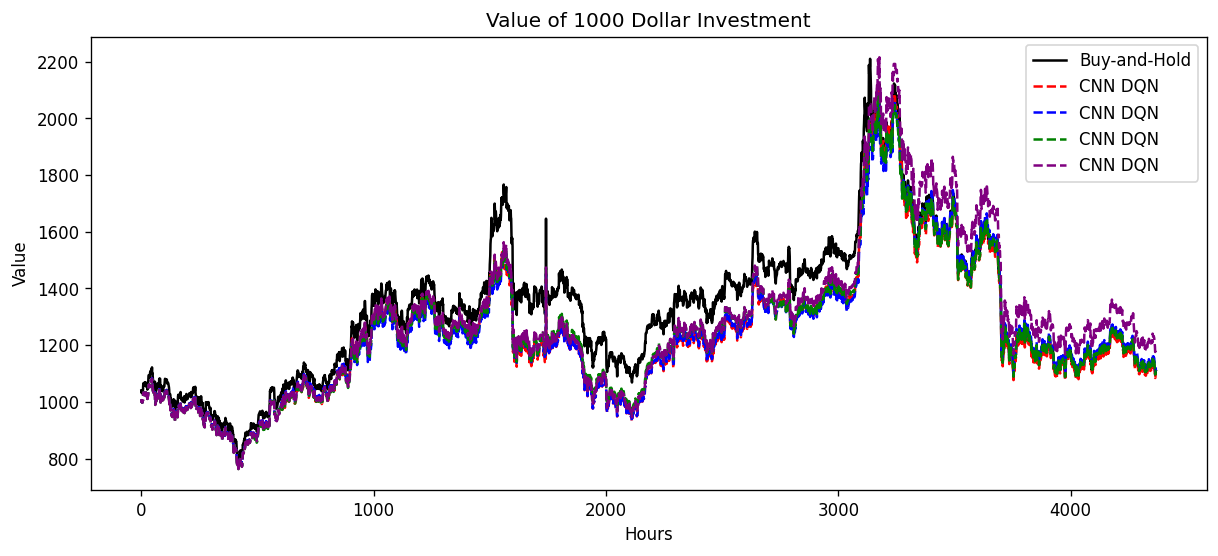

In [134]:
agents_net_worths=[net_worths1, net_worths2, net_worths3, net_worths4]
portfolio_movement_5_agents(agents_net_worths, B_and_H, 'CNN DQN', 11, -1)
print('Our final values for these models are:',
      '\n',
      round(net_worths1[-1],2), 'dollars,',
      '\n',
      round(net_worths2[-1],2), 'dollars,',
      '\n',
      round(net_worths3[-1],2), 'dollars,',
      '\n',
      round(net_worths4[-1],2), 'dollars.')

### Bitcoin 2022

Note, we redo the testing_data_pct_changes function for 2022. To avoid issues, if one wishes to rerun an earlier coin up to the end of 2021, they would need to rerun Section 2, Importing the Data Functions. They should also make sure to run the various functions missing in these sections mentioned in 7.1.1.

In [69]:
# Redoing Buy-and-Hold

dfs=['Non-Scaled TA Features 1H for BTC 2022.csv']

def testing_data_pct_changes(dfs, time_frame):
    if time_frame == 'hour':
        X=pd.read_csv(dfs[0])
        X['Date']=pd.to_datetime(X['Date']) # Setting the index as the Date
        X=X.set_index('Date').asfreq('H')
        X=X.dropna()
        y=X['Percent Change']
        X=X.drop('Label', axis=1)
        X=X.drop('Percent Change', axis=1)

        # Removing the testing data
        X_test=X['2022-01-01 0:00:00':] # Getting the last 6 months as the testing data
        y_test=y['2022-01-01 0:00:00':]
    
    return X_test, y_test/100

def Buy_and_Hold(test_pct_changes, init_balance):
    curr_balance=init_balance
    balances=[]
    
    for pct_chng in test_pct_changes:
        curr_balance=curr_balance*(1+pct_chng)
        balances.append(curr_balance)
        
    return balances

init_balance=1000
_,y_test=testing_data_pct_changes(dfs, 'hour')
B_and_H=Buy_and_Hold(y_test, init_balance)
print('The length of Buy-and-Hold is:',len(B_and_H))
print('Buy-and-Hold runs from', y_test.index[0], 'to', y_test.index[-1])

The length of Buy-and-Hold is: 1415
Buy-and-Hold runs from 2022-01-01 00:00:00 to 2022-02-28 22:00:00


Final Value of Buy-and-Hold for Bitcoin in 2022: 919.7580484391881


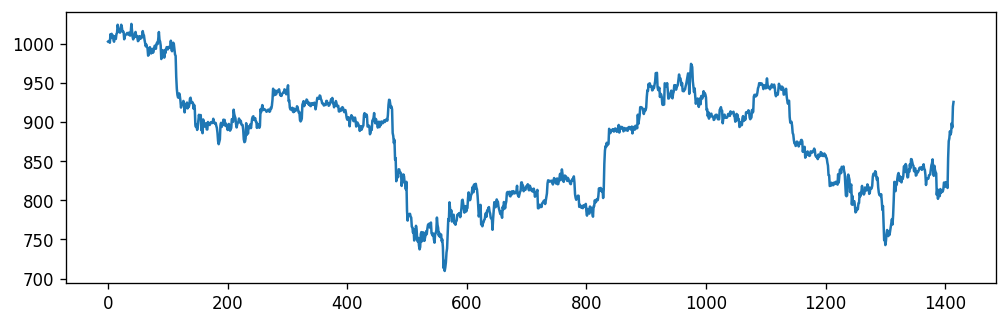

In [58]:
plt.plot(B_and_H)
print('Final Value of Buy-and-Hold for Bitcoin in 2022:',B_and_H[-2])

In [137]:
# Setting up the device

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [59]:
# Train and test splitting and scaling
X=pd.read_csv(dfs[0])

X['Date']=pd.to_datetime(X['Date']) # Setting the index as the Date
X=X.set_index('Date').asfreq('H')

X=X.dropna()
y=X['Percent Change']
X=X.drop('Label', axis=1)
X=X.drop('Percent Change', axis=1)

starting_hour = '2022-01-01 0:00:00'

# Removing the testing data
X_test=X['2022-01-01 0:00:00':] # Getting the last 6 months as the testing data
print('Confirming we have all the columns we want:','\n', X_test.columns)
y_test=y['2022-01-01 0:00:00':].values

X=X[:'2022-01-01 0:00:00'] # Getting everything but the first 6 months as the training data
y=y[:'2022-01-01 0:00:00']

Confirming we have all the columns we want: 
 Index(['BB_upper 10', 'BB_middle 10', 'BB_lower 10', 'Aroon_down 10',
       'Aroon_up 10', 'Aroonosc 10', 'RSI 10', 'NATR 10', 'BB_upper 12',
       'BB_middle 12',
       ...
       'MACD Signal 18', 'MACD Hist18', 'Med Price', 'Chaikin A/D Line',
       'HT Dom Phase', 'HT Dom Period', 'High', 'Low', 'Close', 'Volume'],
      dtype='object', length=101)


In [61]:
n_steps=12

# First, we create our PCA matrices from the X and X_test
X, X_test=PCA_creation_train_test(20, X, X_test)
    
# Getting the X and X_test matrices' images
X_train, y_train=image_creation(n_steps, X ,y)
X_test, y_test=image_creation(n_steps, X_test, y_test)
y_train=np.array(y_train)
y_test=np.array(y_test)

# Finalizing the shapes
num_classes = 2
input_shape = (n_steps, len(X[0]), 1)

# Add a dimension at the beginning end to make sure images have shape (1, n_steps, n_features)
# Note this is the OPPOSITE of tensorflow
X_train = np.expand_dims(X_train, 1)
X_test = np.expand_dims(X_test, 1)
print("X_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

X_train shape: (30646, 1, 12, 20)
30646 train samples
1403 test samples


In [143]:
# Loading an agent

agent = torch.load('Models/CNN DQN gamma_0.5 BTC.h5')
agent.eval()

DuelingDQNAgent(
  (conv_network): Sequential(
    (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (tanh): Tanh()
    (avg_pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_network): Sequential(
    (linear1): Linear(in_features=2880, out_features=512, bias=True)
    (tanh1): Tanh()
    (Dropout1): Dropout(p=0.6, inplace=False)
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (tanh2): Tanh()
    (Dropout2): Dropout(p=0.6, inplace=False)
  )
  (value): Linear(in_features=512, out_features=1, bias=True)
  (adv): Linear(in_features=512, out_features=2, bias=True)
)

In [144]:
net_worths1=investing_performance_rl('Models/CNN DQN gamma_0.5 BTC.h5', X_test, y_test, 'DQN')
net_worths1=[x[0] for x in net_worths1]
net_worths2=investing_performance_rl('Models/CNN DQN gamma_0.5 BTC.h5', X_test, y_test, 'DQN')
net_worths2=[x[0] for x in net_worths2]
net_worths3=investing_performance_rl('Models/CNN DQN gamma_0.5 BTC.h5', X_test, y_test, 'DQN')
net_worths3=[x[0] for x in net_worths3]
net_worths4=investing_performance_rl('Models/CNN DQN gamma_0.5 BTC.h5', X_test, y_test, 'DQN')
net_worths4=[x[0] for x in net_worths4]

The lengths of Buy-and-Hold and the agents are the same.
The lengths of the net worths and the Buy-and-Hold startegies are 1403 1403 1403 1403 1403
The final value with Buy-and-Hold is 919.76
Our final values for these models are: 
 1126.21 dollars, 
 1128.29 dollars, 
 995.01 dollars, 
 1147.69 dollars.


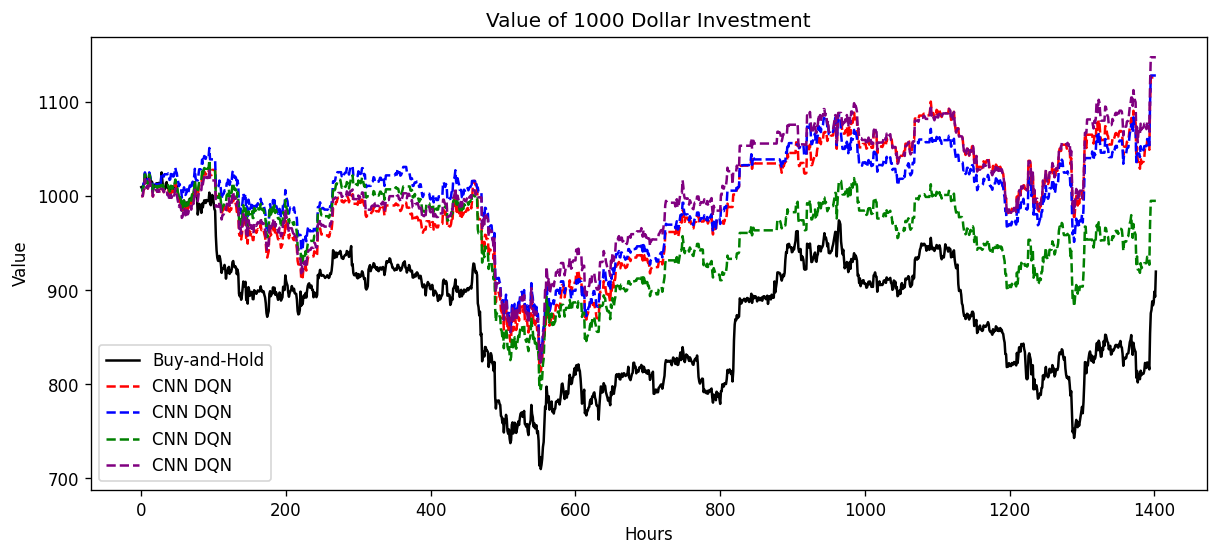

In [145]:
agents_net_worths=[net_worths1, net_worths2, net_worths3, net_worths4]
portfolio_movement_5_agents(agents_net_worths, B_and_H, 'CNN DQN', 11, -1)
print('Our final values for these models are:',
      '\n',
      round(net_worths1[-1],2), 'dollars,',
      '\n',
      round(net_worths2[-1],2), 'dollars,',
      '\n',
      round(net_worths3[-1],2), 'dollars,',
      '\n',
      round(net_worths4[-1],2), 'dollars.')

### Etherium 2022

In [70]:
# Redoing Buy-and-Hold

dfs=['Non-Scaled TA Features 1H for ETH 2022.csv']

def testing_data_pct_changes(dfs, time_frame):
    if time_frame == 'hour':
        X=pd.read_csv(dfs[0])
        X['Date']=pd.to_datetime(X['Date']) # Setting the index as the Date
        X=X.set_index('Date').asfreq('H')
        X=X.dropna()
        y=X['Percent Change']
        X=X.drop('Label', axis=1)
        X=X.drop('Percent Change', axis=1)

        # Removing the testing data
        X_test=X['2022-01-01 0:00:00':] # Getting the last 6 months as the testing data
        y_test=y['2022-01-01 0:00:00':]
    
    return X_test, y_test/100

def Buy_and_Hold(test_pct_changes, init_balance):
    curr_balance=init_balance
    balances=[]
    
    for pct_chng in test_pct_changes:
        curr_balance=curr_balance*(1+pct_chng)
        balances.append(curr_balance)
        
    return balances

init_balance=1000
_,y_test=testing_data_pct_changes(dfs, 'hour')
B_and_H=Buy_and_Hold(y_test, init_balance)
print('The length of Buy-and-Hold is:',len(B_and_H))
print('Buy-and-Hold runs from', y_test.index[0], 'to', y_test.index[-1])

The length of Buy-and-Hold is: 1415
Buy-and-Hold runs from 2022-01-01 00:00:00 to 2022-02-28 22:00:00


Final Value of Buy-and-Hold for Ethereum in 2022: 775.0371846020829


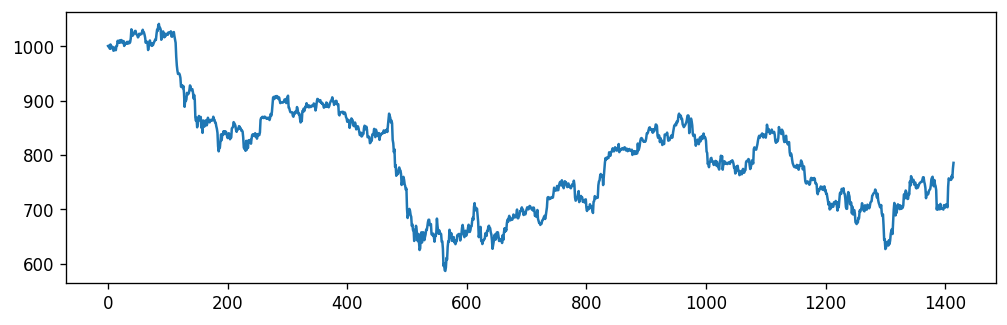

In [64]:
plt.plot(B_and_H)
print('Final Value of Buy-and-Hold for Ethereum in 2022:',B_and_H[-2])

In [148]:
# Setting up the device

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [65]:
# Train and test splitting and scaling
X=pd.read_csv(dfs[0])

X['Date']=pd.to_datetime(X['Date']) # Setting the index as the Date
X=X.set_index('Date').asfreq('H')

X=X.dropna()
y=X['Percent Change']
X=X.drop('Label', axis=1)
X=X.drop('Percent Change', axis=1)

starting_hour = '2022-01-01 0:00:00'

# Removing the testing data
X_test=X['2022-01-01 0:00:00':] # Getting the last 6 months as the testing data
print(X_test.columns)
y_test=y['2022-01-01 0:00:00':].values

X=X[:'2022-01-01 0:00:00'] # Getting everything but the first 6 months as the training data
y=y[:'2022-01-01 0:00:00']

Index(['BB_upper 10', 'BB_middle 10', 'BB_lower 10', 'Aroon_down 10',
       'Aroon_up 10', 'Aroonosc 10', 'RSI 10', 'NATR 10', 'BB_upper 12',
       'BB_middle 12',
       ...
       'MACD Signal 18', 'MACD Hist18', 'Med Price', 'Chaikin A/D Line',
       'HT Dom Phase', 'HT Dom Period', 'High', 'Low', 'Close', 'Volume'],
      dtype='object', length=101)


In [67]:
n_steps=12

# First, we create our PCA matrices from the X and X_test
X, X_test=PCA_creation_train_test(20, X, X_test)
    
# Getting the X and X_test matrices' images
X_train, y_train=image_creation(n_steps, X ,y)
X_test, y_test=image_creation(n_steps, X_test, y_test)
y_train=np.array(y_train)
y_test=np.array(y_test)

# Finalizing the shapes
num_classes = 2
input_shape = (n_steps, len(X[0]), 1)

# Add a dimension at the beginning end to make sure images have shape (1, n_steps, n_features)
# Note this is the OPPOSITE of tensorflow
X_train = np.expand_dims(X_train, 1)
X_test = np.expand_dims(X_test, 1)
print("X_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

X_train shape: (30646, 1, 12, 20)
30646 train samples
1403 test samples


In [154]:
# Loading an agent

agent = torch.load('Models/CNN DQN gamma_0.5 BTC.h5')
agent.eval()

DuelingDQNAgent(
  (conv_network): Sequential(
    (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (tanh): Tanh()
    (avg_pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_network): Sequential(
    (linear1): Linear(in_features=2880, out_features=512, bias=True)
    (tanh1): Tanh()
    (Dropout1): Dropout(p=0.6, inplace=False)
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (tanh2): Tanh()
    (Dropout2): Dropout(p=0.6, inplace=False)
  )
  (value): Linear(in_features=512, out_features=1, bias=True)
  (adv): Linear(in_features=512, out_features=2, bias=True)
)

In [155]:
net_worths1=investing_performance_rl('Models/CNN DQN gamma_0.5 BTC.h5', X_test, y_test, 'DQN')
net_worths1=[x[0] for x in net_worths1]
net_worths2=investing_performance_rl('Models/CNN DQN gamma_0.5 BTC.h5', X_test, y_test, 'DQN')
net_worths2=[x[0] for x in net_worths2]
net_worths3=investing_performance_rl('Models/CNN DQN gamma_0.5 BTC.h5', X_test, y_test, 'DQN')
net_worths3=[x[0] for x in net_worths3]
net_worths4=investing_performance_rl('Models/CNN DQN gamma_0.5 BTC.h5', X_test, y_test, 'DQN')
net_worths4=[x[0] for x in net_worths4]

The lengths of Buy-and-Hold and the agents are the same.
The lengths of the net worths and the Buy-and-Hold startegies are 1403 1403 1403 1403 1403
The final value with Buy-and-Hold is 775.04
Our final values for these models are: 
 842.82 dollars, 
 921.2 dollars, 
 886.63 dollars, 
 940.6 dollars.


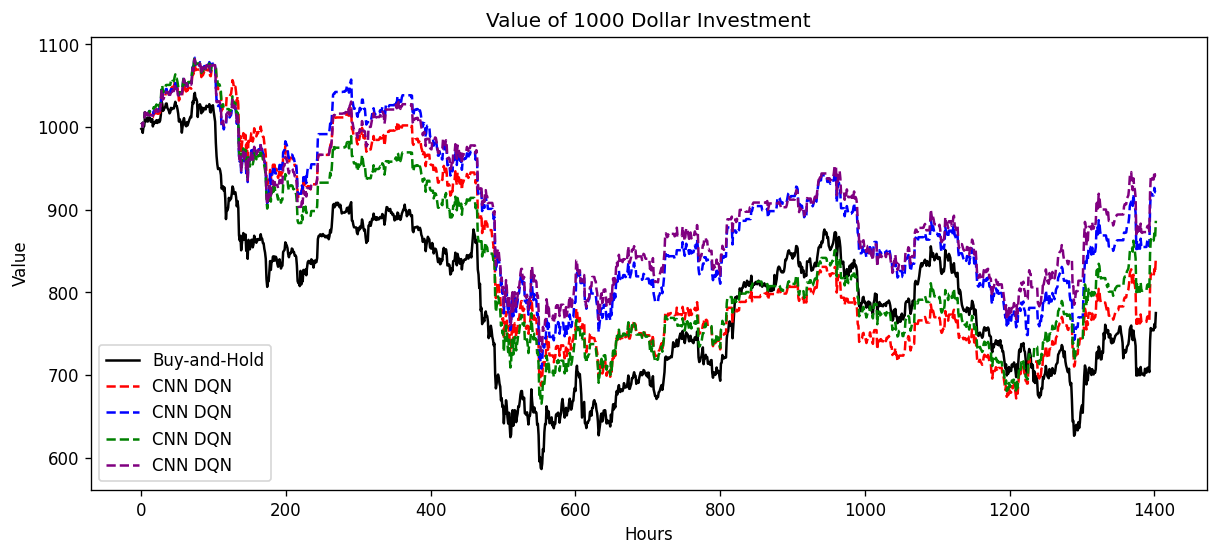

In [156]:
agents_net_worths=[net_worths1, net_worths2, net_worths3, net_worths4]
portfolio_movement_5_agents(agents_net_worths, B_and_H, 'CNN DQN', 11, -1)
print('Our final values for these models are:',
      '\n',
      round(net_worths1[-1],2), 'dollars,',
      '\n',
      round(net_worths2[-1],2), 'dollars,',
      '\n',
      round(net_worths3[-1],2), 'dollars,',
      '\n',
      round(net_worths4[-1],2), 'dollars.')

### LTC 2022

In [71]:
# Redoing Buy-and-Hold

dfs=['Non-Scaled TA Features 1H for LTC 2022.csv']

def testing_data_pct_changes(dfs, time_frame):
    if time_frame == 'hour':
        X=pd.read_csv(dfs[0])
        X['Date']=pd.to_datetime(X['Date']) # Setting the index as the Date
        X=X.set_index('Date').asfreq('H')
        X=X.dropna()
        y=X['Percent Change']
        X=X.drop('Label', axis=1)
        X=X.drop('Percent Change', axis=1)

        # Removing the testing data
        X_test=X['2022-01-01 0:00:00':] # Getting the last 6 months as the testing data
        y_test=y['2022-01-01 0:00:00':]
 
    return X_test, y_test/100

def Buy_and_Hold(test_pct_changes, init_balance):
    curr_balance=init_balance
    balances=[]
    
    for pct_chng in test_pct_changes:
        curr_balance=curr_balance*(1+pct_chng)
        balances.append(curr_balance)
        
    return balances

init_balance=1000
_,y_test=testing_data_pct_changes(dfs, 'hour')
B_and_H=Buy_and_Hold(y_test, init_balance)
print('The length of Buy-and-Hold is:',len(B_and_H))
print('Buy-and-Hold runs from', y_test.index[0], 'to', y_test.index[-1])

The length of Buy-and-Hold is: 1415
Buy-and-Hold runs from 2022-01-01 00:00:00 to 2022-02-28 22:00:00


Final Value of Buy-and-Hold for Litecoin in 2022: 750.8727175080562


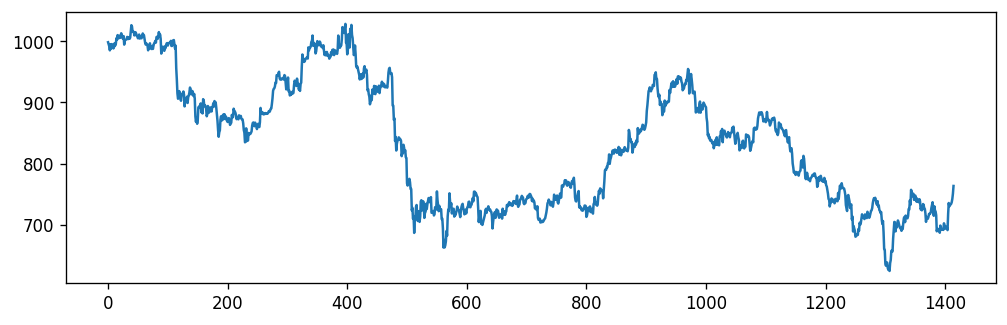

In [72]:
plt.plot(B_and_H)
print('Final Value of Buy-and-Hold for Litecoin in 2022:',B_and_H[-2])

In [159]:
# Setting up the device

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [74]:
# Train and test splitting and scaling
X=pd.read_csv(dfs[0])

X['Date']=pd.to_datetime(X['Date']) # Setting the index as the Date
X=X.set_index('Date').asfreq('H')

X=X.dropna()
y=X['Percent Change']
X=X.drop('Label', axis=1)
X=X.drop('Percent Change', axis=1)

starting_hour = '2022-01-01 0:00:00'

# Removing the testing data
X_test=X['2022-01-01 0:00:00':] # Getting the last 6 months as the testing data
print('Confirming we have all the columns we want:','\n', X_test.columns)
y_test=y['2022-01-01 0:00:00':].values

X=X[:'2022-01-01 0:00:00'] # Getting everything but the first 6 months as the training data
y=y[:'2022-01-01 0:00:00']

Confirming we have all the columns we want: 
 Index(['BB_upper 10', 'BB_middle 10', 'BB_lower 10', 'Aroon_down 10',
       'Aroon_up 10', 'Aroonosc 10', 'RSI 10', 'NATR 10', 'BB_upper 12',
       'BB_middle 12',
       ...
       'MACD Signal 18', 'MACD Hist18', 'Med Price', 'Chaikin A/D Line',
       'HT Dom Phase', 'HT Dom Period', 'High', 'Low', 'Close', 'Volume'],
      dtype='object', length=101)


In [76]:
n_steps=12

# First, we create our PCA matrices from the X and X_test
X, X_test=PCA_creation_train_test(20, X, X_test)
    
# Getting the X and X_test matrices' images
X_train, y_train=image_creation(n_steps, X ,y)
X_test, y_test=image_creation(n_steps, X_test, y_test)
y_train=np.array(y_train)
y_test=np.array(y_test)

# Finalizing the shapes
num_classes = 2
input_shape = (n_steps, len(X[0]), 1)

# Add a dimension at the beginning end to make sure images have shape (1, n_steps, n_features)
# Note this is the OPPOSITE of tensorflow
X_train = np.expand_dims(X_train, 1)
X_test = np.expand_dims(X_test, 1)
print("X_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

X_train shape: (30646, 1, 12, 20)
30646 train samples
1403 test samples


In [165]:
# Loading an agent

agent = torch.load('Models/CNN DQN gamma_0.5 BTC.h5')
agent.eval()

DuelingDQNAgent(
  (conv_network): Sequential(
    (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (tanh): Tanh()
    (avg_pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_network): Sequential(
    (linear1): Linear(in_features=2880, out_features=512, bias=True)
    (tanh1): Tanh()
    (Dropout1): Dropout(p=0.6, inplace=False)
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (tanh2): Tanh()
    (Dropout2): Dropout(p=0.6, inplace=False)
  )
  (value): Linear(in_features=512, out_features=1, bias=True)
  (adv): Linear(in_features=512, out_features=2, bias=True)
)

In [166]:
net_worths1=investing_performance_rl('Models/CNN DQN gamma_0.5 BTC.h5', X_test, y_test, 'DQN')
net_worths1=[x[0] for x in net_worths1]
net_worths2=investing_performance_rl('Models/CNN DQN gamma_0.5 BTC.h5', X_test, y_test, 'DQN')
net_worths2=[x[0] for x in net_worths2]
net_worths3=investing_performance_rl('Models/CNN DQN gamma_0.5 BTC.h5', X_test, y_test, 'DQN')
net_worths3=[x[0] for x in net_worths3]
net_worths4=investing_performance_rl('Models/CNN DQN gamma_0.5 BTC.h5', X_test, y_test, 'DQN')
net_worths4=[x[0] for x in net_worths4]

The lengths of Buy-and-Hold and the agents are the same.
The lengths of the net worths and the Buy-and-Hold startegies are 1403 1403 1403 1403 1403
The final value with Buy-and-Hold is 750.87
Our final values for these models are: 
 707.65 dollars, 
 731.55 dollars, 
 701.84 dollars, 
 678.21 dollars.


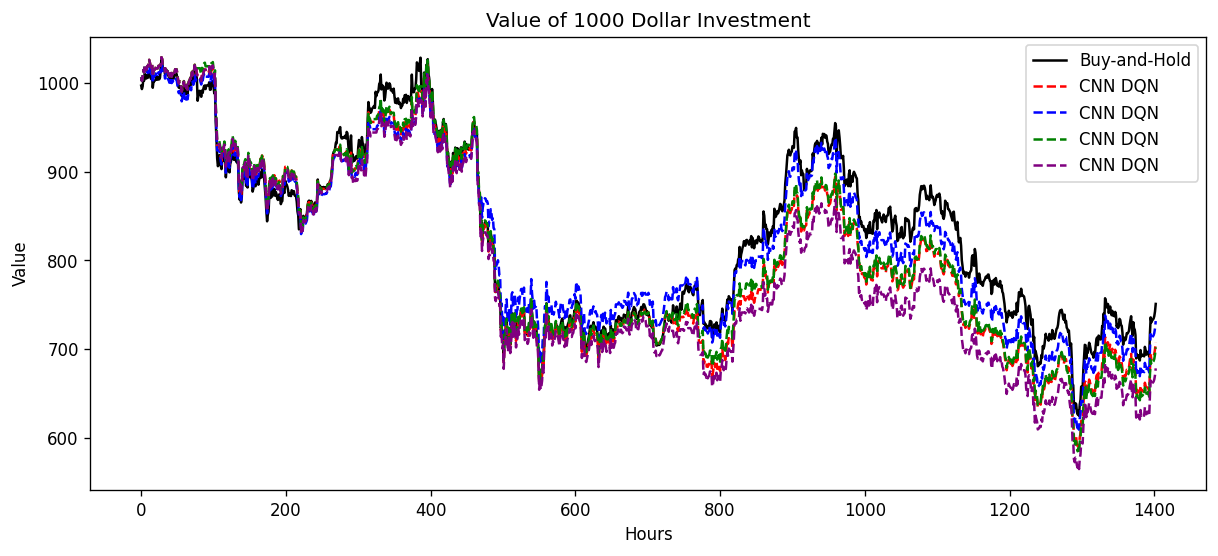

In [167]:
agents_net_worths=[net_worths1, net_worths2, net_worths3, net_worths4]
portfolio_movement_5_agents(agents_net_worths, B_and_H, 'CNN DQN', 11, -1)
print('Our final values for these models are:',
      '\n',
      round(net_worths1[-1],2), 'dollars,',
      '\n',
      round(net_worths2[-1],2), 'dollars,',
      '\n',
      round(net_worths3[-1],2), 'dollars,',
      '\n',
      round(net_worths4[-1],2), 'dollars.')

## CNN Based T3D

### Bitcoin

Note, to avoid duplicating cells and increasing the length of this script without warrant, we have included only the image_creation function, Actor class, QFunction class, and the ActorCritic class evaluation function in this first Bitcoin section. To run the other coins, one would need to run the cells with these functions so they can be ready.

In [19]:
# Importing the data

dfs=['Non-Scaled TA Features 1H for BTC.csv']

In [31]:
# Train and test splitting and scaling
X=pd.read_csv(dfs[0])

X['Date']=pd.to_datetime(X['Date']) # Setting the index as the Date
X=X.set_index('Date').asfreq('H')

X=X.dropna()
y=X['Percent Change']
X=X.drop('Label', axis=1)
X=X.drop('Percent Change', axis=1)


# Removing the testing data
X_test=X[-4380:] # Getting the last 6 months as the testing data
print('Confirming we have all the columns we want:','\n', X_test.columns)
y_test=y[-4380:].values

X=X[:-4380] # Getting everything but the first 6 months as the training data
y=y[:-4380]

Confirming we have all the columns we want: 
 Index(['BB_upper 10', 'BB_middle 10', 'BB_lower 10', 'Aroon_down 10',
       'Aroon_up 10', 'Aroonosc 10', 'RSI 10', 'NATR 10', 'BB_upper 12',
       'BB_middle 12',
       ...
       'MACD Signal 18', 'MACD Hist18', 'Med Price', 'Chaikin A/D Line',
       'HT Dom Phase', 'HT Dom Period', 'High', 'Low', 'Close', 'Volume'],
      dtype='object', length=101)


In [32]:
# Image creation function

def image_creation(n_steps, X, y):
    X_images=[]
    y_values=[]
    
    for i in range(n_steps, len(X)):
        img=X[i-n_steps,:]
        img=np.vstack((img, X[i-n_steps+1,:]))
        img=np.vstack((img, X[i-n_steps+2,:]))
        img=np.vstack((img, X[i-n_steps+3,:]))
        img=np.vstack((img, X[i-n_steps+4,:]))
        img=np.vstack((img, X[i-n_steps+5,:]))
        img=np.vstack((img, X[i-n_steps+6,:]))
        img=np.vstack((img, X[i-n_steps+7,:]))
        img=np.vstack((img, X[i-n_steps+8,:]))
        img=np.vstack((img, X[i-n_steps+9,:]))
        img=np.vstack((img, X[i-n_steps+10,:]))
        img=np.vstack((img, X[i-n_steps+11,:]))
        X_images.append(img)
        y_values.append(y[i-n_steps+11])
        
    return X_images, np.array(y_values) # Note, this will not include the very last one.

In [33]:
n_steps=12

# First, we create our PCA matrices from the X and X_test
X, X_test=PCA_creation_train_test(20, X, X_test)
    
# Getting the X and X_test matrices' images
X_train, y_train=image_creation(n_steps, X ,y)
X_test, y_test=image_creation(n_steps, X_test, y_test)
y_train=np.array(y_train)
y_test=np.array(y_test)

# Finalizing the shapes
num_classes = 2
input_shape = (n_steps, len(X[0]), 1)

# Add a dimension at the beginning end to make sure images have shape (1, n_steps, n_features)
# Note this is the OPPOSITE of tensorflow
X_train = np.expand_dims(X_train, 1)
X_test = np.expand_dims(X_test, 1)
print("X_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

X_train shape: (26264, 1, 12, 20)
26264 train samples
4368 test samples


In [34]:
class Actor(nn.Module):
    def __init__(self, state_dim, act_dim, act_limit):
        super().__init__()
        self.act_limit = act_limit
        
        
        # Conv and Pooling Layer
        self.conv_network = nn.Sequential()
        self.conv_network.add_module('conv', nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=0)) # 'Valid' padding
        self.conv_network.add_module('tanh', nn.Tanh())
        self.conv_network.add_module('avg_pool', nn.AvgPool2d(kernel_size=2, stride=2, padding=0))
        self.conv_network.add_module('flatten', nn.Flatten())

        self.fc_network = nn.Sequential()
        self.fc_network.add_module('linear1', nn.Linear(2880, 512))
        self.fc_network.add_module('tanh1', nn.Tanh())
        self.fc_network.add_module('Dropout1', nn.Dropout(0.6))
        self.fc_network.add_module('linear2', nn.Linear(512, 512))
        self.fc_network.add_module('tanh2', nn.Tanh())
        self.fc_network.add_module('Dropout2', nn.Dropout(0.6))
        
        self.actor = nn.Linear(512, act_dim)
    
    def forward(self, s):
        # Because it keeps adding a dimension, we need to be careful that we always know how many
        # dimensions we are feeding to our CNN
        if len(s.shape) == 3:
            state = torch.unsqueeze(s, 1)
        if len(s.shape) == 4:
            state = s
        # Conv and Pool Layer
        x = self.conv_network(state)
        # MLP Layer
        x = self.fc_network(x)
        # Getting our Action
        x = self.actor(x)
        # Getting our Action in the form we want
        x = torch.tanh(x)  # to output in range(-1,1)
        x = self.act_limit * x
        return x


In [35]:
class QFunction(nn.Module):
    def __init__(self, state_dim, act_dim):
        super().__init__()
        
        # Conv and Pooling Layer
        self.conv_network = nn.Sequential()
        self.conv_network.add_module('conv', nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=0)) # 'Valid' padding
        self.conv_network.add_module('tanh', nn.Tanh())
        self.conv_network.add_module('avg_pool', nn.AvgPool2d(kernel_size=2, stride=2, padding=0))
        self.conv_network.add_module('flatten', nn.Flatten())

        self.fc_network = nn.Sequential()
        self.fc_network.add_module('linear1', nn.Linear(2880, 512))
        self.fc_network.add_module('tanh1', nn.Tanh())
        self.fc_network.add_module('Dropout1', nn.Dropout(0.6))
        self.fc_network.add_module('linear2', nn.Linear(512, 512))
        self.fc_network.add_module('tanh2', nn.Tanh())
        self.fc_network.add_module('Dropout2', nn.Dropout(0.6))
        
        self.critic = nn.Linear(513, 1) # We added the Action at the end
    
    def forward(self, s, a):

        # Conv and Pool Layer
        y = self.conv_network(s)
        # MLP Layer
        y = self.fc_network(y)
        # Adding our Action
        y = torch.cat([y,a], dim=-1)
        # Getting our critique
        q = self.critic(y)
        return torch.squeeze(q, -1)
        

In [36]:
class ActorCritic(nn.Module):
    def __init__(self, observation_space, action_space):
        super().__init__()
        self.state_dim = len(observation_space)
        self.act_dim = action_space.shape[0]
        self.act_limit = action_space.high[0]
        
        #build Q and policy functions
        self.q1 = MLPQFunction(self.state_dim, self.act_dim)
        self.q2 = MLPQFunction(self.state_dim, self.act_dim)
        self.policy = MLPActor(self.state_dim, self.act_dim, self.act_limit)
        
    def act(self, state):
        with torch.no_grad():
            return self.policy(state).numpy()

    def get_action(self, s, noise_scale):
        a = self.act(torch.as_tensor(s, dtype=torch.float32))
        a += noise_scale * np.random.randn(self.act_dim)
        return np.clip(a, -self.act_limit, self.act_limit)
        

In [61]:
# Loading an agent

agent = torch.load('Models/CNN T3D gamma_0.5 BTC.h5')

In [212]:
net_worths1=investing_performance_rl('Models/CNN T3D gamma_0.25 BTC.h5', X_test, y_test, 'T3D')
net_worths1=[x[0] for x in net_worths1]
net_worths2=investing_performance_rl('Models/CNN T3D gamma_0.25 BTC.h5', X_test, y_test, 'T3D')
net_worths2=[x[0] for x in net_worths2]
net_worths3=investing_performance_rl('Models/CNN T3D gamma_0.25 BTC.h5', X_test, y_test, 'T3D')
net_worths3=[x[0] for x in net_worths3]
net_worths4=investing_performance_rl('Models/CNN T3D gamma_0.25 BTC.h5', X_test, y_test, 'T3D')
net_worths4=[x[0] for x in net_worths4]

The lengths of Buy-and-Hold and the agents are the same.
The lengths of the net worths and the Buy-and-Hold startegies are 4368 4368 4368 4368 4368
The final value with Buy-and-Hold is 1402.49
Our final values for these models are: 
 1437.11 dollars, 
 1461.73 dollars, 
 1418.37 dollars, 
 1400.9 dollars.


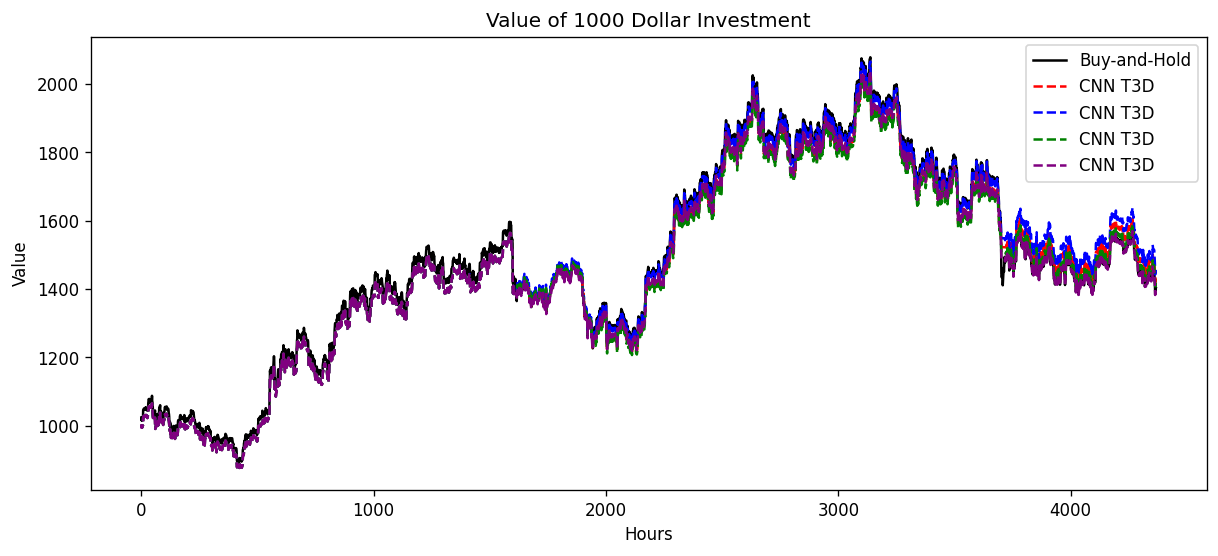

In [213]:
agents_net_worths=[net_worths1, net_worths2, net_worths3, net_worths4]
portfolio_movement_5_agents(agents_net_worths, B_and_H, 'CNN T3D', 11, -1)
print('Our final values for these models are:',
      '\n',
      round(net_worths1[-1],2), 'dollars,',
      '\n',
      round(net_worths2[-1],2), 'dollars,',
      '\n',
      round(net_worths3[-1],2), 'dollars,',
      '\n',
      round(net_worths4[-1],2), 'dollars.')

### Ethereum

In [38]:
# Redoing Buy-and-Hold

dfs=['Non-Scaled TA Features 1H for ETH.csv']

def Buy_and_Hold(test_pct_changes, init_balance):
    curr_balance=init_balance
    balances=[]
    
    for pct_chng in test_pct_changes:
        curr_balance=curr_balance*(1+pct_chng)
        balances.append(curr_balance)
        
    return balances

init_balance=1000
_,y_test=testing_data_pct_changes(dfs, 'hour')
B_and_H=Buy_and_Hold(y_test, init_balance)
print('The length of Buy-and-Hold is:',len(B_and_H))
print('Buy-and-Hold runs from', y_test.index[0], 'to', y_test.index[-1])

The length of Buy-and-Hold is: 4380
Buy-and-Hold runs from 2021-07-02 11:00:00 to 2021-12-31 22:00:00


Final Value of Buy-and-Hold for Ethereum: 1806.4954430851626


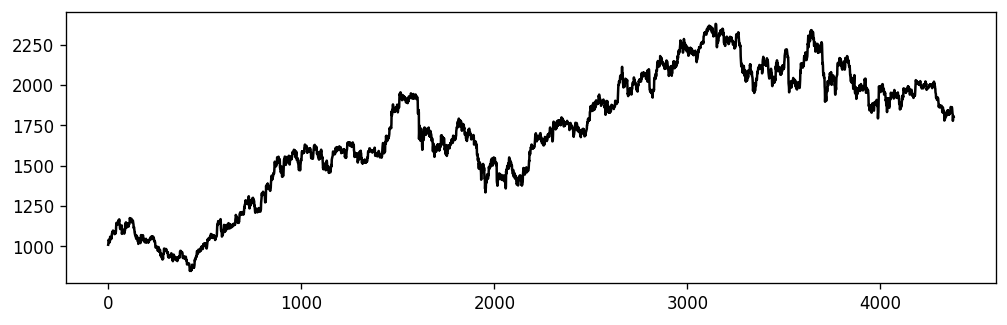

In [39]:
plt.plot(B_and_H, color='black')
print('Final Value of Buy-and-Hold for Ethereum:',B_and_H[-2])

In [40]:
# Train and test splitting and scaling
X=pd.read_csv(dfs[0])

X['Date']=pd.to_datetime(X['Date']) # Setting the index as the Date
X=X.set_index('Date').asfreq('H')

X=X.dropna()
y=X['Percent Change']
X=X.drop('Label', axis=1)
X=X.drop('Percent Change', axis=1)


# Removing the testing data
X_test=X[-4380:] # Getting the last 6 months as the testing data
print('Confirming we have all the columns we want:','\n', X_test.columns)
y_test=y[-4380:].values

X=X[:-4380] # Getting everything but the first 6 months as the training data
y=y[:-4380]

Confirming we have all the columns we want: 
 Index(['BB_upper 10', 'BB_middle 10', 'BB_lower 10', 'Aroon_down 10',
       'Aroon_up 10', 'Aroonosc 10', 'RSI 10', 'NATR 10', 'BB_upper 12',
       'BB_middle 12',
       ...
       'MACD Signal 18', 'MACD Hist18', 'Med Price', 'Chaikin A/D Line',
       'HT Dom Phase', 'HT Dom Period', 'High', 'Low', 'Close', 'Volume'],
      dtype='object', length=101)


In [41]:
n_steps=12

# First, we create our PCA matrices from the X and X_test
X, X_test=PCA_creation_train_test(20, X, X_test)
    
# Getting the X and X_test matrices' images
X_train, y_train=image_creation(n_steps, X ,y)
X_test, y_test=image_creation(n_steps, X_test, y_test)
y_train=np.array(y_train)
y_test=np.array(y_test)

# Finalizing the shapes
num_classes = 2
input_shape = (n_steps, len(X[0]), 1)

# Add a dimension at the beginning end to make sure images have shape (1, n_steps, n_features)
# Note this is the OPPOSITE of tensorflow
X_train = np.expand_dims(X_train, 1)
X_test = np.expand_dims(X_test, 1)
print("X_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

X_train shape: (26264, 1, 12, 20)
26264 train samples
4368 test samples


In [62]:
# Loading an agent

agent = torch.load('Models/CNN T3D gamma_0.25 BTC.h5')

In [224]:
net_worths1=investing_performance_rl('Models/CNN T3D gamma_0.25 BTC.h5', X_test, y_test, 'T3D')
net_worths1=[x[0] for x in net_worths1]
net_worths2=investing_performance_rl('Models/CNN T3D gamma_0.25 BTC.h5', X_test, y_test, 'T3D')
net_worths2=[x[0] for x in net_worths2]
net_worths3=investing_performance_rl('Models/CNN T3D gamma_0.25 BTC.h5', X_test, y_test, 'T3D')
net_worths3=[x[0] for x in net_worths3]
net_worths4=investing_performance_rl('Models/CNN T3D gamma_0.25 BTC.h5', X_test, y_test, 'T3D')
net_worths4=[x[0] for x in net_worths4]

The lengths of Buy-and-Hold and the agents are the same.
The lengths of the net worths and the Buy-and-Hold startegies are 4368 4368 4368 4368 4368
The final value with Buy-and-Hold is 1806.5
Our final values for these models are: 
 1625.8811 dollars, 
 1629.6217 dollars, 
 1641.5442 dollars, 
 1628.1102 dollars.


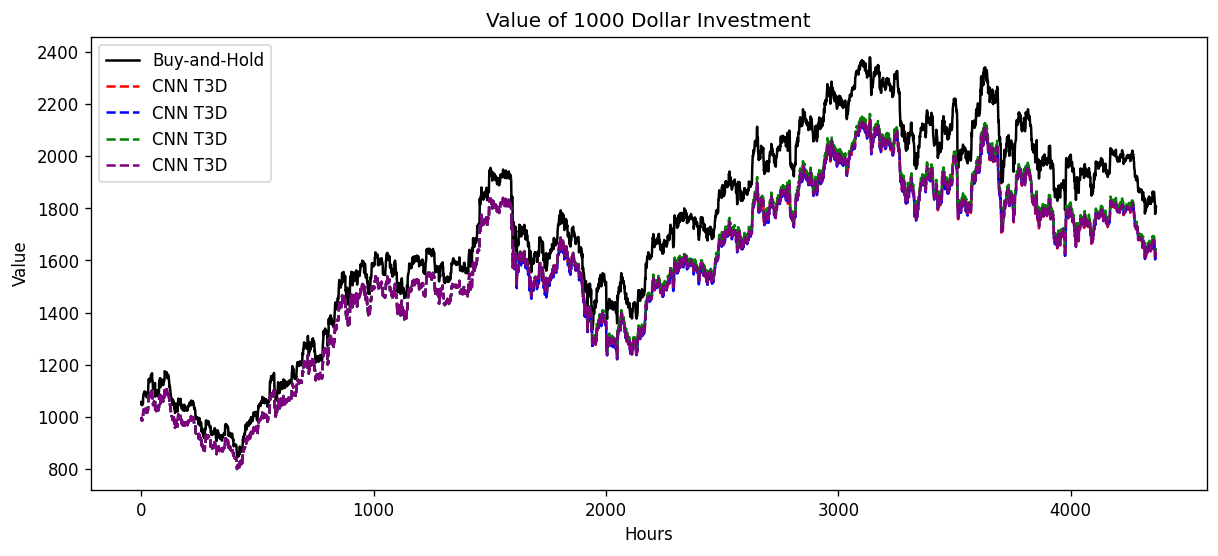

In [225]:
agents_net_worths=[net_worths1, net_worths2, net_worths3, net_worths4]
portfolio_movement_5_agents(agents_net_worths, B_and_H, 'CNN T3D', 11, -1)
print('Our final values for these models are:',
      '\n',
      round(net_worths1[-1],5), 'dollars,',
      '\n',
      round(net_worths2[-1],5), 'dollars,',
      '\n',
      round(net_worths3[-1],5), 'dollars,',
      '\n',
      round(net_worths4[-1],5), 'dollars.')

### Litecoin

In [42]:
# Redoing Buy-and-Hold

dfs=['Non-Scaled TA Features 1H for LTC.csv']

def Buy_and_Hold(test_pct_changes, init_balance):
    curr_balance=init_balance
    balances=[]
    
    for pct_chng in test_pct_changes:
        curr_balance=curr_balance*(1+pct_chng)
        balances.append(curr_balance)
        
    return balances

init_balance=1000
_,y_test=testing_data_pct_changes(dfs, 'hour')
B_and_H=Buy_and_Hold(y_test, init_balance)
print('The length of Buy-and-Hold is:',len(B_and_H))
print('Buy-and-Hold runs from', y_test.index[0], 'to', y_test.index[-1])

The length of Buy-and-Hold is: 4380
Buy-and-Hold runs from 2021-07-02 11:00:00 to 2021-12-31 22:00:00


Final Value of Buy-and-Hold for Litecoin: 1111.2631098951204


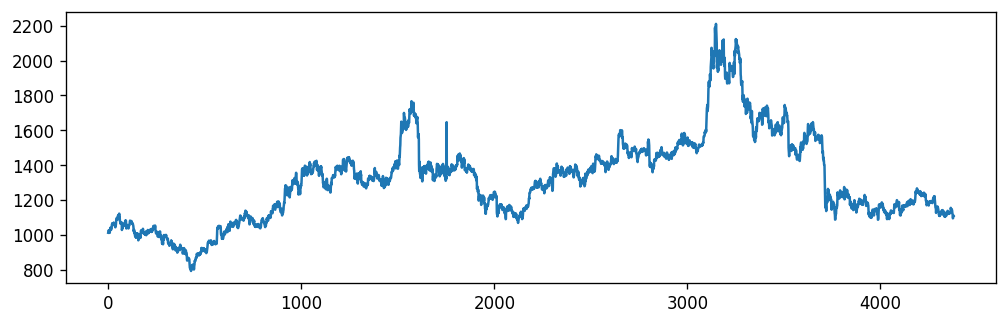

In [43]:
plt.plot(B_and_H)
print('Final Value of Buy-and-Hold for Litecoin:',B_and_H[-2])

In [44]:
# Train and test splitting and scaling
X=pd.read_csv(dfs[0])

X['Date']=pd.to_datetime(X['Date']) # Setting the index as the Date
X=X.set_index('Date').asfreq('H')

X=X.dropna()
y=X['Percent Change']
X=X.drop('Label', axis=1)
X=X.drop('Percent Change', axis=1)


# Removing the testing data
X_test=X[-4380:] # Getting the last 6 months as the testing data
print('Confirming we have all the columns we want:','\n', X_test.columns)
y_test=y[-4380:].values

X=X[:-4380] # Getting everything but the first 6 months as the training data
y=y[:-4380]

Confirming we have all the columns we want: 
 Index(['BB_upper 10', 'BB_middle 10', 'BB_lower 10', 'Aroon_down 10',
       'Aroon_up 10', 'Aroonosc 10', 'RSI 10', 'NATR 10', 'BB_upper 12',
       'BB_middle 12',
       ...
       'MACD Signal 18', 'MACD Hist18', 'Med Price', 'Chaikin A/D Line',
       'HT Dom Phase', 'HT Dom Period', 'High', 'Low', 'Close', 'Volume'],
      dtype='object', length=101)


In [45]:
n_steps=12

# First, we create our PCA matrices from the X and X_test
X, X_test=PCA_creation_train_test(20, X, X_test)
    
# Getting the X and X_test matrices' images
X_train, y_train=image_creation(n_steps, X ,y)
X_test, y_test=image_creation(n_steps, X_test, y_test)
y_train=np.array(y_train)
y_test=np.array(y_test)

# Finalizing the shapes
num_classes = 2
input_shape = (n_steps, len(X[0]), 1)

# Add a dimension at the beginning end to make sure images have shape (1, n_steps, n_features)
# Note this is the OPPOSITE of tensorflow
X_train = np.expand_dims(X_train, 1)
X_test = np.expand_dims(X_test, 1)
print("X_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

X_train shape: (26264, 1, 12, 20)
26264 train samples
4368 test samples


In [63]:
# Loading an agent

agent = torch.load('Models/CNN T3D gamma_0.25 BTC.h5')

In [236]:
net_worths1=investing_performance_rl('Models/CNN T3D gamma_0.25 BTC.h5', X_test, y_test, 'T3D')
net_worths1=[x[0] for x in net_worths1]
net_worths2=investing_performance_rl('Models/CNN T3D gamma_0.25 BTC.h5', X_test, y_test, 'T3D')
net_worths2=[x[0] for x in net_worths2]
net_worths3=investing_performance_rl('Models/CNN T3D gamma_0.25 BTC.h5', X_test, y_test, 'T3D')
net_worths3=[x[0] for x in net_worths3]
net_worths4=investing_performance_rl('Models/CNN T3D gamma_0.25 BTC.h5', X_test, y_test, 'T3D')
net_worths4=[x[0] for x in net_worths4]

The lengths of Buy-and-Hold and the agents are the same.
The lengths of the net worths and the Buy-and-Hold startegies are 4368 4368 4368 4368 4368
The final value with Buy-and-Hold is 1111.26
Our final values for these models are: 
 1047.24 dollars, 
 1070.6763 dollars, 
 1035.0989 dollars, 
 1010.8948 dollars.


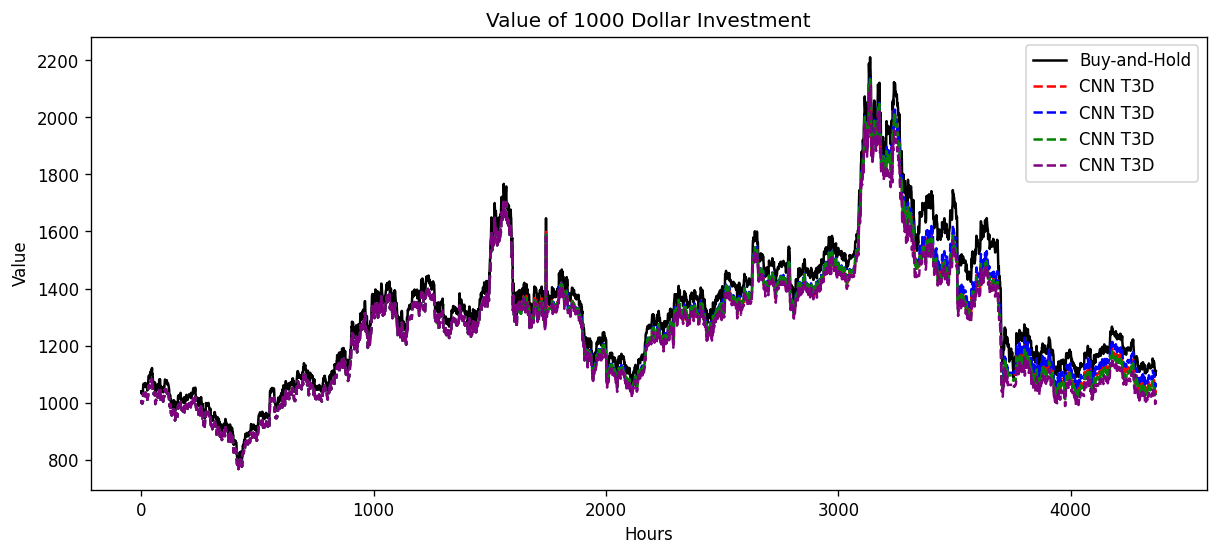

In [237]:
agents_net_worths=[net_worths1, net_worths2, net_worths3, net_worths4]
portfolio_movement_5_agents(agents_net_worths, B_and_H, 'CNN T3D', 11, -1)
print('Our final values for these models are:',
      '\n',
      round(net_worths1[-1],5), 'dollars,',
      '\n',
      round(net_worths2[-1],5), 'dollars,',
      '\n',
      round(net_worths3[-1],5), 'dollars,',
      '\n',
      round(net_worths4[-1],5), 'dollars.')

### Bitcoin in 2022

Note, we redo the testing_data_pct_changes function for 2022. To avoid issues, if one wishes to rerun an earlier coin up to the end of 2021, they would need to rerun Section 2, Importing the Data Functions. They should also make sure to run the various functions missing in these sections mentioned in 7.2.1.

In [46]:
# Redoing Buy-and-Hold

dfs=['Non-Scaled TA Features 1H for BTC 2022.csv']

def testing_data_pct_changes(dfs, time_frame):
    if time_frame == 'hour':
        X=pd.read_csv(dfs[0])
        X['Date']=pd.to_datetime(X['Date']) # Setting the index as the Date
        X=X.set_index('Date').asfreq('H')
        X=X.dropna()
        y=X['Percent Change']
        X=X.drop('Label', axis=1)
        X=X.drop('Percent Change', axis=1)

        # Removing the testing data
        X_test=X['2022-01-01 0:00:00':] # Getting the last 6 months as the testing data
        y_test=y['2022-01-01 0:00:00':]

    return X_test, y_test/100

def Buy_and_Hold(test_pct_changes, init_balance):
    curr_balance=init_balance
    balances=[]
    
    for pct_chng in test_pct_changes:
        curr_balance=curr_balance*(1+pct_chng)
        balances.append(curr_balance)
        
    return balances

init_balance=1000
_,y_test=testing_data_pct_changes(dfs, 'hour')
B_and_H=Buy_and_Hold(y_test, init_balance)
print('The length of Buy-and-Hold is:',len(B_and_H))
print('Buy-and-Hold runs from', y_test.index[0], 'to', y_test.index[-1])

The length of Buy-and-Hold is: 1415
Buy-and-Hold runs from 2022-01-01 00:00:00 to 2022-02-28 22:00:00


Final Value with Buy-and-Hold for Bitcoin in 2022: 919.7580484391881


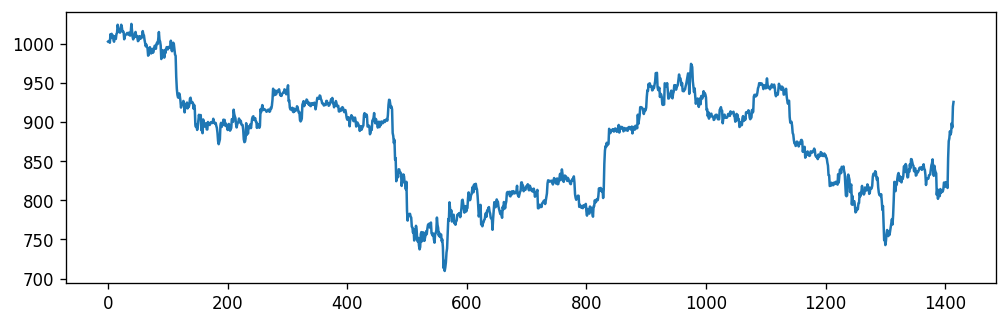

In [47]:
plt.plot(B_and_H)
print('Final Value with Buy-and-Hold for Bitcoin in 2022:',B_and_H[-2])

In [49]:
# Train and test splitting and scaling
X=pd.read_csv(dfs[0])

X['Date']=pd.to_datetime(X['Date']) # Setting the index as the Date
X=X.set_index('Date').asfreq('H')

X=X.dropna()
y=X['Percent Change']
X=X.drop('Label', axis=1)
X=X.drop('Percent Change', axis=1)

starting_hour = '2022-01-01 0:00:00'

# Removing the testing data
X_test=X['2022-01-01 0:00:00':] # Getting the last 6 months as the testing data
print('Confirming we have all the columns we want:','\n', X_test.columns)
y_test=y['2022-01-01 0:00:00':].values

X=X[:'2022-01-01 0:00:00'] # Getting everything but the first 6 months as the training data
y=y[:'2022-01-01 0:00:00']

Confirming we have all the columns we want: 
 Index(['BB_upper 10', 'BB_middle 10', 'BB_lower 10', 'Aroon_down 10',
       'Aroon_up 10', 'Aroonosc 10', 'RSI 10', 'NATR 10', 'BB_upper 12',
       'BB_middle 12',
       ...
       'MACD Signal 18', 'MACD Hist18', 'Med Price', 'Chaikin A/D Line',
       'HT Dom Phase', 'HT Dom Period', 'High', 'Low', 'Close', 'Volume'],
      dtype='object', length=101)


In [50]:
n_steps=12

# First, we create our PCA matrices from the X and X_test
X, X_test=PCA_creation_train_test(20, X, X_test)
    
# Getting the X and X_test matrices' images
X_train, y_train=image_creation(n_steps, X ,y)
X_test, y_test=image_creation(n_steps, X_test, y_test)
y_train=np.array(y_train)
y_test=np.array(y_test)

# Finalizing the shapes
num_classes = 2
input_shape = (n_steps, len(X[0]), 1)

# Add a dimension at the beginning end to make sure images have shape (1, n_steps, n_features)
# Note this is the OPPOSITE of tensorflow
X_train = np.expand_dims(X_train, 1)
X_test = np.expand_dims(X_test, 1)
print("X_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

X_train shape: (30646, 1, 12, 20)
30646 train samples
1403 test samples


In [64]:
# Loading an agent

agent = torch.load('Models/CNN T3D gamma_0.25 BTC.h5')

In [247]:
net_worths1=investing_performance_rl('Models/CNN T3D gamma_0.25 BTC.h5', X_test, y_test, 'T3D')
net_worths1=[x[0] for x in net_worths1]
net_worths2=investing_performance_rl('Models/CNN T3D gamma_0.25 BTC.h5', X_test, y_test, 'T3D')
net_worths2=[x[0] for x in net_worths2]
net_worths3=investing_performance_rl('Models/CNN T3D gamma_0.25 BTC.h5', X_test, y_test, 'T3D')
net_worths3=[x[0] for x in net_worths3]
net_worths4=investing_performance_rl('Models/CNN T3D gamma_0.25 BTC.h5', X_test, y_test, 'T3D')
net_worths4=[x[0] for x in net_worths4]

The lengths of Buy-and-Hold and the agents are the same.
The lengths of the net worths and the Buy-and-Hold startegies are 1403 1403 1403 1403 1403
The final value with Buy-and-Hold is 919.76
Our final values for these models are: 
 917.582 dollars, 
 911.23785 dollars, 
 911.7316 dollars, 
 917.458 dollars.


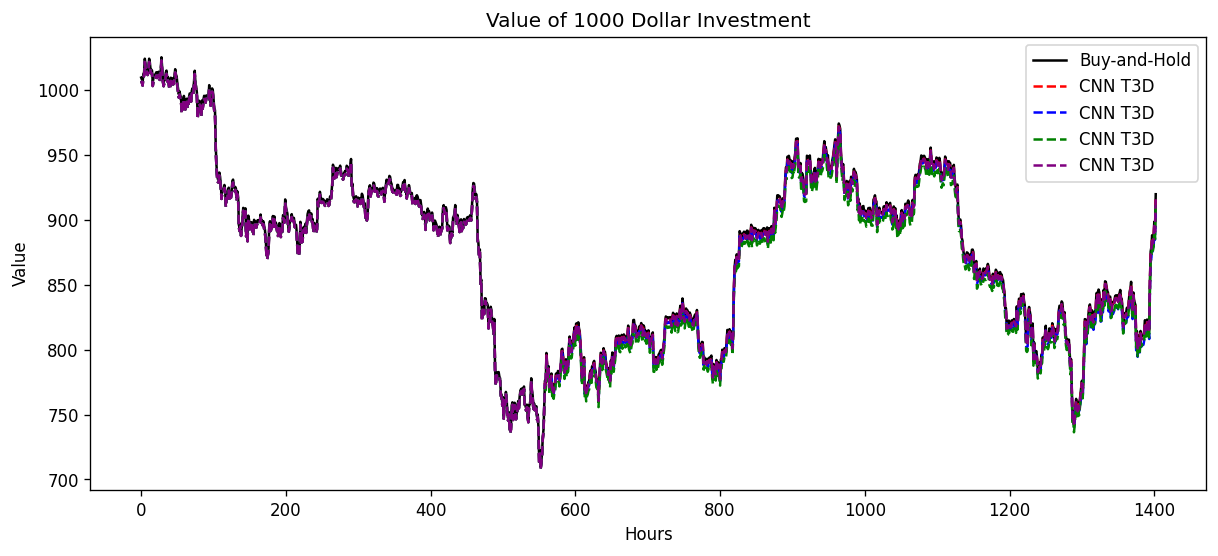

In [248]:
agents_net_worths=[net_worths1, net_worths2, net_worths3, net_worths4]
portfolio_movement_5_agents(agents_net_worths, B_and_H, 'CNN T3D', 11, -1)
print('Our final values for these models are:',
      '\n',
      round(net_worths1[-1],5), 'dollars,',
      '\n',
      round(net_worths2[-1],5), 'dollars,',
      '\n',
      round(net_worths3[-1],5), 'dollars,',
      '\n',
      round(net_worths4[-1],5), 'dollars.')

### Etherium 2022

In [51]:
# Redoing Buy-and-Hold

dfs=['Non-Scaled TA Features 1H for ETH 2022.csv']

def testing_data_pct_changes(dfs, time_frame):
    if time_frame == 'hour':
        X=pd.read_csv(dfs[0])
        X['Date']=pd.to_datetime(X['Date']) # Setting the index as the Date
        X=X.set_index('Date').asfreq('H')
        X=X.dropna()
        y=X['Percent Change']
        X=X.drop('Label', axis=1)
        X=X.drop('Percent Change', axis=1)

        # Removing the testing data
        X_test=X['2022-01-01 0:00:00':] # Getting the last 6 months as the testing data
        y_test=y['2022-01-01 0:00:00':]

    return X_test, y_test/100

def Buy_and_Hold(test_pct_changes, init_balance):
    curr_balance=init_balance
    balances=[]
    
    for pct_chng in test_pct_changes:
        curr_balance=curr_balance*(1+pct_chng)
        balances.append(curr_balance)
        
    return balances

init_balance=1000
_,y_test=testing_data_pct_changes(dfs, 'hour')
B_and_H=Buy_and_Hold(y_test, init_balance)
print('The length of Buy-and-Hold is:',len(B_and_H))
print('Buy-and-Hold runs from', y_test.index[0], 'to', y_test.index[-1])

The length of Buy-and-Hold is: 1415
Buy-and-Hold runs from 2022-01-01 00:00:00 to 2022-02-28 22:00:00


Final Value of Buy-and-Hold for Ethereum in 2022: 775.0371846020829


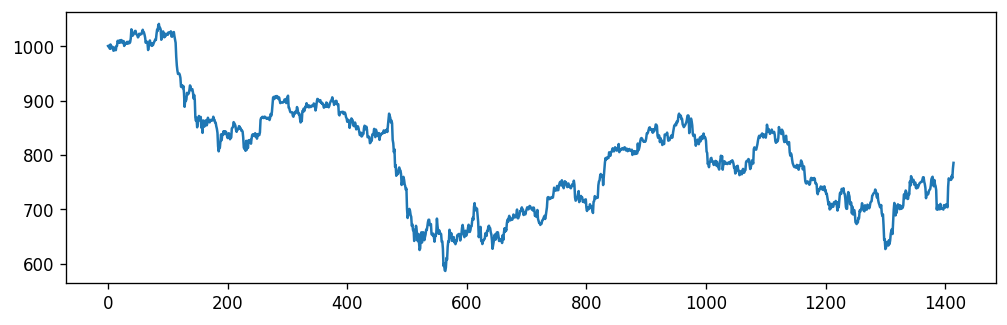

In [52]:
plt.plot(B_and_H)
print('Final Value of Buy-and-Hold for Ethereum in 2022:',B_and_H[-2])

In [53]:
# Train and test splitting and scaling
X=pd.read_csv(dfs[0])

X['Date']=pd.to_datetime(X['Date']) # Setting the index as the Date
X=X.set_index('Date').asfreq('H')

X=X.dropna()
y=X['Percent Change']
X=X.drop('Label', axis=1)
X=X.drop('Percent Change', axis=1)

starting_hour = '2022-01-01 0:00:00'

# Removing the testing data
X_test=X['2022-01-01 0:00:00':] # Getting the last 6 months as the testing data
print('Confirming we have all the columns we want:','\n', X_test.columns)
y_test=y['2022-01-01 0:00:00':].values

X=X[:'2022-01-01 0:00:00'] # Getting everything but the first 6 months as the training data
y=y[:'2022-01-01 0:00:00']

Confirming we have all the columns we want: 
 Index(['BB_upper 10', 'BB_middle 10', 'BB_lower 10', 'Aroon_down 10',
       'Aroon_up 10', 'Aroonosc 10', 'RSI 10', 'NATR 10', 'BB_upper 12',
       'BB_middle 12',
       ...
       'MACD Signal 18', 'MACD Hist18', 'Med Price', 'Chaikin A/D Line',
       'HT Dom Phase', 'HT Dom Period', 'High', 'Low', 'Close', 'Volume'],
      dtype='object', length=101)


In [54]:
n_steps=12

# First, we create our PCA matrices from the X and X_test
X, X_test=PCA_creation_train_test(20, X, X_test)
    
# Getting the X and X_test matrices' images
X_train, y_train=image_creation(n_steps, X ,y)
X_test, y_test=image_creation(n_steps, X_test, y_test)
y_train=np.array(y_train)
y_test=np.array(y_test)

# Finalizing the shapes
num_classes = 2
input_shape = (n_steps, len(X[0]), 1)

# Add a dimension at the beginning end to make sure images have shape (1, n_steps, n_features)
# Note this is the OPPOSITE of tensorflow
X_train = np.expand_dims(X_train, 1)
X_test = np.expand_dims(X_test, 1)
print("X_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

X_train shape: (30646, 1, 12, 20)
30646 train samples
1403 test samples


In [65]:
# Loading an agent

agent = torch.load('Models/CNN T3D gamma_0.25 BTC.h5')

In [258]:
net_worths1=investing_performance_rl('Models/CNN T3D gamma_0.25 BTC.h5', X_test, y_test, 'T3D')
net_worths1=[x[0] for x in net_worths1]
net_worths2=investing_performance_rl('Models/CNN T3D gamma_0.25 BTC.h5', X_test, y_test, 'T3D')
net_worths2=[x[0] for x in net_worths2]
net_worths3=investing_performance_rl('Models/CNN T3D gamma_0.25 BTC.h5', X_test, y_test, 'T3D')
net_worths3=[x[0] for x in net_worths3]
net_worths4=investing_performance_rl('Models/CNN T3D gamma_0.25 BTC.h5', X_test, y_test, 'T3D')
net_worths4=[x[0] for x in net_worths4]

The lengths of Buy-and-Hold and the agents are the same.
The lengths of the net worths and the Buy-and-Hold startegies are 1403 1403 1403 1403 1403
The final value with Buy-and-Hold is 775.04
Our final values for these models are: 
 780.8964 dollars, 
 780.90454 dollars, 
 780.86145 dollars, 
 771.50226 dollars.


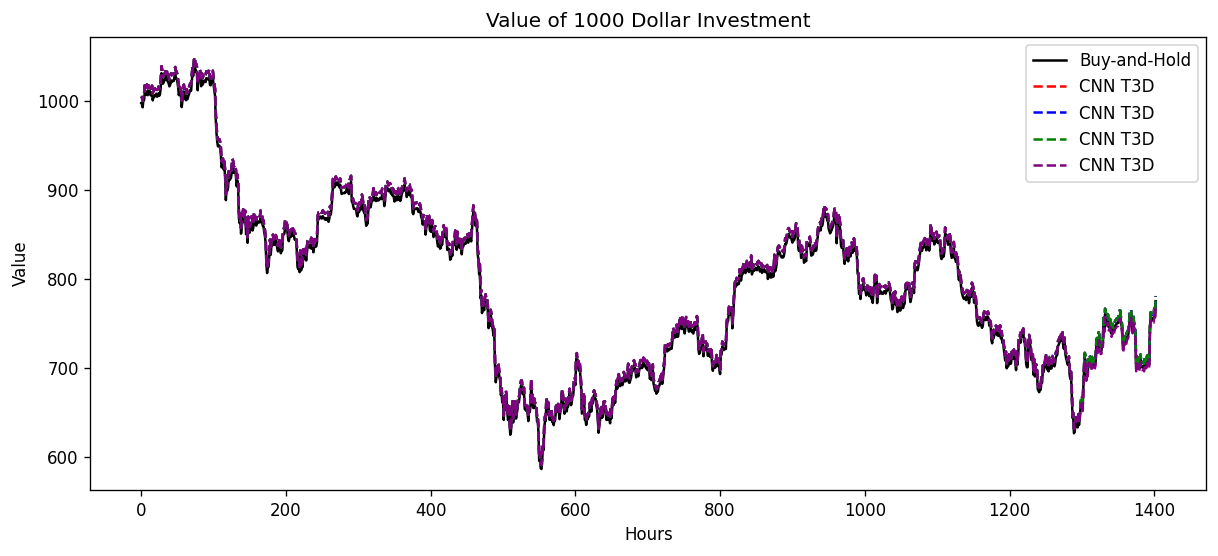

In [259]:
agents_net_worths=[net_worths1, net_worths2, net_worths3, net_worths4]
portfolio_movement_5_agents(agents_net_worths, B_and_H, 'CNN T3D', 11, -1)
print('Our final values for these models are:',
      '\n',
      round(net_worths1[-1],5), 'dollars,',
      '\n',
      round(net_worths2[-1],5), 'dollars,',
      '\n',
      round(net_worths3[-1],5), 'dollars,',
      '\n',
      round(net_worths4[-1],5), 'dollars.')

### Litecoin 2022

In [260]:
# Redoing Buy-and-Hold

dfs=['Non-Scaled TA Features 1H for LTC 2022.csv']

def testing_data_pct_changes(dfs, time_frame):
    if time_frame == 'hour':
        X=pd.read_csv(dfs[0])
        X['Date']=pd.to_datetime(X['Date']) # Setting the index as the Date
        X=X.set_index('Date').asfreq('H')
        X=X.dropna()
        y=X['Percent Change']
        X=X.drop('Label', axis=1)
        X=X.drop('Percent Change', axis=1)

        # Removing the testing data
        X_test=X['2022-01-01 0:00:00':] # Getting the last 6 months as the testing data
        y_test=y['2022-01-01 0:00:00':]

    return X_test, y_test/100

def Buy_and_Hold(test_pct_changes, init_balance):
    curr_balance=init_balance
    balances=[]
    
    for pct_chng in test_pct_changes:
        curr_balance=curr_balance*(1+pct_chng)
        balances.append(curr_balance)
        
    return balances

init_balance=1000
_,y_test=testing_data_pct_changes(dfs, 'hour')
B_and_H=Buy_and_Hold(y_test, init_balance)
print('The length of Buy-and-Hold is:',len(B_and_H))
print('Buy-and-Hold runs from', y_test.index[0], 'to', y_test.index[-1])

Date
2022-01-01 00:00:00   -0.001544
2022-01-01 01:00:00   -0.003362
2022-01-01 02:00:00   -0.003238
2022-01-01 03:00:00   -0.006701
2022-01-01 04:00:00    0.009812
                         ...   
2022-02-28 18:00:00    0.001465
2022-02-28 19:00:00    0.003748
2022-02-28 20:00:00    0.007287
2022-02-28 21:00:00    0.011393
2022-02-28 22:00:00    0.016898
Freq: H, Name: Percent Change, Length: 1415, dtype: float64
The length of Buy-and-Hold is: 1415
Buy-and-Hold runs from 2022-01-01 00:00:00 to 2022-02-28 22:00:00


Final Value of Buy-and-Hold for Litecoin in 2022: 775.0371846020829


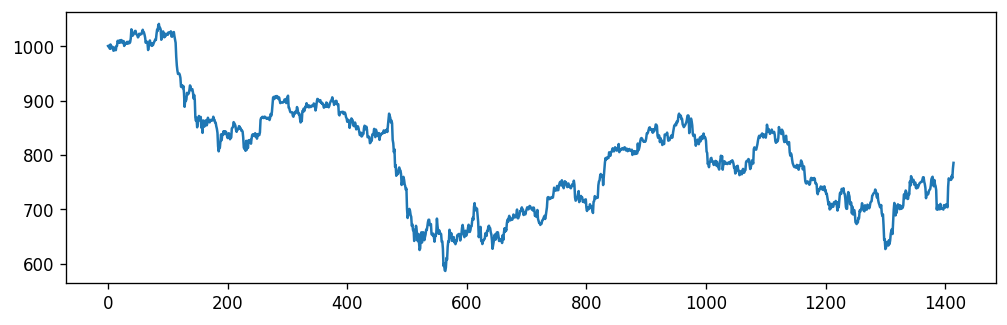

In [55]:
plt.plot(B_and_H)
print('Final Value of Buy-and-Hold for Litecoin in 2022:',B_and_H[-2])

In [59]:
# Train and test splitting and scaling
X=pd.read_csv(dfs[0])

X['Date']=pd.to_datetime(X['Date']) # Setting the index as the Date
X=X.set_index('Date').asfreq('H')

X=X.dropna()
y=X['Percent Change']
X=X.drop('Label', axis=1)
X=X.drop('Percent Change', axis=1)

starting_hour = '2022-01-01 0:00:00'

# Removing the testing data
X_test=X['2022-01-01 0:00:00':] # Getting the last 6 months as the testing data
print('Confirming we have all the columns we want:','\n', X_test.columns)
y_test=y['2022-01-01 0:00:00':].values

X=X[:'2022-01-01 0:00:00'] # Getting everything but the first 6 months as the training data
y=y[:'2022-01-01 0:00:00']

Confirming we have all the columns we want: 
 Index(['BB_upper 10', 'BB_middle 10', 'BB_lower 10', 'Aroon_down 10',
       'Aroon_up 10', 'Aroonosc 10', 'RSI 10', 'NATR 10', 'BB_upper 12',
       'BB_middle 12',
       ...
       'MACD Signal 18', 'MACD Hist18', 'Med Price', 'Chaikin A/D Line',
       'HT Dom Phase', 'HT Dom Period', 'High', 'Low', 'Close', 'Volume'],
      dtype='object', length=101)


In [60]:
n_steps=12

# First, we create our PCA matrices from the X and X_test
X, X_test=PCA_creation_train_test(20, X, X_test)
    
# Getting the X and X_test matrices' images
X_train, y_train=image_creation(n_steps, X ,y)
X_test, y_test=image_creation(n_steps, X_test, y_test)
y_train=np.array(y_train)
y_test=np.array(y_test)

# Finalizing the shapes
num_classes = 2
input_shape = (n_steps, len(X[0]), 1)

# Add a dimension at the beginning end to make sure images have shape (1, n_steps, n_features)
# Note this is the OPPOSITE of tensorflow
X_train = np.expand_dims(X_train, 1)
X_test = np.expand_dims(X_test, 1)
print("X_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

X_train shape: (30646, 1, 12, 20)
30646 train samples
1403 test samples


In [66]:
# Loading an agent

agent = torch.load('Models/CNN T3D gamma_0.25 BTC.h5')

In [269]:
net_worths1=investing_performance_rl('Models/CNN T3D gamma_0.25 BTC.h5', X_test, y_test, 'T3D')
net_worths1=[x[0] for x in net_worths1]
net_worths2=investing_performance_rl('Models/CNN T3D gamma_0.25 BTC.h5', X_test, y_test, 'T3D')
net_worths2=[x[0] for x in net_worths2]
net_worths3=investing_performance_rl('Models/CNN T3D gamma_0.25 BTC.h5', X_test, y_test, 'T3D')
net_worths3=[x[0] for x in net_worths3]
net_worths4=investing_performance_rl('Models/CNN T3D gamma_0.25 BTC.h5', X_test, y_test, 'T3D')
net_worths4=[x[0] for x in net_worths4]

The lengths of Buy-and-Hold and the agents are the same.
The lengths of the net worths and the Buy-and-Hold startegies are 1403 1403 1403 1403 1403
The final value with Buy-and-Hold is 750.87
Our final values for these models are: 
 757.939 dollars, 
 757.94293 dollars, 
 757.913 dollars, 
 757.90295 dollars.


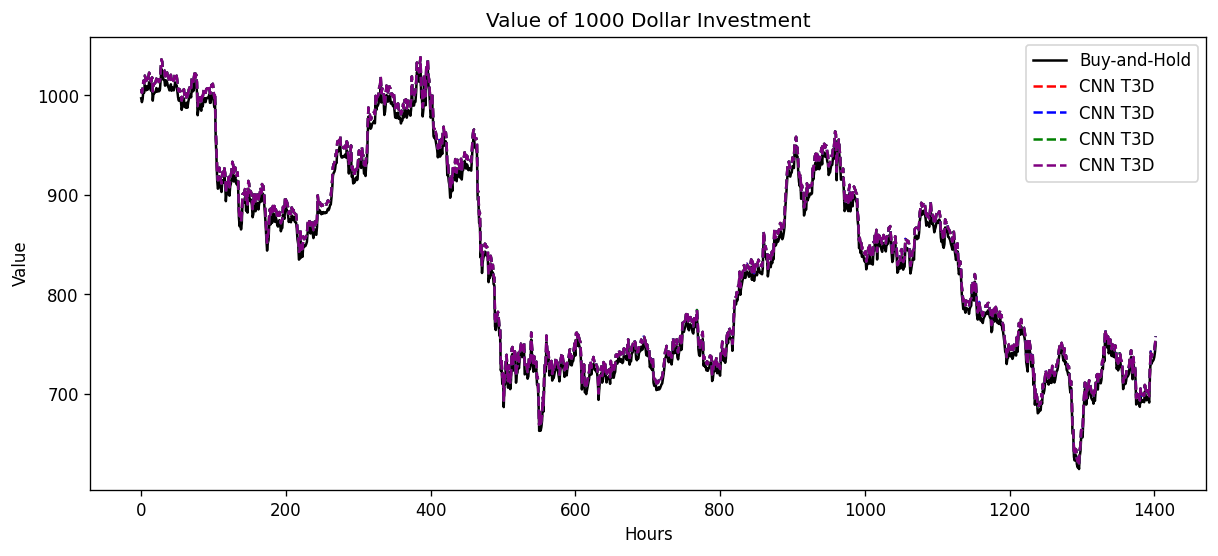

In [270]:
agents_net_worths=[net_worths1, net_worths2, net_worths3, net_worths4]
portfolio_movement_5_agents(agents_net_worths, B_and_H, 'CNN T3D', 11, -1)
print('Our final values for these models are:',
      '\n',
      round(net_worths1[-1],5), 'dollars,',
      '\n',
      round(net_worths2[-1],5), 'dollars,',
      '\n',
      round(net_worths3[-1],5), 'dollars,',
      '\n',
      round(net_worths4[-1],5), 'dollars.')